# Time Series Forecasting

A **time series** is a sequence of observations collected at successive points in time, typically at regular intervals. Using functional notation, a time series can be written as:

$\displaystyle y(t), \quad t = 1, 2, \dots, T$

where y(t) denotes the value of the observed variable at time t. Common examples include the number of daily active users on a website, hourly temperature measurements in a city, a household’s daily electricity consumption, or the trajectories of nearby vehicles. What distinguishes time series data is their **temporal ordering**: observations are not independent, and the order in which they occur is essential. In general, the value at time t depends on its past:

$\displaystyle y(t) = f\left(y(t-1), y(t-2), \dots\right) + \varepsilon(t)$

where 
- $f(\cdot)$ captures **temporal patterns** such as trends, cycles, and recurring behaviors
- $\varepsilon(t)$ represents noise

By analyzing how the signal y(t) evolves over time, we can **learn patterns from the past** and use them to **forecast future values**, under the assumption that these patterns **persist**.

As a concrete example, consider the dataset reporting the daily number of passengers using buses and rail services operated by the Chicago Transit Authority. This dataset is publicly available from the [Chicago Data Portal](https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97/about_data) and provides a real-world illustration of time series data used for forecasting.

In [3]:
import urllib.request
import zipfile 
import os

# Define the URL of the dataset
url = "https://www.dropbox.com/s/wiww3a55sgifhb3/ridership.zip?dl=1"

# Create data directory if it does not exist
os.makedirs("./data", exist_ok=True)

# Prepare data if not already existing 
if not os.path.exists("./data/ridership.zip"):
   print("Downloading dataset...")

   # Download the dataset
   u = urllib.request.urlopen(url)
   data = u.read()
   u.close()

   # Save the dataset to a local file
   with open("./data/ridership.zip", "wb") as f :
      f.write(data)

   # Extract the dataset
   with zipfile.ZipFile("./data/ridership.zip","r") as zip_ref:
      zip_ref.extractall("./data")
    
else:
   print("Dataset already exists. Skipping download.")

Dataset already exists. Skipping download.


We fix the seed of the random number generator in order to reproduce the results:

In [4]:
import torch;
import numpy as np;
import random;

# set the seeds for reproducibility of results
seed = 42;

torch.manual_seed(seed);
np.random.seed(seed);
random.seed(seed);

We begin by **loading and cleaning the dataset**. Specifically, we read the CSV file, assign concise column names, sort the observations chronologically, remove the redundant total column, and eliminate any duplicate rows:

In [5]:
import pandas as pd

# Load the dataset into a Pandas DataFrame
ridership = pd.read_csv("./data/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv", 
                        parse_dates=["service_date"])

# Assign concise column names
ridership.columns = ["date", "day_type", "bus", "rail", "total"]

# Sort the DataFrame by date and set date as index
ridership = ridership.sort_values("date").set_index("date")

# Remove the redundant total column
ridership = ridership.drop("total", axis=1)

# Drop duplicate rows
ridership = ridership.drop_duplicates()

We now inspect the first few rows of the dataset in order to understand its structure and contents:

In [6]:
# Inspect the first few rows of the dataset
ridership.head()

day_type     bus    rail
date                               
2001-01-01        U  297192  126455
2001-01-02        W  780827  501952
2001-01-03        W  824923  536432
2001-01-04        W  870021  550011
2001-01-05        W  890426  557917

This dataset represents a **time series**, where observations are recorded at regular time intervals. More specifically, because multiple variables are observed at each time step, it is a **multivariate time series**. The "day_type" column encodes the type of day: W for weekdays, A for Saturdays, and U for Sundays or public holidays.

## Forecasting

The most common task in time series analysis is **forecasting**, which consists in predicting future values of a signal based solely on its past observations. Formally, given a time series y(t) observed up to time t, the goal of forecasting is to estimate one or more future values:

$\displaystyle \hat{y}(t+1), \hat{y}(t+2), \dots, \hat{y}(t+H)$

where $H$ is the forecasting **horizon**.

In other words, forecasting aims to learn a function:

$\displaystyle \hat{y}(t+h) = f\left(y(t), y(t-1), \dots\right)$

that **maps the historical evolution of the series to its future behavior**, under the assumption that the underlying temporal patterns remain stable.

In the concrete example, given the observed ridership up to today, we may want to forecast tomorrow’s demand or the ridership over the next week. Such forecasts are essential for operational planning, resource allocation, and service optimization.

### Seasonality and Naive Forecasting

To build some intuition, let’s plot the bus and rail ridership over a few months in 2019 and observe their behavior over time.

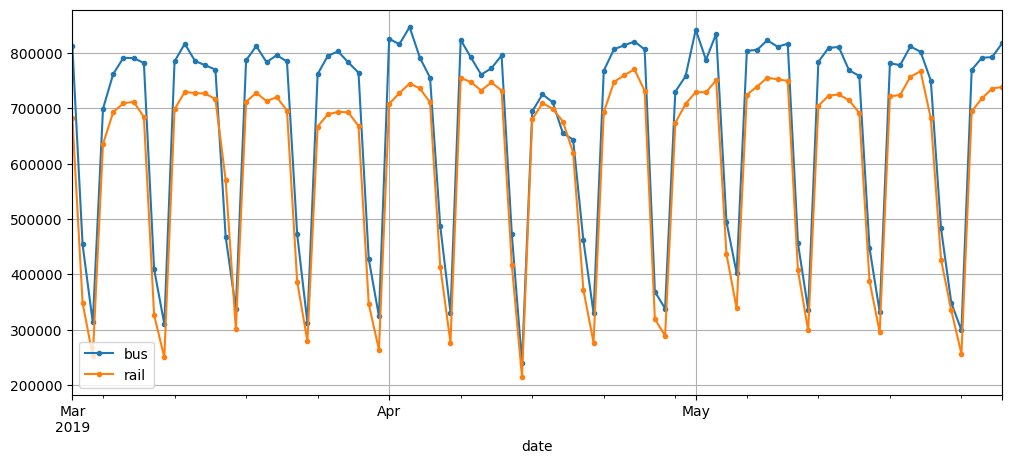

In [7]:
import matplotlib.pyplot as plt

# Plot bus and rail ridership from March to May 2019
ridership["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(12, 5))
plt.show()

We can clearly observe a **recurring weekly pattern**, known as **seasonality**. In this case, the seasonal effect is so strong that even a very simple strategy, such as predicting tomorrow’s ridership by copying the value observed one week earlier, already yields reasonably good results. This approach is known as **naive forecasting** and predicts future values by reusing past observations from the previous seasonal cycle. For a weekly seasonal pattern, the naive forecast can be written as

$\displaystyle \hat{y}(t) = y(t-7)$

In [8]:
def naive(y):
    return y.shift(7)

Despite its simplicity, naive forecasting often provides a strong and informative **baseline** against which more sophisticated models can be compared. To make the weekly seasonality explicit, we can compute the **7-day difference**, defined as

$\displaystyle \Delta_7 y(t) = y(t) - y(t-7)$

If the series exhibits a strong weekly pattern, the **differenced signal** will fluctuate around zero, since values one week apart tend to be similar. In practice, this operation can be conveniently performed using the Pandas **diff()** method, which computes the difference between each value and the value observed a specified number of periods earlier:

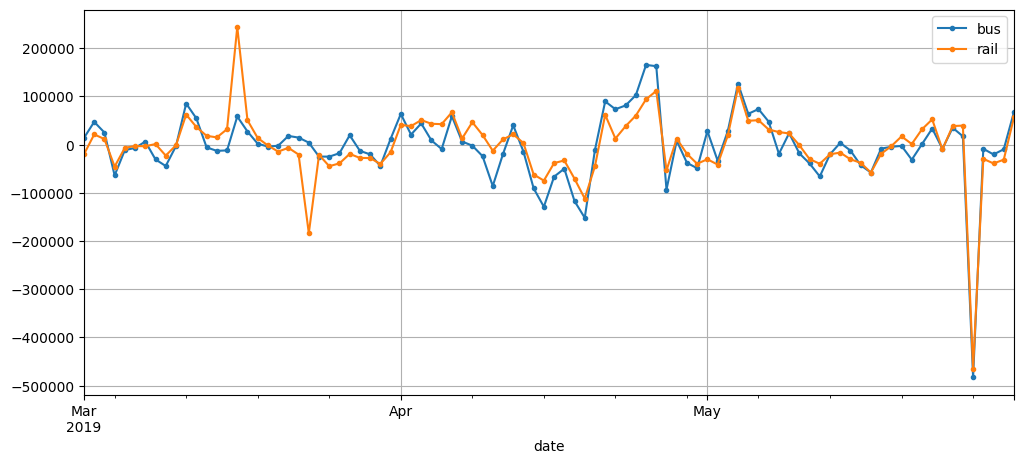

In [9]:
# Compute the difference betweem each value and the value observed 7 days earlier
diff_7 = ridership[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

# Plot the differenced series to highlight seasonality
diff_7.plot(grid=True, marker=".", figsize=(12, 5)) 
plt.show()

Notice how closely the lagged time series follows the original one. When a time series shows a **strong correlation with a time-shifted version of itself**, we say that it exhibits **autocorrelation**. In this case, most of the differences remain quite small, indicating a strong weekly autocorrelation. An exception appears toward the end of May, where the differences become larger. This deviation may be due to a disruption of the usual pattern, such as a public holiday. To verify this, let’s inspect the day types for that period:

In [10]:
# Check the day_type column for the end of May 2019
list(ridership.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

### Performance Evaluation

The period with deviations corresponds to a long weekend, with Monday being the Memorial Day holiday. Such **calendar effects** can disrupt the usual seasonal pattern and may be explicitly modeled to improve forecasting accuracy. For now, however, we deliberately keep the model simple. To obtain a first **quantitative assessment** of our forecasting approach, we compute the **Mean Absolute Error (MAE)** over a three-month period. Given a sequence of true values and the corresponding forecasts, the MAE is defined as:

$\displaystyle \mathrm{MAE} = \frac{1}{T} \sum_{t=1}^{T} \lvert y(t) - \hat{y}(t) \rvert$

This metric measures the average magnitude of the forecast errors in the original units of the data, providing an intuitive indication of how far the predictions are, on average, from the true observations. As a **baseline** for comparison, we evaluate the naive forecasting model by computing its MAE over a test period, for the rail ridership:

In [11]:
# We define a period for testing to be used for all models
transit_train_end_date = "2019-02-28"
transit_test_start_date = "2019-03-01"
transit_test_end_date = "2019-05-31"
transit_test_period = pd.date_range(transit_test_start_date, 
                                    transit_test_end_date, freq="D")

# Build rail series with sufficient history
transit_origin = "2019-01-01"
rail_series = ridership.loc[transit_origin:transit_test_end_date, "rail"].asfreq("D")

# List to store one-step-ahead predictions
y_preds = []

# Walk-forward naive forecasts over the test period
for day in transit_test_period:
    
    # Forecast the next day (one-step ahead)
    y_pred = naive(rail_series.loc[:day]).loc[day]

    # Store the prediction
    y_preds.append(y_pred)

# Convert predictions to a time-indexed Series
y_preds_naive = pd.Series(y_preds, index=transit_test_period)

# Targets for normalization
rail_targets = rail_series.loc[transit_test_period]  

# Compute SARIMA MAPE
mae_naive_rail = ((y_preds_naive - rail_targets)).abs().mean()

# Display the MAE results
print(f"Naive MAE: {mae_naive_rail:.2f}")

Naive MAE: 42143.27


At first glance, it is difficult to judge whether these errors are **large or small**. To put them into perspective, we normalize the forecast errors by dividing them by the corresponding target values.  This metric is known as the **Mean Absolute Percentage Error (MAPE)** and is defined as:

$\displaystyle \mathrm{MAPE} = \frac{1}{T} \sum_{t=1}^{T} \left| \frac{y(t) - \hat{y}(t)}{y(t)} \right| \times 100$

In [12]:
# Mean Absolute Percentage Error over the test period
mape_naive = ((y_preds_naive - rail_targets)/rail_targets).abs().mean()

# Print result
print(f"Naive MAPE: {mape_naive:.2%}")

Naive MAPE: 8.99%


An interesting observation is that, while the **MAE** appears slightly better for rail than for bus, the opposite holds when we consider **MAPE**. This happens because bus ridership volumes are generally larger than rail ridership volumes, which naturally leads to larger **absolute errors**:

$\displaystyle |y(t) - \hat{y}(t)|$

However, when forecast errors are expressed **relative to the true values**, the bus forecasts turn out to be slightly more accurate than the rail forecasts. For completeness, the **Mean Squared Error (MSE)** is defined as:

$\displaystyle \mathrm{MSE} = \frac{1}{T} \sum_{t=1}^{T} \big(y(t) - \hat{y}(t)\big)^2$

MSE measures the average **squared** difference between the observed values and the corresponding forecasts over time. MSE **penalizes large forecast errors** more heavily than small ones, making it particularly sensitive to outliers and abrupt deviations. This property is useful when large errors are especially undesirable.

In [13]:
# Mean Squared Error over the test period
mse_naive_rail = ((y_preds_naive - rail_targets) ** 2).mean()

# Print result
# Print result
print(f"Naive MSE: {mse_naive_rail:.2f}")

Naive MSE: 5022871922.03


The **MAE**, **MAPE**, and **MSE** are among the most commonly used metrics for evaluating forecasting performance. As always, the choice of metric should be guided by the **scale of the data** and the **specific objectives** of the forecasting task.

### Long-Term Patterns

By visually inspecting the time series, it is difficult to identify any clear **long-term trend** or **seasonal pattern** beyond the strong weekly seasonality. To further investigate this aspect, we can analyze the series at different temporal scales by **aggregating** observations over different time intervals.

Let $\mathcal{T}_k$ denote a generic time window (for example, a month, a quarter, or a year). An aggregated version of the time series can then be defined as:

$\displaystyle y^{(\text{agg})}(k) = \frac{1}{|\mathcal{T}_k|} \sum_{t \in \mathcal{T}_k} y(t)$

where $|\mathcal{T}_k|$ is the number of observations contained in the time window. By choosing different definitions of time window, we can construct monthly, quarterly, or yearly aggregated series, each emphasizing patterns at a different temporal scale.

In practice, this type of temporal aggregation is conveniently performed using the Pandas **resample()** method, which transforms a time series from one temporal resolution to another by **grouping observations into time-based windows** defined by a chosen resampling rule. The method requires a **DateTimeIndex** and produces a grouped representation of the data, which can then be summarized using aggregation operators such as the mean, sum, or median.

Aggregating a time series over long intervals compresses many observations into a single value. While this helps reveal broad trends, **it also hides information about how the series behaves within each interval**. In other words, aggregation tells us what happens on average, but not how the process evolves over time. **Rolling statistics** address this limitation by averaging over a moving window: instead of collapsing the data, they slide smoothly along the time axis. This preserves the temporal ordering of the observations while filtering out short-term noise, making it easier to visually track the gradual evolution of long-term trends and seasonal effects as they unfold

Given a window length m, the rolling average of the series is defined as:

$\displaystyle \bar{y}^{(m)}(t) = \frac{1}{m} \sum_{i=0}^{m-1} y(t-i)$

This operation replaces each observation with the average of the previous m values, producing a smoothed version of the series. Smaller values of m highlight medium-term fluctuations, while larger values emphasize long-term trends and low-frequency seasonal components.

In Pandas, rolling statistics are computed using the **rolling()** method, which applies a sliding window over the time series and computes the desired statistic for each position of the window.

By combining **aggregation** and **rolling averages**, we can study the time series at multiple temporal scales and more effectively assess the presence of **long-term trends** and **seasonal patterns** that may not be visible at the original resolution.

In the example, we can analyze data from 2001 to 2019 and visualize both the monthly aggregated series and its 12-month rolling average in order to assess the presence of **yearly seasonality** and **long-term trends** in the data:

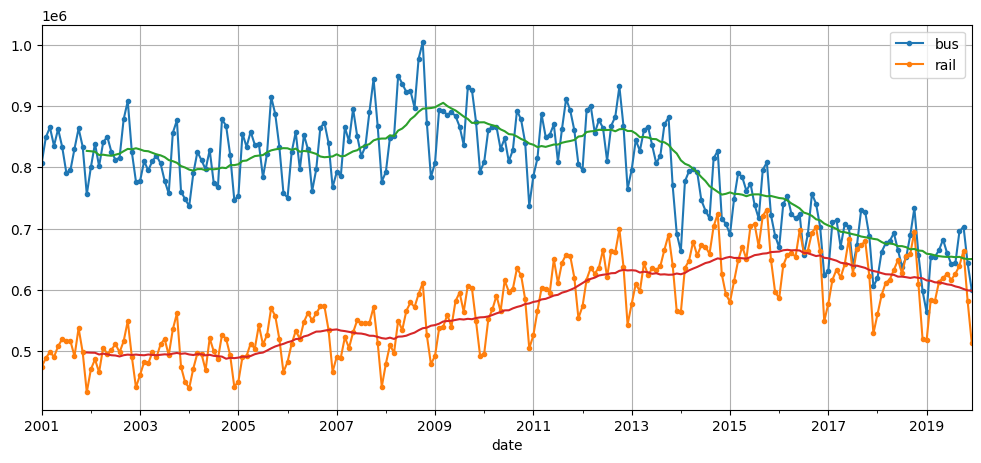

In [14]:
# Select a longer period for yearly seasonality analysis
period = slice("2001", "2019")

# Remove the day_type column for resampling
df_monthly = ridership.loc[ : , ridership.columns!='day_type']

# Compute the mean for each month
df_monthly = df_monthly.resample(rule='ME').mean() 

# Compute the 12-month rolling average
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

# Plot the monthly data along with rolling average
fig, ax = plt.subplots(figsize=(12, 5))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

The data exhibit a degree of **yearly seasonality**, although it is noisier than the weekly pattern and more pronounced in the rail series than in the bus series. In particular, we observe peaks and troughs occurring at approximately the same times each year. To make this yearly pattern more explicit, let’s examine the **12-month difference** of the series:

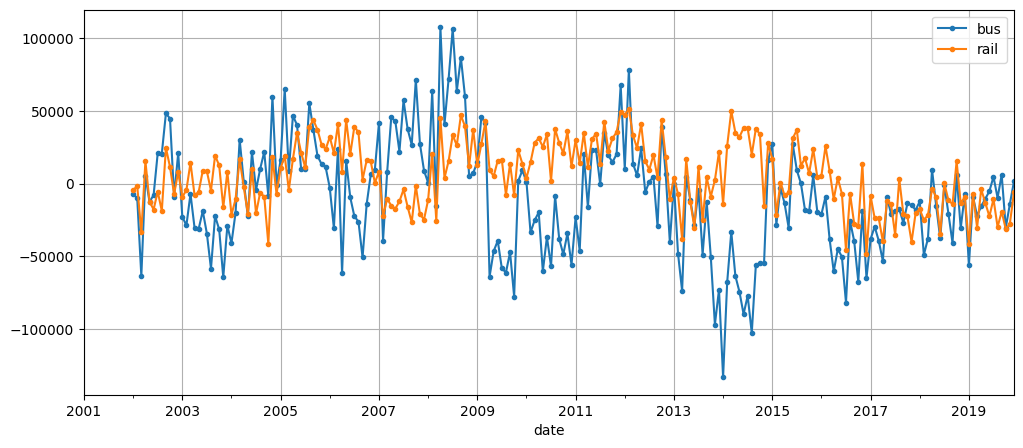

In [15]:
# Compute the 12-month difference
diff_12 = df_monthly.diff(12)[period]

# Plot the differenced series to highlight seasonality
diff_12.plot(grid=True, marker=".", figsize=(12, 5)) 
plt.show()

After applying the 12-month differencing, the yearly seasonal pattern and long-term trend are largely removed, and the series now fluctuates around zero, making deviations and anomalies much more apparent.

## Moving Average Models

Moving Average models are a class of time series models where the present value is explained not by past values of the series itself, but by how the system has recently deviated from its own predictions, capturing the impact of short-lived random disturbances.

### Autoregressive Moving Average (ARMA)

An alternative to naive forecasting is the **Autoregressive Moving Average (ARMA)** model, which generates forecasts by combining two complementary mechanisms. It predicts future values as a **weighted sum of past observations** and refines these predictions by incorporating a **weighted sum of recent forecast errors**:

$\displaystyle \hat{y}(t) = \sum_{i=1}^{p} \alpha_i \, y(t-i) + \sum_{i=1}^{q} \beta_i \, \epsilon(t-i)$

where the forecast error is defined as

$\displaystyle \epsilon(t) = y(t) - \hat{y}(t)$

The first term is the **autoregressive (AR)** component, which captures how past values of the series influence the current value. The second term is the **moving average (MA)** component, which corrects the forecast using information contained in past prediction errors. The hyperparameters p and q determine how many past observations and past errors are taken into account, respectively. In practice, there is no single "correct" choice for p and q. A common and effective strategy is to start with **small values**, fit the model to estimate the parameters $\alpha_i$ and $\beta_i$ (typically using **maximum likelihood estimation**), and then examine the model’s **diagnostics**, such as residual autocorrelation and error behavior. If the residuals resemble **white noise**, the model has successfully captured the relevant temporal structure of the data. If systematic patterns remain, the model is too simple and should be refined by increasing p and/or q. Conversely, if increasing model complexity does not lead to a meaningful improvement in the diagnostics, adding more parameters is unlikely to be beneficial and may instead result in **overfitting**, where the model begins to fit noise rather than signal.

This iterative procedure balances **model expressiveness**, the ability to capture temporal dependencies, and **parsimony**, the principle of keeping the model as simple as possible, ensuring that the chosen model explains the data well without introducing unnecessary parameters.

### Autoregressive Integrated Moving Average (ARIMA)

The previous model works well when the time series is **stationary**, meaning that its statistical properties, such as mean and variance, do not change over time:

$\displaystyle \mathbb{E}[y(t)] = \mu, \qquad \mathrm{Var}(y(t)) = \sigma^2 \quad \forall, t$

When a series contains **trends** or evolving patterns, this assumption is violated. In such cases, **differencing** provides a simple yet powerful way to remove non-stationary components. A **one-step difference** is defined as:

$\displaystyle \Delta y(t) = y(t) - y(t-1)$

This operation is analogous to a **first-order derivative** in discrete time: it measures how much the series changes from one time step to the next and removes any **linear trend**. For example, the series:

$\displaystyle y(t) = [3, 5, 7, 9, 11]$

grows linearly. Applying first differencing yields:

$\displaystyle \Delta y(t) = [2, 2, 2, 2]$

indicating a constant slope and showing that the original linear trend has been removed. If the series follows a **quadratic trend**, a single round of differencing is not sufficient. Consider the series:

$\displaystyle y(t) = [1, 4, 9, 16, 25, 36]$

After one differencing step we obtain:

$\displaystyle \Delta y(t) = [3, 5, 7, 9, 11]$

which is still trending. Applying differencing a **second time**:

$\displaystyle \Delta^2 y(t) = \Delta(\Delta y(t)) = y(t) - 2y(t-1) + y(t-2)$

yields:

$\displaystyle [2, 2, 2, 2]$

which removes the remaining structure. A convenient notation to express these operations is the **lag operator** L, which represents a shift backward in time:

$\displaystyle Ly(t) = y(t-1)$

Applying the operator multiple times produces larger shifts:

$\displaystyle L^2y(t) = y(t-2), \quad L^3y(t) = y(t-3)$, and so on.

In general,

$\displaystyle L^ky(t) = y(t-k)$

Using this notation, a one-step difference can be written compactly as:

$\displaystyle \Delta y(t) = y(t) - y(t-1) = y(t) - Ly(t) = (1 - L)y(t)$

while a second difference becomes:

$\displaystyle \Delta^2 y(t) = (1 - L)[(1 - L) y(t)] = (1 - L)^2 y(t) = y(t) - 2y(t-1) + y(t-2)$

More generally, applying differencing d times gives:

$\displaystyle \Delta^d y(t) = (1 - L)^d y(t)$

This operation approximates the **d-th derivative** of the series and removes **polynomial trends up to degree d**. The hyperparameter d is called the **order of integration**. This idea lies at the core of the **Autoregressive Integrated Moving Average (ARIMA)** model. Before modeling temporal dependencies using an ARMA model, the series is first "flattened" through differencing so that its statistical properties remain stable over time:

$\displaystyle z(t) = \Delta^d y(t) = (1 - L)^d y(t)$

An ARMA model is then applied to the differenced series:

$\displaystyle \hat{z}(t) = \sum_{i=1}^{p} \alpha_i \, z(t-i) + \sum_{i=1}^{q} \beta_i \, \epsilon(t-i)$

with prediction error

$\displaystyle \epsilon(t) = z(t) - \hat{z}(t)$

In summary, ARIMA is characterized by three hyperparameters: p and q, as in ARMA, and the additional parameter d, which controls the degree of differencing applied to the series before fitting the ARMA model.

### Seasonal ARIMA (SARIMA)

A natural final extension of ARIMA is the **Seasonal ARIMA (SARIMA)** model, which explicitly accounts for **seasonal patterns**. The key idea is that many time series evolve on **two time scales simultaneously**:

* a **short-term scale**, capturing local dynamics from one time step to the next;
* a **seasonal scale**, capturing patterns that repeat every s time steps.

While ARIMA models only the short-term structure, SARIMA augments it by introducing additional autoregressive and moving-average components that operate at the **seasonal lag**. To do this, the model introduces three **seasonal hyperparameters** P, D, and Q, together with the **seasonal period** s. After applying both regular and seasonal differencing, the transformed series is defined as:

$\displaystyle z(t) = \Delta^d \Delta_s^D y(t) = (1 - L)^d (1 - L_s)^D y(t)$

An ARMA model is then applied to this stationary series:

$\displaystyle \hat{z}(t) = \underbrace{\sum_{i=1}^{p} \alpha_i \, z(t-i)}_{\text{non-seasonal AR}} \; + \; \underbrace{\sum_{i=1}^{P} A_i \, z(t-i \cdot s)}_{\text{seasonal AR}} \; + \; \underbrace{\sum_{i=1}^{q} \beta_i \, \epsilon(t-i)}_{\text{non-seasonal MA}}\; + \;  \underbrace{\sum_{i=1}^{Q} B_i\, \epsilon(t-i \cdot s)}_{\text{seasonal MA}}$

with prediction error:

$\displaystyle \epsilon(t) = z(t) - \hat{z}(t)$

In this formulation, the non-seasonal terms model short-term dependencies, while the seasonal terms capture repeating patterns occurring every s time steps. Together, these components allow SARIMA to represent both **local dynamics** and **long-range seasonal structure** within a unified framework.

The **statsmodels** library is a Python package for classical statistical modeling and time series analysis. It provides implementations of ARMA, ARIMA, and SARIMA models, along with a wide range of statistical diagnostics and hypothesis tests. Unlike many machine learning libraries, statsmodels emphasizes **explicit model assumptions**, **parameter estimation**, and **interpretability**. We can exploit this library to fit a SARIMA model to the rail time series and generate forecasts that explicitly account for its seasonal behavior:

In [16]:
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA model parameters
order = (1, 0, 0)             # p=1, d=0, q=0
seasonal_order = (0, 1, 1, 7) # P=0, D=1, Q=1, and s=7 

# Fit the SARIMA model to the rail time series
model = ARIMA(rail_series, order=order, seasonal_order=seasonal_order)
model = model.fit()

We can use the model to generate a forecast for the next day 

In [17]:
# Use the model to generate a forecast for the next day
y_pred = model.forecast()
print("SARIMA prediction: ", y_pred.values[0])

# Compare with the actual value
print("Actual value: ", ridership["rail"].loc["2019-06-01"])

# Compare with the naive prediction
print("Naive prediction: ", ridership["rail"].loc["2019-05-25"])

SARIMA prediction:  427758.6263023059
Actual value:  379044
Naive prediction:  426932


The forecast for this particular day is clearly unsatisfactory, performing comparably to—or even worse than—the naive baseline. However, assessing a model on the basis of a single prediction is inherently misleading. A meaningful evaluation requires generating forecasts over an extended horizon and quantifying their accuracy using an appropriate metric, such as the MAPE computed over the entire test period:

In [18]:
# List to store one-step-ahead predictions
y_preds = []
 
# Walk-forward SARIMA forecasts over the test period
for day in transit_test_period:
    
    # Train on all data strictly before "today"
    train_series = rail_series.loc[:day].iloc[:-1]

    # Fit the SARIMA model
    model = ARIMA(
        train_series,
        order=order,
        seasonal_order=seasonal_order
    )
    sarima_model = model.fit()

    # Forecast the next day (one-step ahead)
    y_pred = sarima_model.forecast(steps=1).iloc[0]

    # Store the prediction
    y_preds.append(y_pred)

# Convert predictions to a time-indexed Series
y_preds_sarima = pd.Series(y_preds, index=transit_test_period)

# Compute SARIMA MAPE
mape_sarima = ((y_preds_sarima - rail_targets)/rail_targets).abs().mean()

# Display the MAPE results
print(f"Naive MAPE: {mape_naive:.2%}")
print(f"SARIMA MAPE: {mape_sarima:.2%}")

Naive MAPE: 8.99%
SARIMA MAPE: 7.54%


Although the SARIMA model is not perfect, it consistently outperforms the naive baseline by a wide margin on average. To better understand this improvement, we can visualize the SARIMA forecasts alongside the actual observed values:

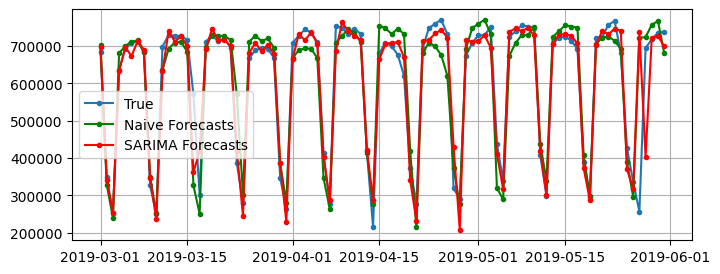

In [19]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(rail_series.loc[transit_test_period].index,
        rail_series.loc[transit_test_period].values,
        marker=".", label="True")

ax.plot(y_preds_naive.index,
        y_preds_naive.values,
        color="green", marker=".", label="Naive Forecasts")   

ax.plot(y_preds_sarima.index,
        y_preds_sarima.values,
        color="r", marker=".", label="SARIMA Forecasts")

ax.grid(True)
ax.legend()
plt.show()

The plot shows that both models capture the strong weekly seasonality, but the SARIMA forecasts track the true series more closely than the naive baseline, especially around weekday peaks and weekend drops, resulting in a consistently lower average error.

### Beyond Linear Models

SARIMA performs well on the ridership dataset because the underlying signal is dominated by a single strong seasonality and smooth, **stationary dynamics**. To illustrate where statistical models begin to struggle, we consider a more challenging engineering problem: household electrical power consumption. The [UCI Individual Household Electric Power Consumption dataset](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption) records minute-by-minute active power, voltage, and current from a single household over four years, along with sub-metered readings for individual appliance groups. Unlike the ridership series, this signal exhibits **multiple overlapping periodicities** (daily, weekly, seasonal), **sudden spikes** driven by appliance switching, and **nonlinear interactions between variables**. These characteristics fall outside the linear, univariate assumptions of ARIMA-family models, which cannot jointly model multiple input channels or adapt to abrupt regime changes. First of all, we need to load the dataset, which is provided as a large ZIP file containing a single CSV:

In [20]:
# Define the URL of the dataset
url = "https://www.dropbox.com/scl/fi/wsbl8xj7d8tx2vjmn92l0/household-electric-power-consumption.zip?rlkey=ai9e3u24hg9sgou39340cn3l4&dl=1"

# Create data directory if it does not exist
os.makedirs("./data", exist_ok=True)

# Prepare data if not already existing 
if not os.path.exists("./data/household-electric-power-consumption.zip"):
   print("Downloading dataset...")

   # Download the dataset
   u = urllib.request.urlopen(url)
   data = u.read()
   u.close()

   # Save the dataset to a local file
   with open("./data/household-electric-power-consumption.zip", "wb") as f :
      f.write(data)

   # Extract the dataset
   with zipfile.ZipFile("./data/household-electric-power-consumption.zip","r") as zip_ref:
      zip_ref.extractall("./data")
    
else:
   print("Dataset already exists. Skipping download.")

Dataset already exists. Skipping download.


We will read the data, handle missing values, and prepare it for modeling:

In [21]:
# Load the household power consumption dataset
power = pd.read_csv("./data/household_power_consumption.txt", 
                     sep=";", 
                     na_values="?")

# Combine Date and Time columns into a single datetime index
power["datetime"] = pd.to_datetime(power["Date"] + " " + power["Time"], 
                                    dayfirst=True)
power = power.drop(columns=["Date", "Time"]).set_index("datetime")

# Resample to hourly mean (minute-level is too fine for SARIMA)
power_hourly = power.resample("h").mean()

# Interpolate missing values 
power_hourly = power_hourly.interpolate(method="linear")

# Display the shape and first rows concentrating on the
# global active power signal
power_hourly_gap = power_hourly["Global_active_power"]
print(f"Hourly series: {len(power_hourly_gap)} observations")
print(f"From {power_hourly_gap.index[0]} to {power_hourly_gap.index[-1]}")
power_hourly_gap.head(10)

Hourly series: 34589 observations
From 2006-12-16 17:00:00 to 2010-11-26 21:00:00


datetime
2006-12-16 17:00:00    4.222889
2006-12-16 18:00:00    3.632200
2006-12-16 19:00:00    3.400233
2006-12-16 20:00:00    3.268567
2006-12-16 21:00:00    3.056467
2006-12-16 22:00:00    2.200133
2006-12-16 23:00:00    2.061600
2006-12-17 00:00:00    1.882467
2006-12-17 01:00:00    3.349400
2006-12-17 02:00:00    1.587267
Freq: h, Name: Global_active_power, dtype: float64

The hourly global active power series reveals a complex signal with daily cycles, weekly modulation, strong seasonal variation, and frequent irregular spikes caused by appliance usage:

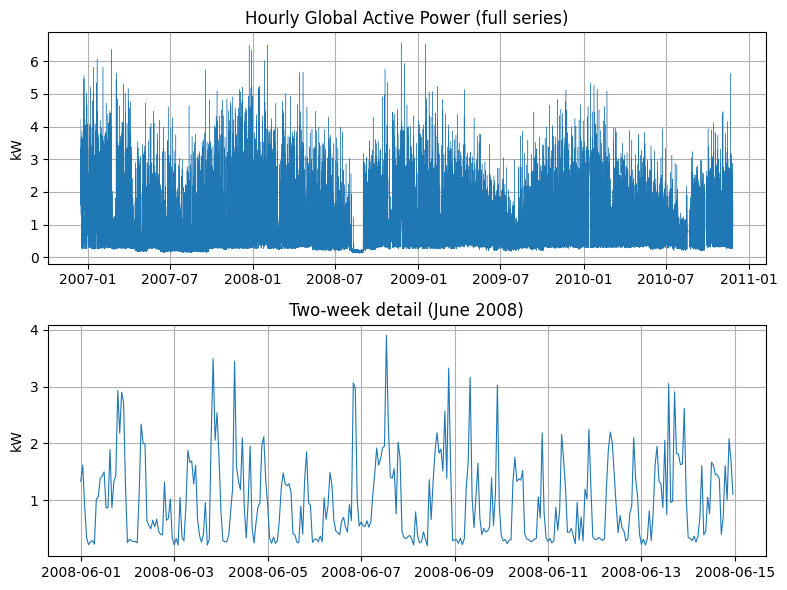

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Full series
ax = axes[0]
ax.plot(power_hourly_gap, linewidth=0.3)
ax.set_title("Hourly Global Active Power (full series)")
ax.set_ylabel("kW")
ax.grid(True)

# Zoom into two weeks to show daily pattern and spikes
two_weeks = power_hourly_gap["2008-06-01":"2008-06-14"]
ax = axes[1]
ax.plot(two_weeks, linewidth=0.8)
ax.set_title("Two-week detail (June 2008)")
ax.set_ylabel("kW")
ax.grid(True)

plt.tight_layout()
plt.show()

We now attempt to forecast this series using a SARIMA model with daily seasonality. We train on data up to the end of 2009 and evaluate one-step-ahead forecasts over a two-week test period in January 2010:

In [23]:
# Define training and test periods
power_train_end_date = "2009-12-31"
power_test_start_date = "2010-01-01"
power_test_end_date = "2010-01-12"

# Training series
power_train = power_hourly_gap[:power_train_end_date]

# Test period
power_test_period = pd.date_range(power_test_start_date, power_test_end_date, freq="h")

# Ground truth for the test period
power_test = power_hourly_gap[power_test_start_date:power_test_end_date]

# SARIMA parameters: daily seasonality (s=24)
order = (1, 0, 0)
seasonal_order = (0, 1, 1, 24)

# Fit SARIMA on training data 
sarima_power = ARIMA(power_train, 
                     order=order, 
                     seasonal_order=seasonal_order).fit()

# Generate one-step-ahead forecasts over the test period
y_preds_sarima_power = sarima_power.forecast(steps=len(power_test_period))
y_preds_sarima_power.index = power_test_period

# Compute MAPE (excluding near-zero values to avoid division issues)
mape_sarima_power = ((y_preds_sarima_power - power_test) / power_test).abs().mean()

print(f"SARIMA MAPE: {mape_sarima_power:.2%}")

SARIMA MAPE: 75.54%


We can now visualize the SARIMA forecasts alongside the actual power consumption:

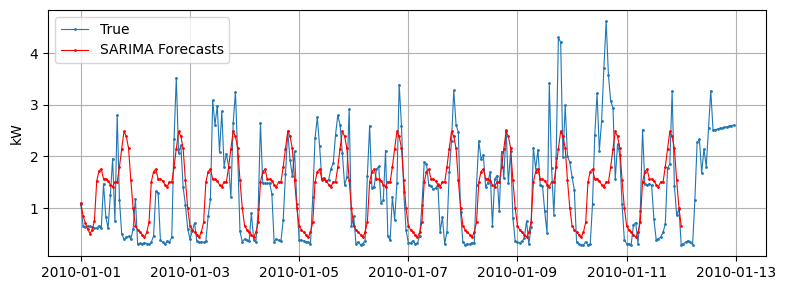

In [24]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(power_test.index, power_test.values, 
        marker=".", markersize=2, label="True", linewidth=0.8)

ax.plot(y_preds_sarima_power.index, y_preds_sarima_power.values, 
        color="red", marker=".", markersize=2, label="SARIMA Forecasts", linewidth=0.8)

ax.set_ylabel("kW")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

The SARIMA model captures the broad daily periodicity but fails to track the sharp intra-day fluctuations and irregular consumption spikes that dominate this signal. The forecast smooths over exactly the features that matter most for accurate prediction. This is a structural limitation: a linear model with fixed seasonal coefficients cannot represent the nonlinear, state-dependent dynamics of appliance-driven electricity consumption. In the following sections, we will develop recurrent neural network architectures capable of learning these richer patterns directly from data, without relying on strong assumptions about the underlying temporal structure.

## Recurrent Neural Network (RNN)

In a feedforward neural network, information flows strictly in one direction, from the input layer to the output layer. **Predictions are made independently**, without any memory of past inputs. This makes feedforward networks poorly suited for time series, where the current value often depends on what happened before. A **Recurrent Neural Network (RNN)** addresses this limitation by introducing **feedback connections**: the network feeds part of its output back into itself. This creates an internal **state** that acts as a memory, allowing the model to carry information forward in time.

### Recurrent Neuron

We begin with the simplest possible recurrent neural network: a single recurrent neuron. Unlike a standard feedforward neuron, which processes each input independently, a recurrent neuron maintains **an internal state that evolves over time**. This internal state allows the neuron to **retain information about past inputs** and to use it when processing new data:

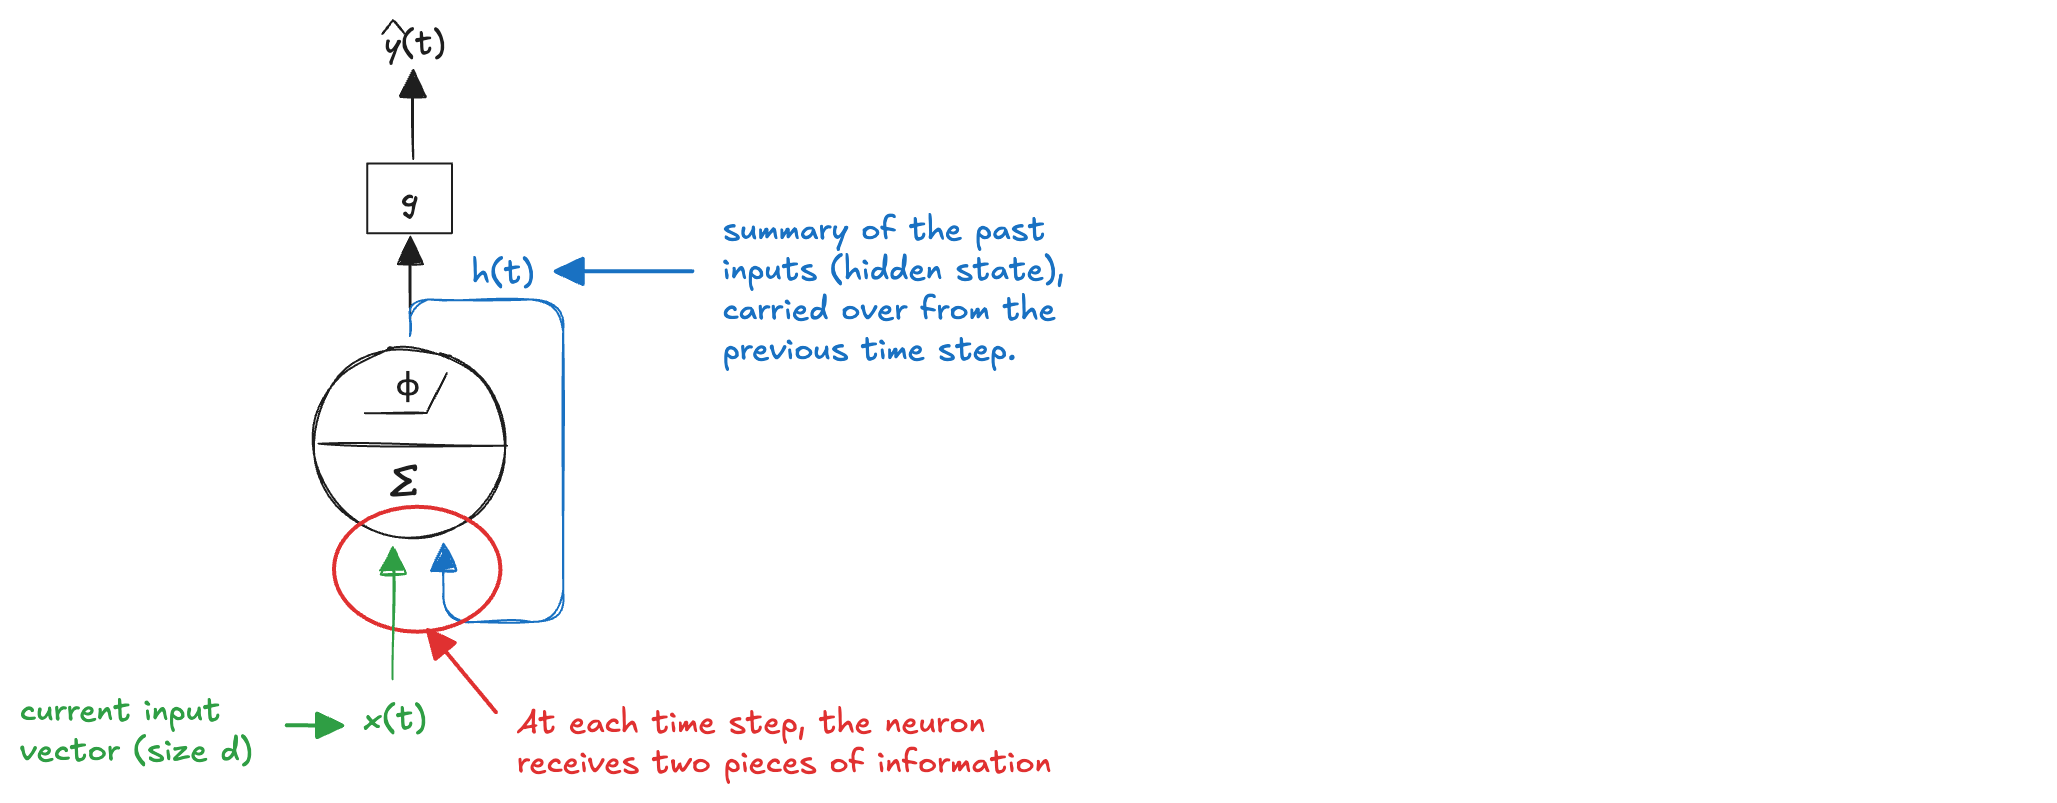

At each time step t, the neuron receives two sources of information. The first is the current input vector:

$\displaystyle x(t) \in \mathbb{R}^d$ 

The second is the hidden state: 

$\displaystyle h(t-1) \in \mathbb{R}$ 

which is carried over from the previous time step and acts as a **learned summary of the past inputs**. These two signals are combined to produce a new hidden state h(t), which is then fed back into the neuron and becomes part of the input at the next time step.

Because the hidden state is scalar in this setting, the neuron has two distinct sets of parameters: an input weight vector: 

$\displaystyle w_x \in \mathbb{R}^d$ 

which processes the current input, and a recurrent weight 

$\displaystyle w_h \in \mathbb{R}$

which controls how strongly past information influences the present. A bias term 

$\displaystyle b \in \mathbb{R}$ 

is also included. The state update equation is therefore:

$\displaystyle h(t) = \phi\!\left(w_x^\top x(t) + w_h\,h(t-1) + b\right)$

where $\phi(\cdot)$ is a nonlinear activation function, such as ReLU. To fully define the recurrence, an initial hidden state must be specified, and is typically set to zero or treated as a learnable parameter.

The output of the neuron at time t is obtained by applying an output function g()) to the hidden state:

$\displaystyle \hat y(t) = g\!\left(h(t)\right)$

This simple recurrent neuron already captures the key idea behind recurrent neural networks: **information flows not only forward from input to output, but also through time, allowing the model to build and update an internal memory as new data arrive**.

For example, in the context of daily ridership data, the hidden state can be interpreted as a compact summary of past travel patterns (weekly seasonality) which is then combined with the current day’s observation to produce a prediction for the next day’s ridership. We can implement this idea in Python:

In [25]:
import numpy as np

# Phi activation function (ReLU)
def phi(z): 
    return np.maximum(0.0, z)

# g output function (identity)
def g(h):
    return h   

def rnn_cell(x_t, h_prev, w_x, w_h, b):
    
    # Compute the linear combination of inputs and previous hidden state
    z = w_x @ x_t + w_h * h_prev + b

    # Apply activation function
    h_t = phi(z)

    # Compute output
    y_t = g(h_t)

    # Return the new hidden state and output
    return h_t, y_t

The recurrent neuron maintains an **internal state** that acts as a **compact memory** of the input sequence, enabling the network to retain, update, and exploit **information about the past**. As a result, observations are not processed in isolation: the model explicitly captures temporal dependencies, which makes it particularly well suited for sequential and time-series data. In this sense, the hidden state functions as a learned representation of past information that is continuously updated over time.

To better understand how this mechanism works, we can **conceptually unroll the recurrent connection along the time axis**. Consider an input sequence of length T, indexed by time steps t=0,1,...,T-1. At each time step, the recurrent neuron receives both the current input x(t) and its own hidden state h(t-1) from the previous time step. Since no past state exists at the initial time step t=0, the hidden state is typically initialized to zero.

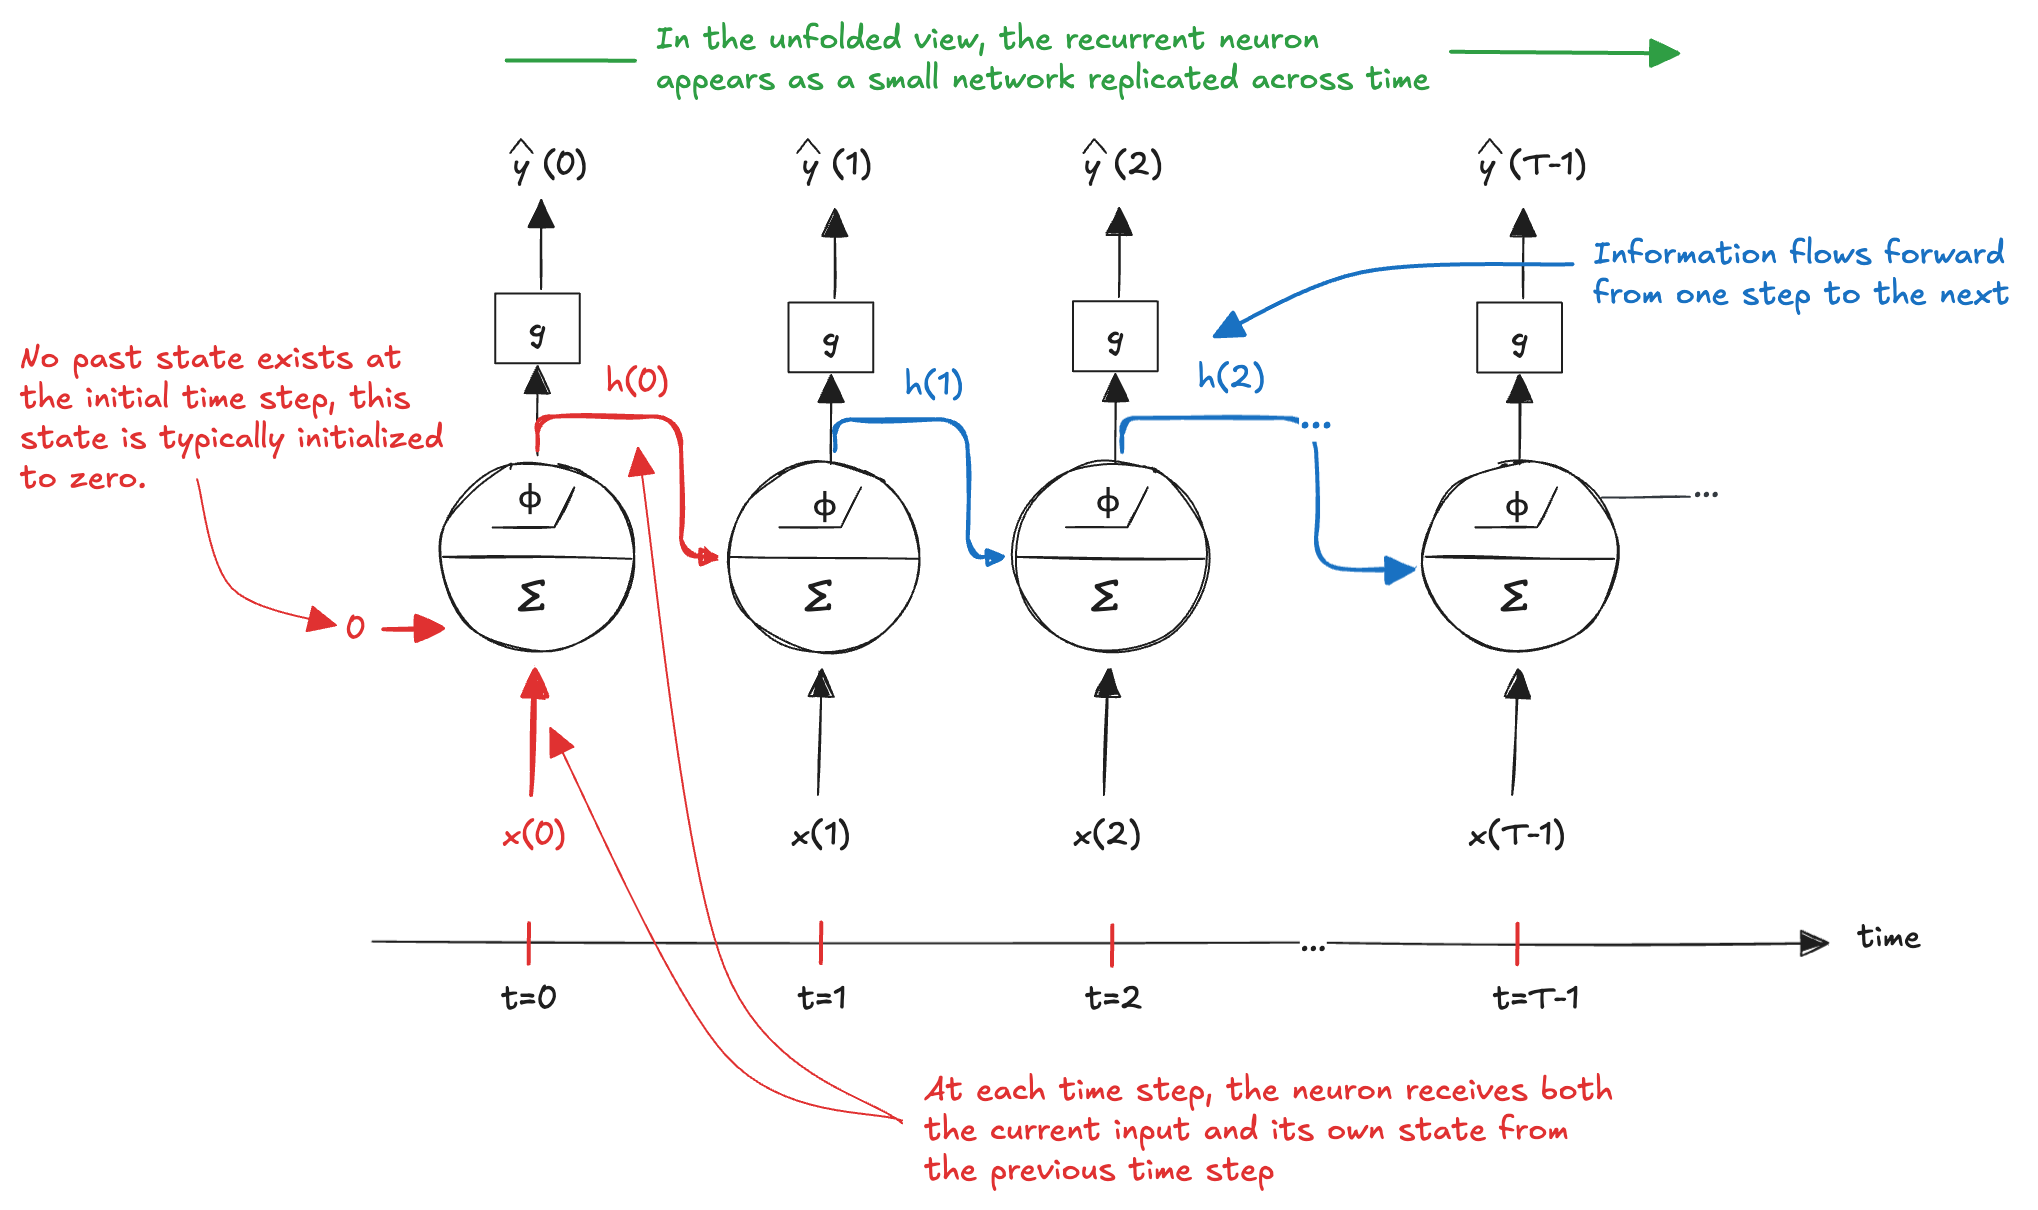

In this **unfolded view**, the recurrent neuron appears as **a small network replicated across time, with the same parameters shared at every step**. This representation, known as **unrolling** the network through time, makes explicit how information flows forward from one time step to the next and how the hidden state evolves over the entire sequence of length T We can unroll the previous Python implementation as follows:

In [26]:
def rnn_cell_unroll(X, w_x, w_h, b):
    
    # Get the number of time steps
    T = len(X)

    # Initialize the hidden state for the first time step
    h = 0.0

    # Lists to store hidden states and outputs
    H = []
    Y_hat = []

    # Unroll the RNN over time steps
    for t in range(T):
        
        # Compute the new hidden state and output
        h, y = rnn_cell(X[t], h, w_x, w_h, b)
        
        # Append to the lists
        H.append(h)
        Y_hat.append(y)

    # return the arrays of hidden states and outputs
    return np.array(H), np.array(Y_hat)

### Recurrent Layer

A single recurrent neuron has very limited representational power. For this reason, practical recurrent neural networks use not just one recurrent neuron, but a **layer of recurrent neurons operating in parallel**. The layer consists of m recurrent neurons, all processing the **same input sequence**: 

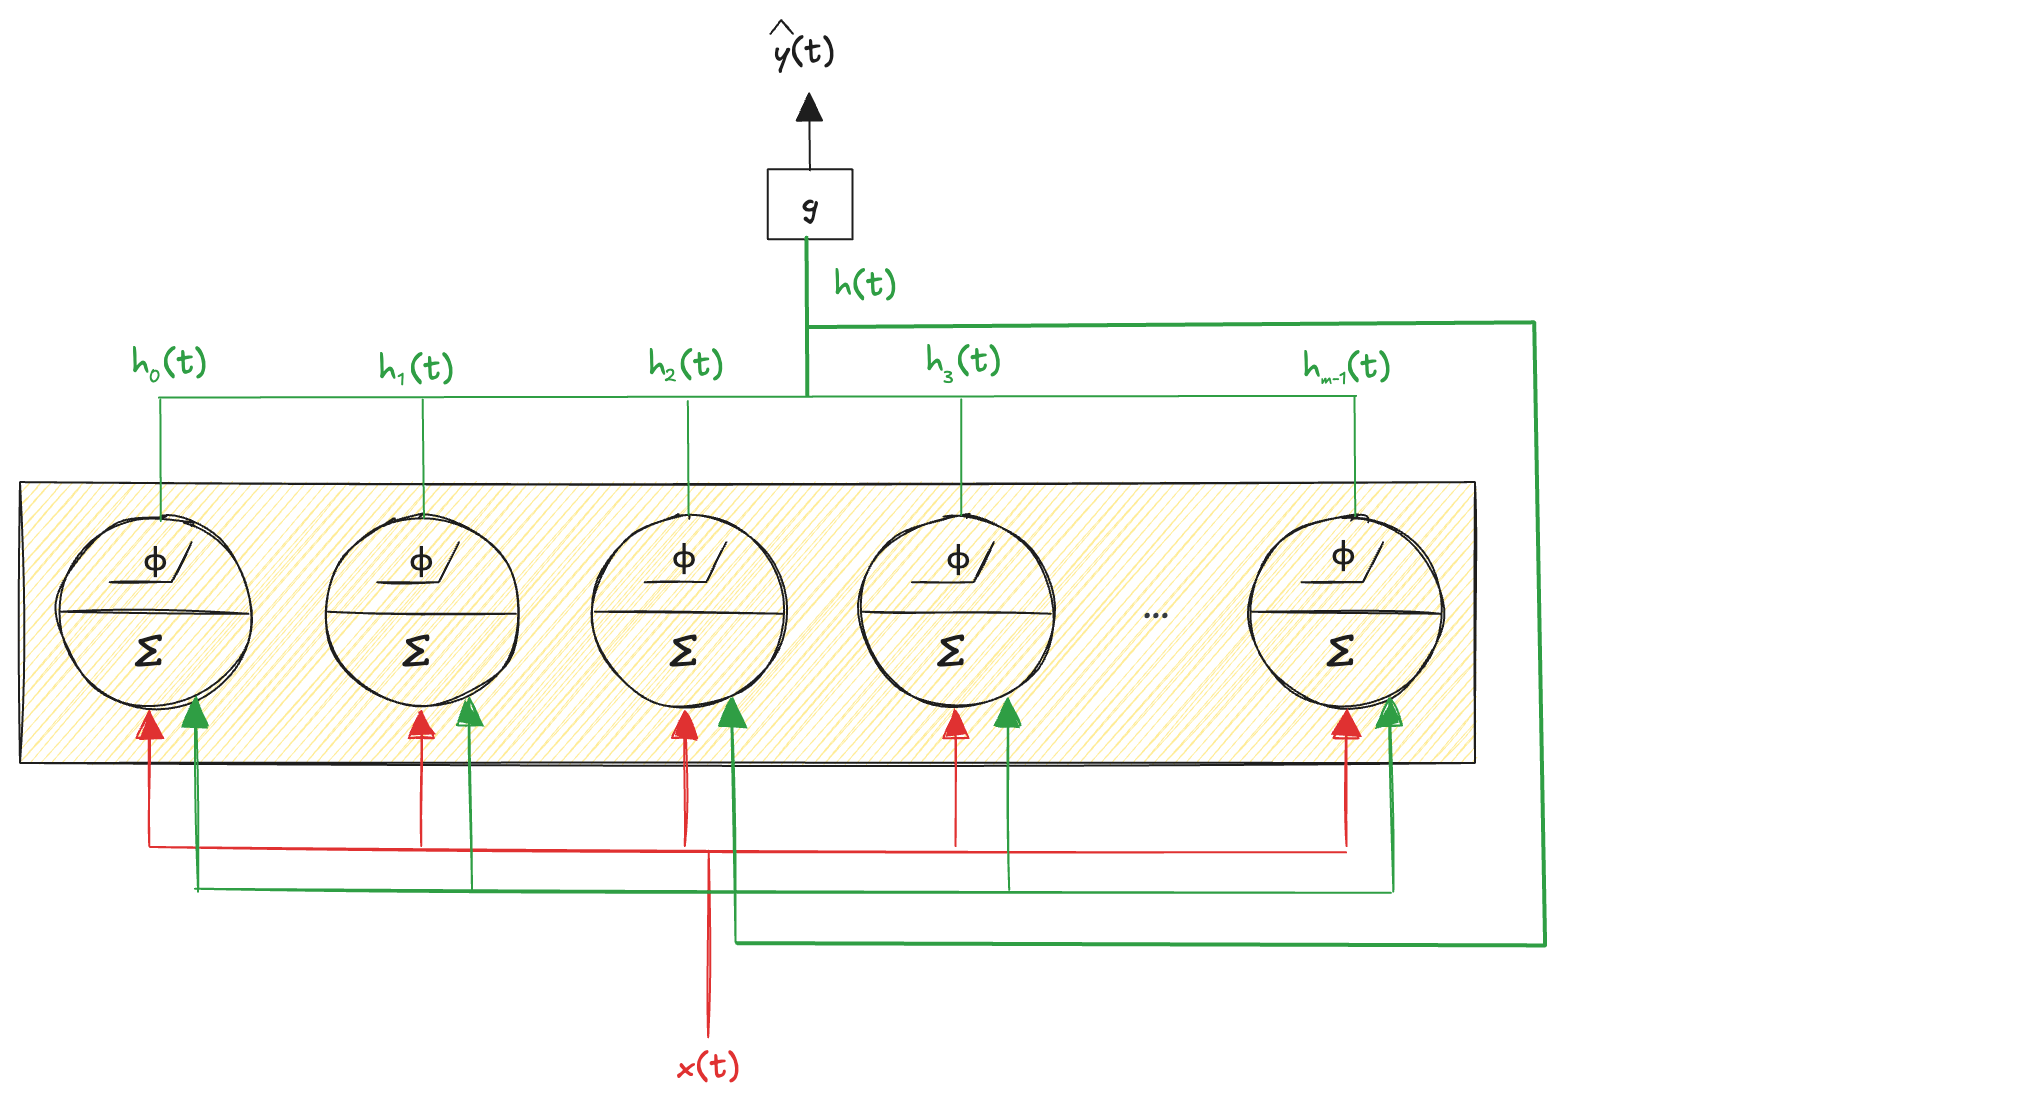

At each time step t, the input vector x(t) is provided simultaneously to all neurons in the layer. Each neuron maintains its own hidden activation, and together these activations form the hidden state vector:

$\displaystyle h(t) = \big[h_0(t), h_1(t), \ldots, h_{m-1}(t)\big]^\top \in \mathbb{R}^m$

Each neuron combines the shared input with the **entire hidden state vector from the previous time step**, not just with its own past activation. As a result, every neuron has its own input weight vector and its own recurrent weight vector:

$\displaystyle h_i(t) = \phi\!\left(w_{x,i}^\top x(t) + w_{h,i}^\top h(t-1) + b_i \right)$

where: 

$\displaystyle w_{x,i}\in\mathbb{R}^d$

$\displaystyle w_{h,i}\in\mathbb{R}^m$

$\displaystyle b_i\in\mathbb{R}$

This formulation shows that the hidden state represents a **distributed memory**: information about the past is not stored in a single unit, but is spread across multiple neurons, each capturing different aspects of the temporal structure (such as trends, periodic patterns, or short-term fluctuations).

The output at time t is obtained by applying a mapping function g to the entire hidden state vector:

$\displaystyle \hat y(t) = g\big(h(t)\big)$

rather than to individual hidden units.

In practice, as for feedforward networks, recurrent neural networks are almost always trained using **mini-batches**, rather than processing a single sequence at a time. Thus, instead of working with a single input sequence:

$\displaystyle x(0), x(1), \ldots, x(T-1)$

we work with a mini-batch of B sequences, each of length T:

$\displaystyle x^{(1)}(0), \ldots, x^{(1)}(T-1)$    
$\displaystyle x^{(2)}(0), \ldots, x^{(2)}(T-1)$    
$\displaystyle \quad \ldots \quad$  
$\displaystyle x^{(B)}(0), \ldots, x^{(B)}(T-1)$

At a fixed time step t, the input to the recurrent layer can be represented as a matrix

$\displaystyle X(t) = \begin{bmatrix} x^{(1)}(t) \\
                                      x^{(2)}(t) \\
                                      \vdots \\
                                      x^{(B)}(t)
                      \end{bmatrix}
\in \mathbb{R}^{B\times d}$

where each row corresponds to the input vector of one sequence at time t. Importantly, X(t) **does not represent a sequence by itself**; the **temporal structure arises from the ordered collection of such matrices over time**. Similarly, the hidden state at time t is represented as

$\displaystyle H(t) = \begin{bmatrix} h^{(1)}(t) \\
                                      h^{(2)}(t) \\
                                      \vdots \\
                                      h^{(B)}(t)
                       \end{bmatrix}
\in \mathbb{R}^{B\times m}$

where each row is the hidden state of one sequence, and m is the hidden dimension of the recurrent layer.

At each time step, each sequence in the mini-batch **evolves independently**, but all sequences **share the same parameters**. For the b-th sequence in the mini-batch, the hidden state update is given by:

$\displaystyle h^{(b)}(t) = \phi\!\left(W_x\,x^{(b)}(t) + W_h\,h^{(b)}(t-1) + b\right), \qquad b = 1,\ldots,B$

Explicitly, this corresponds to

$\displaystyle \begin{aligned}
h^{(1)}(t) &= \phi\!\left(W_x x^{(1)}(t) + W_h h^{(1)}(t-1) + b\right),\\
h^{(2)}(t) &= \phi\!\left(W_x x^{(2)}(t) + W_h h^{(2)}(t-1) + b\right),\\
&\;\;\vdots\\
h^{(B)}(t) &= \phi\!\left(W_x x^{(B)}(t) + W_h h^{(B)}(t-1) + b\right).
\end{aligned}$

Stacking these equations for all sequences in the mini-batch leads to the vectorized formulation:

$\displaystyle H(t) = \phi\!\big(X(t)W_x + H(t-1)W_h + b\big)$

where 

$\displaystyle W_x\in\mathbb{R}^{d\times m}$    
$\displaystyle W_h\in\mathbb{R}^{m\times m}$    
$\displaystyle b\in\mathbb{R}^m$

At each time step, the recurrent layer produces an output vector for each sequence in the mini-batch. If the output dimension is O, we can write:

$\displaystyle \hat Y(t) = \begin{bmatrix} \hat y^{(1)}(t) \\ \hat y^{(2)}(t) \\ \vdots \\ \hat y^{(B)}(t) \end{bmatrix} \in \mathbb{R}^{B\times O}$

The output is obtained by applying an output mapping to the hidden states:

$\displaystyle \hat Y(t) = g\!\big(H(t)\big)$

In the simplest and most common case, g() is an affine transformation applied row-wise:

$\displaystyle \hat Y(t) = H(t) W_y + b_y$

where

$\displaystyle W_y \in \mathbb{R}^{m\times O}$

$\displaystyle b_y \in \mathbb{R}^{O}$

The same weight matrices are shared across all sequences in the mini-batch and across all time steps, ensuring that the model learns a single, consistent temporal transformation. Mini-batch processing significantly **improves computational efficiency** and **stabilizes training**, while fully preserving the temporal dynamics learned by the recurrent layer.

We can descrive this recurrent layer in Python as follows:

In [27]:
import numpy as np

def init_rnn_layer(input_dim, hidden_dim, output_dim):
    
    params = {
        # Input weights:
        "W_x": np.random.normal(0.0, 0.1, size=(input_dim, hidden_dim)),

        # Recurrent weights:
        "W_h": np.random.normal(0.0, 0.1, size=(hidden_dim, hidden_dim)),

        # Bias for each recurrent neuron
        "b": np.zeros(hidden_dim),

        # Output weights:
        "W_y": np.random.normal(0.0, 0.1, size=(hidden_dim, output_dim)),

        # Output bias
        "b_y": np.zeros(output_dim)
    }

    return params

As with a single recurrent neuron, a recurrent layer can be **unrolled through time**. Each block represents the same recurrent layer evaluated at a different time step, with **shared parameters** across all copies. At time t, the layer receives the current input and the hidden state from the previous step, and produces a new hidden state and an output:

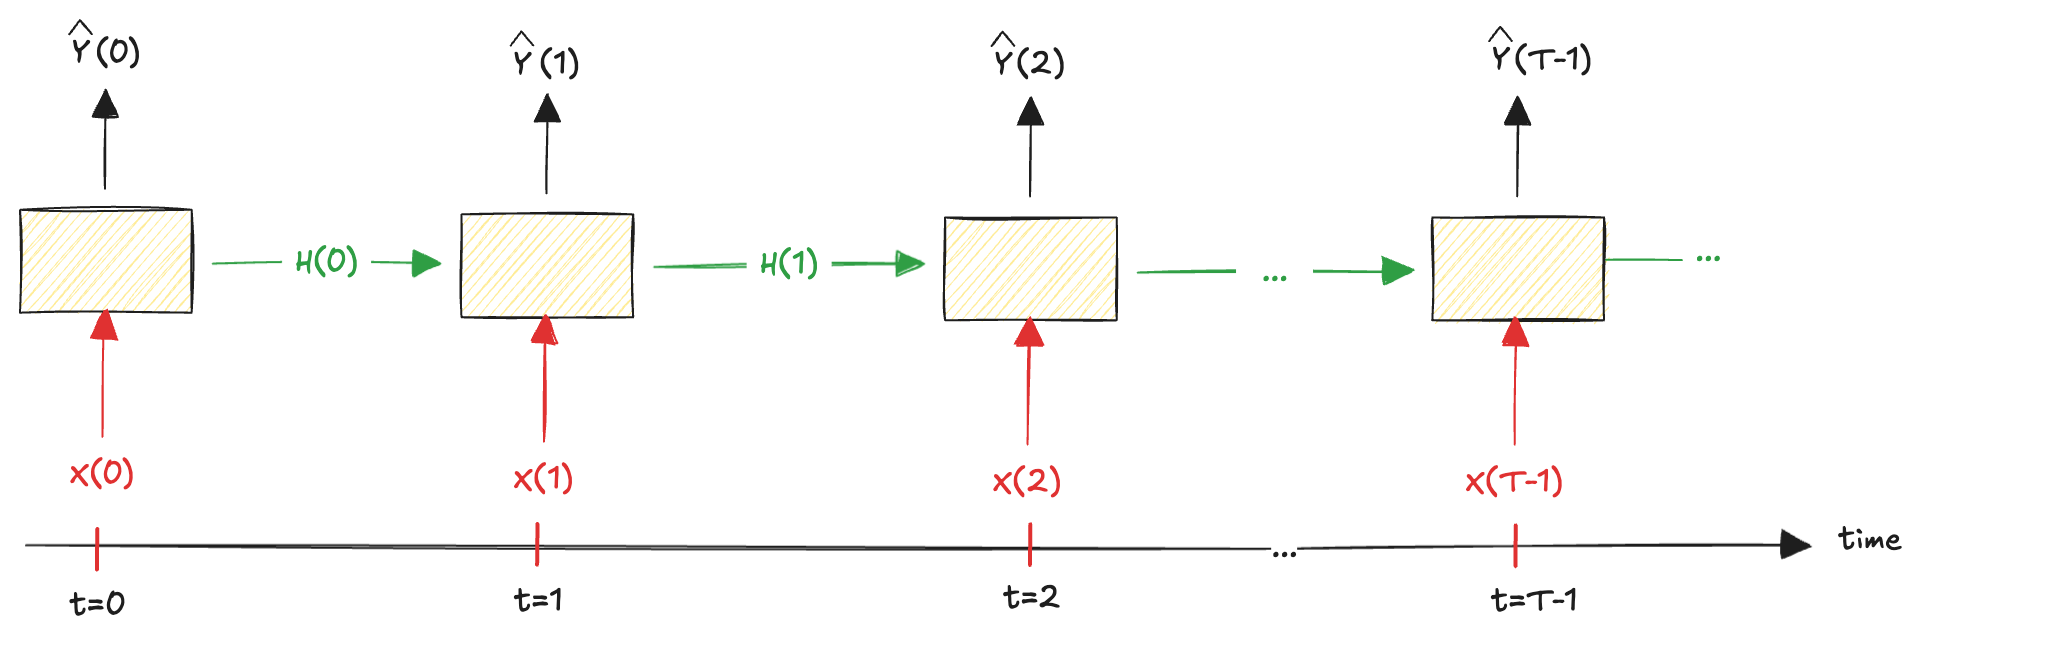

The same layer (with the same parameters) is replicated at each time step. This makes explicit how the hidden state evolves and how information flows forward in time, while emphasizing a crucial property of recurrent networks: **parameter sharing across time**. The weight matrices and the bias are reused at every time step, allowing the model to process sequences of arbitrary length with a fixed number of parameters.

### Recurrent Architectures

An RNN can process an entire sequence and produce a **corresponding sequence of outputs**. This architecture is known as a **sequence-to-sequence network**:

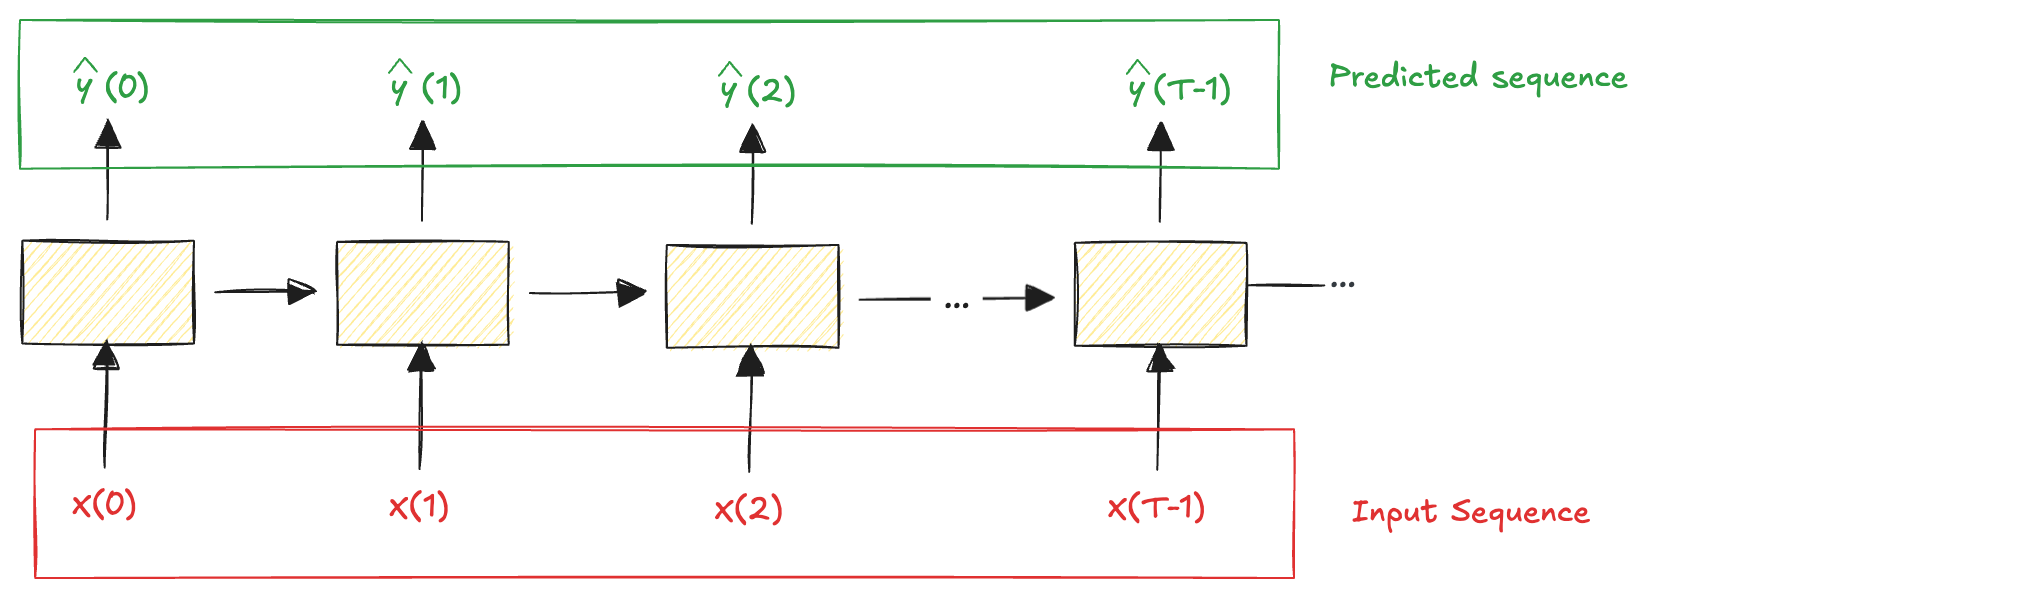

For example, the input consists of the last T observed values of household power consumption, and train it to predict the same sequence shifted **one day into the future**, effectively learning to forecast the next day’s consumption at each time step.

Alternatively, we can feed the network a **sequence of inputs** and use **only the final output**, obtaining a **sequence-to-vector** architecture: 

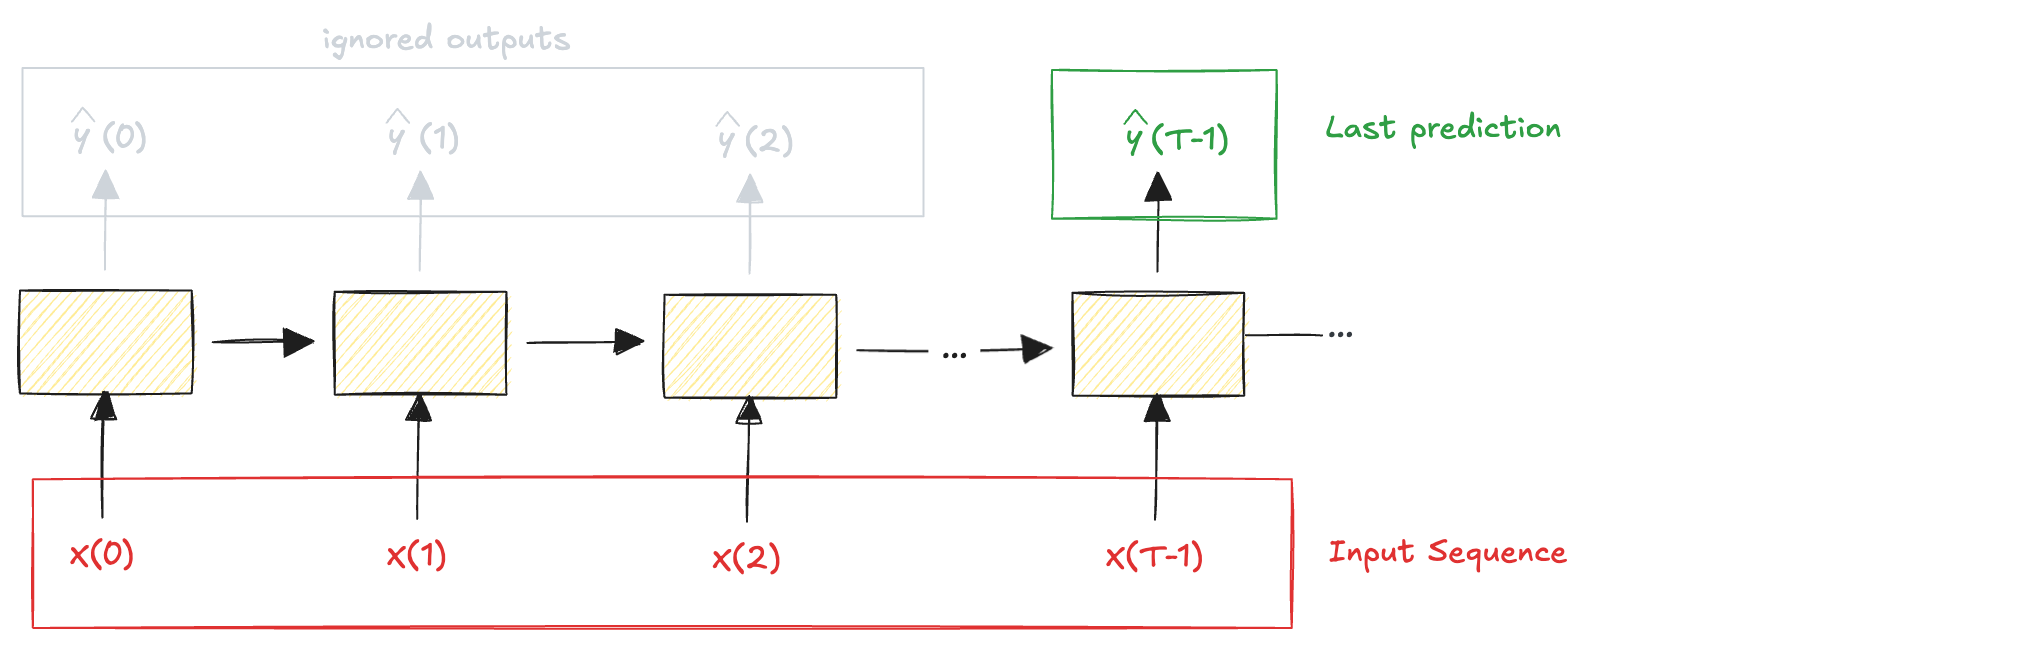

In this case, the network compresses the entire input sequence into a single representation, which can then be used for tasks such classification. For example, we can input a sequence of words forming a movie review and have the network output a single sentiment score summarizing the overall opinion expressed in the text.

Although both architectures can be used to predict values one step into the future, **they differ in how supervision is applied**. In a sequence-to-sequence model, the network is trained to make accurate predictions at every time step, whereas in a sequence-to-vector model only the final prediction is supervised. As a result, sequence-to-sequence training provides a denser learning signal and encourages accurate intermediate predictions, while sequence-to-vector training forces the network to compress the entire sequence into a single representation optimized for the final output. The use case for sequence-to-sequence models is typically forecasting tasks, while sequence-to-vector models are often employed for classification or regression tasks based on sequential data.

We can also provide the network with a **single input vector** and reuse it at every time step, allowing the network to generate a **sequence of outputs**. This architecture is known as a **vector-to-sequence** network: 

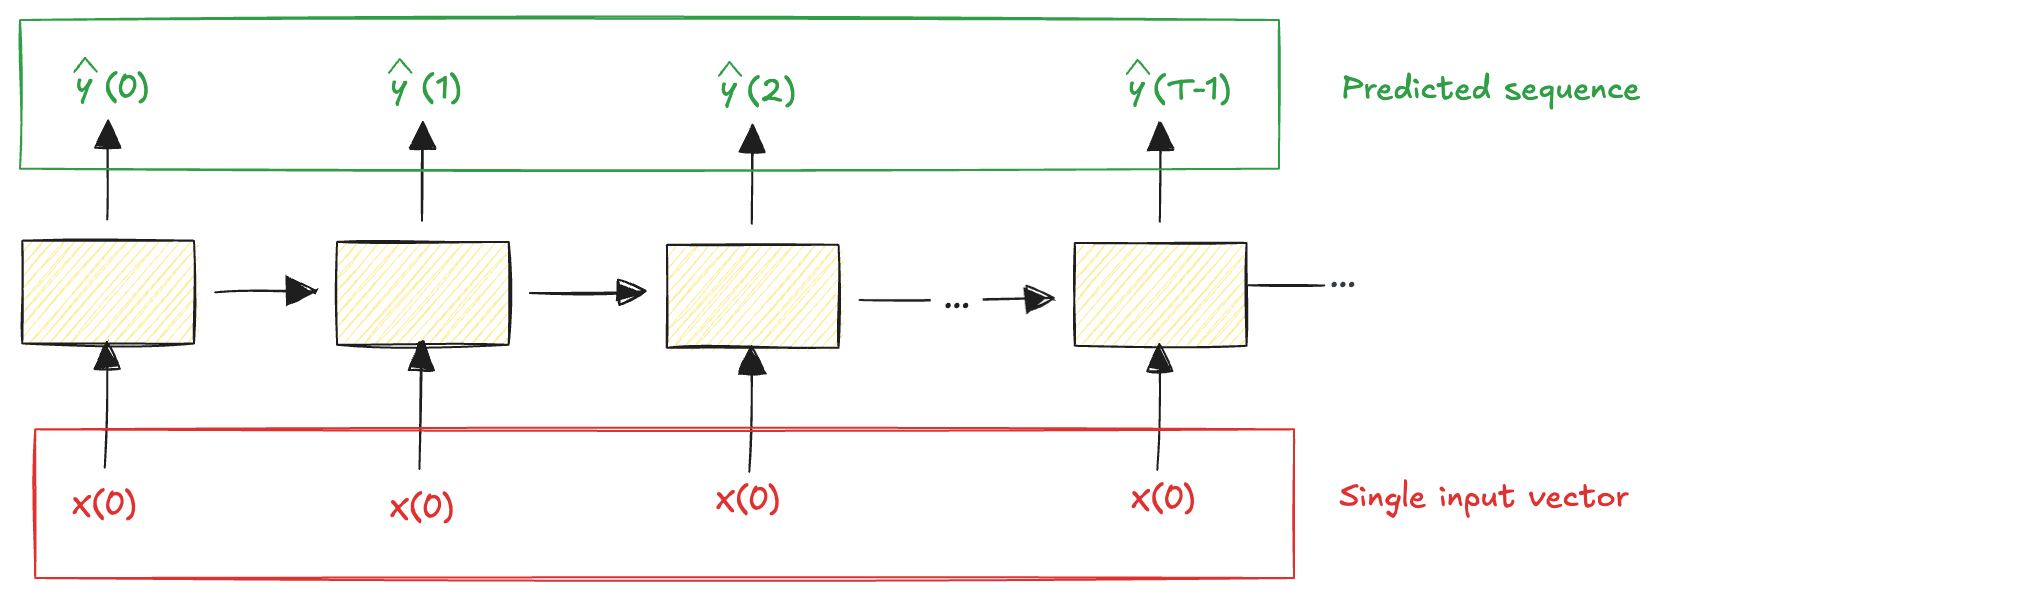

In this setting, the same input vector is provided to the recurrent layer at each time step, while the hidden state evolves over time and produces a sequence of outputs. Alternatively, the input vector can be used to initialize the hidden state, with subsequent outputs generated purely through the recurrent dynamics; both formulations are commonly used in practice.

A common example is image captioning, where an image (or a feature vector extracted by a convolutional neural network) is given as input, and the recurrent network generates a sequence of words describing the image.

Lastly, we can consider an architecture composed of a sequence-to-vector network, called an **encoder**, followed by a vector-to-sequence network, called a **decoder**. This **encoder–decoder structure** allows the model to transform an input sequence into an output sequence of potentially different length.

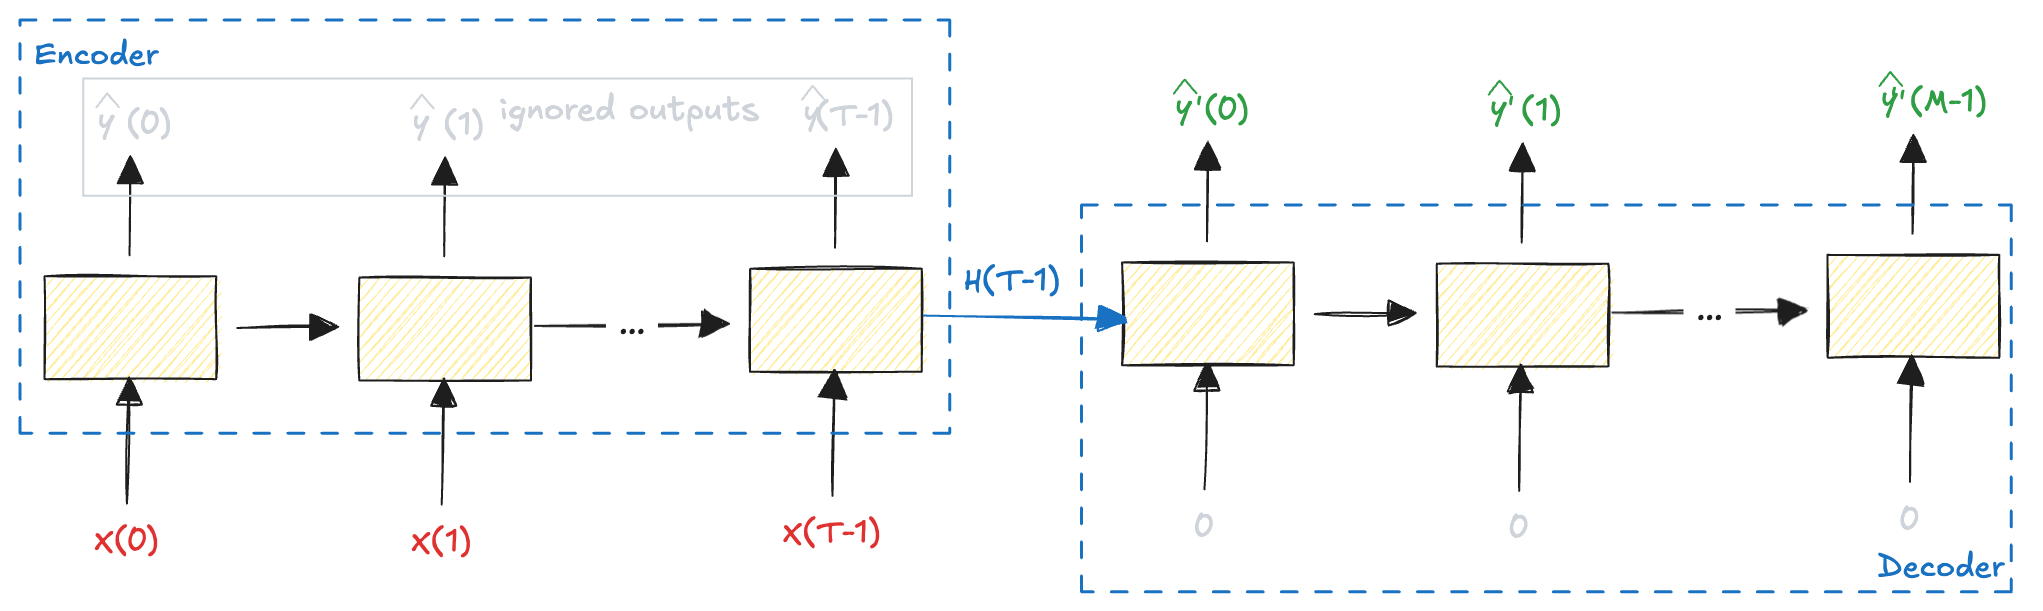

The encoder processes the input sequence and compresses it into a single vector representation, given by its final hidden state. Intermediate encoder outputs are ignored. The final encoder hidden state is then used to initialize the hidden state of the decoder. The decoder generates an output sequence, one element at a time, using the encoded representation and its own recurrent dynamics. In practice, the decoder may also receive previous output tokens as inputs (**teacher forcing**). For example, this architecture can be used for translating a sentence from one language to another. We feed the network a sentence in one language, the encoder converts it into a single vector representation, and then the decoder decodes the vector into a sentence in another language.

### Backpropagation Through Time

When working with sequential data, each prediction produced by a recurrent neural network depends not only on the current input, but also on the internal state built from all previous inputs. An intuitive way to think about this is to view the hidden state as a running summary of the past. If the network makes a poor prediction at time t, the problem may not lie only in the current input, but in how the hidden state was constructed at earlier time steps. Perhaps the network **failed to retain relevant information from the past**, or **assigned too much importance to irrelevant inputs**. In this sense, an error observed at time t **reveals that something went wrong earlier** in the sequence, when the hidden state was being built.

During training, we therefore want the network to **"learn from the future"**. When an error is observed at a later time step, we **propagate that error backward** through the sequence in order to adjust the parameters that were used at earlier steps. This allows the network to modify how it processes early inputs so that the hidden states they produce will be more useful for making accurate predictions later on.

[**Backpropagation Through Time (BPTT)**](./papers/(1990)%20-%20Backpropagation%20Through%20Time%20-%20What%20it%20does%20and%20how%20to%20do%20it.pdf) formalizes this intuition. By unrolling the network through time, we obtain a feedforward computation network in which the same parameters appear at each time step. As in any feedforward network, we can then apply the chain rule to compute gradients. However, because the parameters are shared across time, the gradient with respect to each parameter is obtained by **summing its contributions across all time steps** in the unrolled network. In this way, the error at later outputs can be traced back through all intermediate hidden states, assigning responsibility to earlier computations. The network thus learns not only to predict well at each step, but to **build internal representations that support accurate predictions in the future**. Given an input sequence:

$\displaystyle X(0), X(1), \ldots, X(T-1)$

the network performs a forward pass through the unrolled structure. At each time step, the hidden state is updated by combining the current input with the previous hidden state:

$\displaystyle H(t) = \phi\!\left(X(t) W_x + H(t-1) W_h + b\right), \qquad H(-1) = H_0$

From the hidden state, the network produces an output. Here we explicitly include an linear implementeation of the g() function, defined by an output weight matrix and bias term:

$\displaystyle \hat Y(t) = g(H(t)) = H(t) W_y + b_y$

As the sequence is processed, this forward pass produces a sequence of hidden states:

$\displaystyle H(0), H(1), \ldots, H(T-1)$

and a corresponding sequence of outputs

$\displaystyle \hat Y(0), \hat Y(1), \ldots, \hat Y(T-1)$

Here the implementation of the forward pass through time:

In [28]:
# Phi activation function (ReLU)
def phi(Z): 
    return np.maximum(0.0, Z) 
    
# g output function (linear)
def g(H, W_y, b_y):
    return H @ W_y + b_y

def rnn_layer_forward(X, params):

    # Get dimensions (T: time steps, B: batch size, D: input dimension)
    T, B, D = X.shape

    # Get hidden dimension
    hidden_dim = params["b"].shape[0]

    # Get output dimension
    output_dim = params["b_y"].shape[0]

    # Initialize hidden states
    H = np.zeros((T, B, hidden_dim))
   
    # Initialize outputs
    Y_hat = np.zeros((T, B, output_dim))

    # Set to zero the first previous hidden state
    H_prev = np.zeros((B, hidden_dim))

    # Unroll through time
    for t in range(T):

        # Update the hidden state
        H[t] = phi(X[t] @ params["W_x"] + H_prev @ params["W_h"] + params["b"])

        # Compute output
        Y_hat[t] = g(H[t], params["W_y"], params["b_y"])  

        # Update previous hidden state
        H_prev = H[t]

    # Return hidden states and outputs
    return H, Y_hat

The predictions produced by the recurrent network should be **evaluated using a loss function**. Let

$\displaystyle Y(0), Y(1), \ldots, Y(T-1)$

denote the **target sequence** associated with the input sequence. This sequence should represents **what we want the network to predict** at each time step. While the input sequence describes the information available to the model, the target sequence specifies the desired behavior of the model over time. In many problems, Y is naturally aligned with the input sequence. For example, in time-series forecasting, Y(t) may represent the future value of the signal relative to the input at time t. In a one-step-ahead forecasting task, this corresponds to

$\displaystyle Y(t) = X(t+1)$

so that each prediction is trained to anticipate what will happen next. More generally, Y can be interpreted as a **supervisory signal** that tells the network what information extracted from the past should be useful. Depending on the problem, the loss may involve all time steps (as in sequence-to-sequence problems) or only a subset of them (for example, only the final output in sequence-to-vector models). Let M denote the **number of time steps over which supervision is applied**. The training objective can then be written as:

$\displaystyle \mathcal{L} = \sum_{t=T-M}^{T-1} \ell\big(Y(t), \hat{Y}(t)\big)$

where $\ell()$ is the loss evaluated at each time step (for example, squared error for regression or cross-entropy for classification) and M is the number of supervised time steps. In the following figure, for example, the early part of the sequence is used to build up a meaningful hidden state, while only the later part of the sequence is used to evaluate prediction quality:

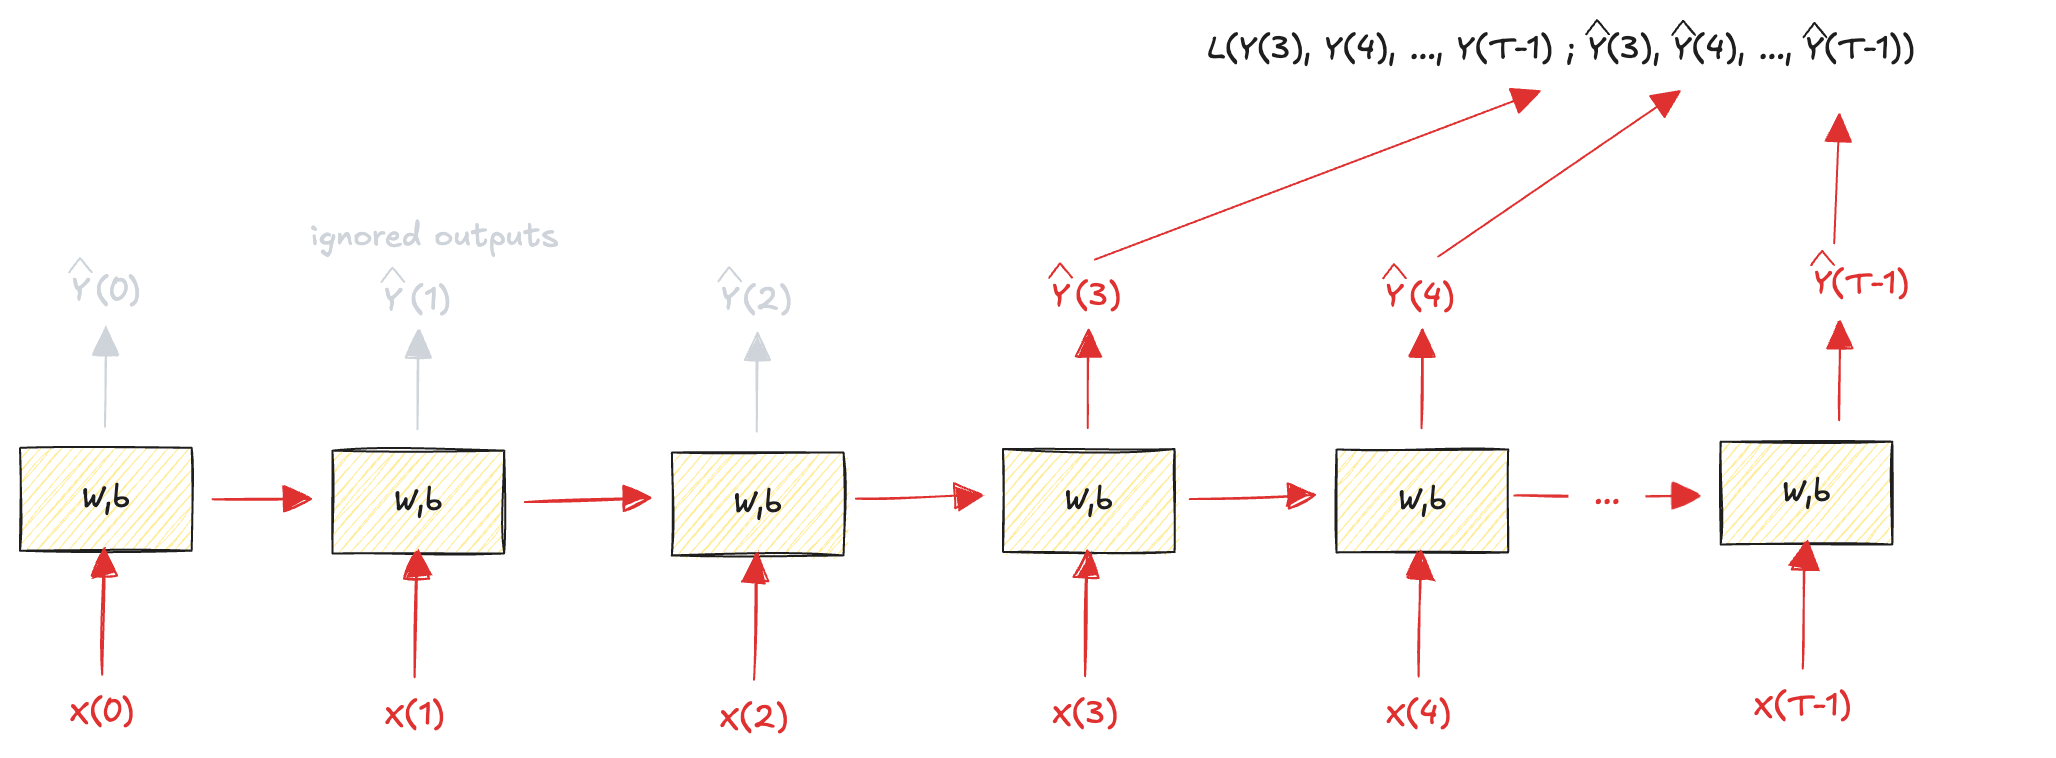

To make this concrete, consider a regression task where the loss at each time step is the **squared error** between the predicted and target outputs. Since the network operates on mini-batches of B sequences and produces an O-dimensional output at each time step, the total number of scalar prediction errors over the supervised part of the sequence is M*B*O. We define the training objective as the sum of squared errors accumulated over the supervised time steps, the sequences in the mini-batch, and the output components:

$\displaystyle \ell\big(Y(t), \hat{Y}(t)\big) = \sum_{b=1}^{B} \sum_{o=1}^{O} \big(\hat Y_{t,b,o} - Y_{t,b,o}\big)^2 = \|\hat Y(t) - Y(t)\|^2$

We can implement this loss computation in Python as follows:

In [29]:
def sse_loss(Y_hat, Y, M):
    T = Y_hat.shape[0]
    residual = Y_hat[T-M:T] - Y[T-M:T]
    return np.sum(residual ** 2)

To train the model, we now need analyze **how the loss accumulated over time depends on parameters that are reused at every time step**, requiring a form of backpropagation that operates across time. Because the same parameters are reused at every time step, the gradient of the total loss is obtained by summing its contributions across all supervised time steps:

$\displaystyle \frac{\partial \mathcal{L}}{\partial \omega} = \sum_{t=T-M}^{T-1}
\frac{\partial \ell\big(Y(t),\hat Y(t)\big)}{\partial \omega}$

Applying the chain rule at a given time step t, we obtain:

$\displaystyle \frac{\partial \ell\big(Y(t),\hat Y(t)\big)}{\partial \omega} =
\frac{\partial \ell\big(Y(t),\hat Y(t)\big)}{\partial \hat Y(t)} \frac{\partial \hat Y(t)}{\partial H(t)}
\frac{\partial H(t)}{\partial \omega}$

This expression makes explicit how the effect of a parameter on the loss at time t can be decomposed into three parts: how the loss depends on the output, how the output depends on the hidden state, and how the hidden state depends on the parameter.

The first term is the derivative of the loss with respect to the output, and it is quite simple in the case of the squared errors used here. Over the supervised portion of the sequence the derivative is:

$\displaystyle \frac{\partial \ell\big(Y(t), \hat{Y}(t)\big)}{\partial \hat Y(t)} = 2\big(\hat Y(t) - Y(t)\big)$

whereas for t<T-M the derivative is zero. This term represents the **error signal injected at the output layer** at time t.

The second term is the derivative of the output with respect to the hidden state. Given the affine output mapping defined earlier, this derivative is simply the output weight matrix:

$\displaystyle \frac{\partial \hat Y(t)}{\partial H(t)} = W_y$

The nontrivial term in this expression is the derivative of the hidden state with respect to the parameters:

$\displaystyle\frac{\partial H(t)}{\partial \omega}$

which captures how a parameter influences the internal state of the network. Unlike in feedforward networks, the hidden state is not a simple function of the parameters. Because of the recurrence:

$\displaystyle H(t)=\phi\!\left(X(t)W_x+H(t-1)W_h+b\right)$

The hidden state depends on the parameters both **directly** at time t (through their appearance in the affine transformation) and **indirectly** through the previous hidden state, which itself depend on th same parameters. To make this dependency explicit, it is convenient to introduce the pre-activation:

$\displaystyle Z(t) = X(t)W_x + H(t-1)W_h + b$

$\displaystyle H(t) = \phi\big(Z(t)\big)$

Now, applying the chain rule:

$\displaystyle \frac{\partial H(t)}{\partial \omega} = \frac{\partial H(t)}{\partial Z(t)} \frac{\partial Z(t)}{\partial \omega} + \frac{\partial H(t)}{\partial Z(t)} \frac{\partial Z(t)}{\partial H(t-1)} \frac{\partial H(t-1)}{\partial \omega} = ...$

The first term captures the **direct contribution** of the parameter at time t, while the second term captures the **indirect contribution propagated from the past** through the recurrent connection. By recursively applying this relation backward in time, the effect of an error observed at a later time step is propagated to all earlier time steps that contributed to the construction of the hidden state:

$\displaystyle ... = \frac{\partial H(t)}{\partial Z(t)} \frac{\partial Z(t)}{\partial \omega} + \frac{\partial H(t)}{\partial Z(t)} \frac{\partial Z(t)}{\partial H(t-1)} \left( \frac{\partial H(t-1)}{\partial Z(t-1)} \frac{\partial Z(t-1)}{\partial \omega} + \frac{\partial H(t-1)}{\partial Z(t-1)} \frac{\partial Z(t-1)}{\partial H(t-2)} \frac{\partial H(t-2)}{\partial \omega} \right) = ... $

This expression shows that the total effect of a parameter on the hidden state at time t is obtained by summing its contributions from all previous time steps, each weighted by how changes in the hidden state propagate forward through time. However this mathematical expression is impractical to compute. 

The key idea is rather than explicitly computing the derivative (which is cumbersome due to the temporal recursion), backpropagation proceeds by **propagating error signals backward** through the network. These signals measure **how sensitive the total loss is to intermediate variables** at each time step. We define the following error signals:

$\displaystyle \delta_Y(t)=\frac{\partial \mathcal{L}}{\partial \hat Y(t)} \;$

$\displaystyle \delta_H(t)=\frac{\partial \mathcal{L}}{\partial H(t)} \;$

$\displaystyle \delta_Z(t)=\frac{\partial \mathcal{L}}{\partial Z(t)}$

The first one is the **output error signal** and considering the sum of squared errors loss defined earlier, it is given by:

$\displaystyle \delta_Y(t) = \frac{\partial \mathcal{L}}{\partial \hat{Y}(t)} = 
2\big(\hat Y(t) - Y(t)\big)$

in t>=T-M and zero otherwise.

The second term is the **hidden-state error signal** and it receives two distinct contributions, which arise from the two different ways in which the hidden state influences the total loss. First, it **directly** affects the output at the same time step through the affine mapping:

$\displaystyle \hat Y(t) = H(t) W_y+b_y$

Applying the chain rule, this produces a contribution:

$\displaystyle \left.\frac{\partial \mathcal{L}}{\partial H(t)}\right|_{\text{output}} = \frac{\partial \mathcal{L}}{\partial \hat Y(t)} \frac{\partial \hat Y(t)}{\partial H(t)} = \delta_Y(t)W_y^\top$

Second, the hidden state also influences the loss **indirectly**, through its effect on all future hidden states. In particular, it appears in the pre-activation at the next time step:

$\displaystyle Z(t+1)=X(t+1)W_x+H(t)W_h+b$

and therefore affects the next hidden state and the chain rule yields the corresponding contribution:

$\displaystyle \left.\frac{\partial \mathcal{L}}{\partial H(t)}\right|_{\text{future}} = \frac{\partial \mathcal{L}}{\partial Z(t+1)} \frac{\partial Z(t+1)}{\partial H(t)} = \delta_Z(t+1)\, W_h^\top$

Combining the direct and indirect effects, the total hidden-state error signal becomes:

$\delta_H(t) = \delta_Y(t) W_y^\top + \delta_Z(t+1) W_h^\top$

which shows explicitly how errors are propagated from later to earlier time steps.

Finally, the error signal with respect to the pre-activation is obtained by propagating through the nonlinearity:

$\displaystyle \delta_Z(t) = \frac{\partial \mathcal{L}}{\partial Z(t)} =
\frac{\partial \mathcal{L}}{\partial H(t)} \;\frac{\partial H(t)}{\partial Z(t)} = \delta_H(t) \, \frac{\partial H(t)}{\partial Z(t)} = \delta_H(t) \, \frac{\partial \phi(Z(t))}{\partial Z(t)}$

Because the activation function is applied component-wise: 

$\displaystyle H_i(t) = \phi\!\big(Z_i(t)\big)$

the partial derivative is a diagonal matrix:

$\displaystyle \frac{\partial \phi(Z(t))}{\partial Z(t)} = \begin{bmatrix} \displaystyle \frac{\partial \phi\!\big(Z_1(t)\big)}{\partial Z_1(t)} & 0 & \cdots & 0\\[6pt] 0 & \displaystyle \frac{\partial \phi\!\big(Z_2(t)\big)}{\partial Z_2(t)} & \cdots & 0\\ \vdots & \vdots & \ddots & \vdots\\ 0 & 0 & \cdots & \displaystyle \frac{\partial \phi\!\big(Z_m(t)\big)}{\partial Z_m(t)}
\end{bmatrix}$

Thus, the pre-activation error signal can be computed by performing an element-wise multiplication (denoted by $\odot$) between the hidden-state error signal and the derivative of the activation function evaluated at the pre-activation:

$\displaystyle \delta_Z(t) = \delta_H(t)\odot \phi'(Z(t))$

In the particular case of the ReLU activation function, the derivative is given by:

$\displaystyle \phi'(z) = \begin{cases} 1 & z > 0 \\ 0 & z \leq 0 \end{cases}$

Putting everything together, we obtain the following backward recursion for t=T-1,T-2,...,0:

$\displaystyle \delta_Y(t) = \begin{cases} 2\big(\hat Y(t) - Y(t)\big) & t \geq T-M \\ 0 & t < T-M \end{cases}$

$\displaystyle \delta_H(t) = \delta_Y(t) W_y^\top + \delta_Z(t+1) W_h^\top$

$\displaystyle \delta_Z(t) = \delta_H(t)\odot \mathbf{1}\!\big[Z(t) > 0\big]$

Together, these equations define the complete backward recursion implemented by **Backpropagation Through Time** for a recurrent layer with ReLU activation and a sum-of-squared-errors loss. They make explicit how error signals are **injected at the outputs**, **propagated backward through the recurrent dynamics**, and **filtered by the activation function** at each time step.

In [30]:
import numpy as np

def rnn_layer_backward(X, Y, H, Y_hat, params, M):

    # Dimensions
    T, B, D = X.shape
    H_dim = params["W_h"].shape[0]
    O_dim = params["W_y"].shape[1]

    # Gradient accumulators for shared parameters
    grads = {k: np.zeros_like(v, dtype=np.float64) for k, v in params.items()}

    # delta_Z(t+1) initialization
    delta_Z_future = np.zeros((B, H_dim), dtype=np.float64)

    for t in reversed(range(T)):

        # delta_Y
        if t >= T - M:
            delta_Y = 2.0 * (Y_hat[t] - Y[t])      
        else:
            delta_Y = np.zeros((B, O_dim), dtype=np.float64) 

        #delta_H
        delta_H = delta_Y @ params["W_y"].T + delta_Z_future @ params["W_h"].T

        # delta_Z
        relu_mask = (H[t] > 0.0).astype(delta_H.dtype) 
        delta_Z = delta_H * relu_mask

        # Accumulate gradients
        grads["W_y"] += H[t].T @ delta_Y
        grads["b_y"] += delta_Y.sum(axis=0)    
        grads["b"]   += delta_Z.sum(axis=0)                    
        grads["W_x"] += X[t].T @ delta_Z                  
        grads["W_h"] += H[t-1].T @ delta_Z if t > 0 else 0             

        # Prepare delta_Z for the next iteration
        delta_Z_future = delta_Z

    return grads

After computing the gradients, the model parameters are updated using Stochastic Gradient Descent, moving them in the direction of decreasing loss using the learning rate to control the step size:

$\displaystyle \omega \leftarrow \omega - \eta \, \nabla_\omega L$

In [31]:
def sgd_step(params, grads, lr=1e-3):
    for k in params:
        params[k] -= lr * grads[k]

Finally, we define a function that performs **a single training step**. Given an input sequence, it first runs a forward pass through time to compute the hidden states and the corresponding predictions at each time step. These predictions are then compared with the target sequence to evaluate the loss over the supervised time window. Next, BPTT is used to compute the gradients of the loss with respect to all model parameters, accounting for the fact that the same parameters are reused across time. The parameters are then updated with a single stochastic gradient descent step. The function returns the loss value, which provides a convenient scalar metric for monitoring training progress.

In [32]:
def train_step(X, Y, params, M, lr=1e-3):
    
    # Forward pass through time
    H, Y_hat = rnn_layer_forward(X, params)
    
    # Compute loss over the last M time steps
    loss = sse_loss(Y_hat, Y, M)
    
    # Backward pass through time (BPTT)
    grads = rnn_layer_backward(X, Y, H, Y_hat, params, M)
    
    # Update parameters with SGD
    sgd_step(params, grads, lr)

    # Return scalar loss
    return loss

In practice, additional complications arise because **input sequences can be very long**. This creates challenges both from a **computational** standpoint, due to the large amount of memory required to store intermediate activations, and from an **optimization** standpoint, due to numerical instabilities in the gradient computation. Information originating from early time steps must pass through many successive matrix multiplications before influencing later outputs, and an equally long chain of matrix products appears when gradients are propagated backward through time. As a result, gradients may either **vanish** or **explode**, making learning difficult.

To mitigate these issues, it is common practice to truncate the unrolling of the network during backpropagation. Rather than propagating gradients all the way back to the beginning of the sequence, **the backward pass is limited to a fixed number of time steps**. This hyperparameter, known as the **truncation length**, controls how far into the past error signals are allowed to propagate.

A **larger truncation length** enables the model to capture longer-range temporal dependencies, but comes at the cost of increased memory usage and computational complexity. Conversely, a **smaller truncation length** reduces resource requirements and improves numerical stability, but may prevent the network from learning from distant past information. In practice, the truncation length is treated as a hyperparameter and chosen based on the characteristics of the data and the task, **balancing representational power against computational efficiency**.

### Applying RNNs to Time Series Forecasting

We can use the RNN architecture to build a model for time-series forecasting, where the objective is to predict future values of a sequence based on its past observations. In this setting, we adopt **a sequence-to-sequence formulation**: the network receives a window of past values as input and produces a sequence of **one-step-ahead predictions**, so that at each time step it learns to forecast the next value in the series.

To evaluate the models, we use the household power consumption series where the SARIMA model performed poorly. The hourly power values are normalized by applying a simple rescaling. This brings the data into a numerically convenient range, which improves the stability of training, reduces the risk of excessively large gradients, and allows the optimization to focus on learning temporal patterns rather than compensating for large magnitudes. Importantly, this normalization does not change the temporal structure of the series and can be inverted after forecasting, so that predictions can be reported in the original units:

In [33]:
# Prepare training time series with normalization
power_train_normalized = power_train / 10

To apply the RNN model, the time series must first be transformed into **input–target sequences**. Each input sequence consists of the values observed over the past T time steps, while the corresponding target sequence consists of the same window shifted one step into the future. In other words, for an input sequence:

$\displaystyle x(t), x(t+1), \ldots, x(t+T-1)$

the target sequence is:

$\displaystyle x(t+1), x(t+2), \ldots, x(t+T)$

In this formulation, the RNN processes a window of historical observations and learns to predict the next value at every time step, providing dense supervision across the entire sequence.

The choice of **T determines how much historical information the model can exploit**. It should be **large enough to capture the dominant temporal patterns** in the data, such as daily seasonality, but **not so large as to introduce unnecessary model complexity or unstable gradient propagation** during training. In practice, a reasonable starting point for T is one or two full seasonal cycles (for example, T = 24 or T = 168 hours for daily or weekly patterns), and the optimal value can be selected based on validation performance.

The following function illustrates how a time series can be translated into a collection of sequence-to-sequence input–target pairs suitable for training an RNN:

In [34]:
import numpy as np

def make_sequences(series, T):

    # Convert to numpy array
    arr = np.asarray(series)
    
    # Handle univariate series: 
    # reshape (N,) to (N, 1)
    if arr.ndim == 1:
        arr = arr[:, None]

    # N = number of time steps
    # D = number of features
    N, D = arr.shape
    
    # B = number of sequences we can extract
    B = N - T

    # Pre-allocate arrays in standard (T, B, D) format
    X = np.zeros((T, B, D))
    Y = np.zeros((T, B, D))

    # Fill the arrays with sequences
    for b in range(B):

        # Input: steps [b, b+T)
        X[:, b, :] = arr[b : b + T]

        # Target: steps [b+1, b+T+1)
        Y[:, b, :] = arr[b + 1 : b + T + 1]

    # Return input and target sequences
    return X, Y

A note on tensor shapes: when implementing RNNs, we adopt the **(T, B, D) convention**, where T is the sequence length, B is the batch size, and D is the number of features. This format aligns with how RNNs process data (one time step at a time across all samples in the batch) and ensures that consecutive time steps are stored contiguously in memory. Although data preparation naturally produces arrays in (B, T, D) format (samples as rows), we reshape to (T, B, D) before feeding data to the model. PyTorch also expects this format by default. We use this function to transform the time series into training and test datasets, each composed of **input sequences of past observations** and their corresponding **target values** to be predicted:

In [35]:
# Define sequence length
T = 24

# Create input-target sequences for training
X_train, Y_train = make_sequences(power_train_normalized, T)

We use a recurrent neural network composed of **a single recurrent layer** followed by a linear output layer. Since the power consumption series is one-dimensional, each time step provides a single scalar input and the input dimension is therefore **d=1**. At each time step, the recurrent layer updates a hidden state of dimension **m=20**, which acts as a distributed memory summarizing the relevant information extracted from past observations. The output dimension is **p=1**, because the model produces a scalar prediction at each time step.

In the sequence-to-sequence formulation adopted here, this forecast represents the next-hour power consumption value at each time step within the input window. All model parameters (input-to-hidden weights, recurrent weights, recurrent bias, output weights, and output bias) are initialized randomly and then learned during training:

In [36]:
# Define RNN model dimensions
input_dim  = 1
hidden_dim = 20
output_dim = 1

# Initialize RNN layer parameters
params = init_rnn_layer(input_dim, hidden_dim, output_dim)

We implement a **mini-batch iterator** to train the RNN efficiently. Given a set of input sequences and their corresponding target sequences, the iterator first constructs an array of sample indices and **randomly shuffles** it in order to randomize the order of the sequences seen during training. Importantly, this shuffling is performed **across sequences**, not within sequences: the temporal ordering inside each individual sequence is preserved, since maintaining the correct time structure is essential for recurrent models. After shuffling, the dataset is partitioned into consecutive mini-batches of a specified size. For each mini-batch, the iterator yields a pair consisting of a batch of input sequences and the corresponding batch of target sequences, which can then be processed in parallel during the forward and backward passes:

In [37]:
def iterate_minibatches(X, Y, batch_size):

    # Get dimensions (T,B,D)
    T, B, D = X.shape

    # Get indices and shuffle them
    indices = np.arange(B)
    np.random.shuffle(indices)

    # Generate mini-batches
    for start in range(0, B, batch_size):
        batch_idx = indices[start:start + batch_size]
        yield X[:, batch_idx, :], Y[:, batch_idx, :]

Finally we can implement the **training loop**. The model is trained for a fixed number of epochs, where each epoch corresponds to one full pass over the training dataset. At each epoch, the training data are randomly partitioned into mini-batches of fixed size. For each mini-batch, the input and target tensors are transposed into the format expected by the RNN. A forward pass through the unrolled network is then performed to compute predictions at all time steps, the loss is evaluated over the supervised portion of the sequence (corresponding to the last M time steps), and the model parameters are updated by applying BPTT followed by a stochastic gradient descent step. In the sequence-to-sequence setting considered here, the network produces a prediction at every time step, and supervision can be applied either at all time steps or only over the final part of the sequence, depending on the choice of M:

In [38]:
# Training parameters
epochs = 20
batch_size = 32
lr = 1e-3

# Define the number of time steps to supervise
M = T  

# Run the training loop
for epoch in range(epochs):

    # Epoch losses
    epoch_losses = []

    # Mini-batch training
    for Xb, Yb in iterate_minibatches(X_train, Y_train, batch_size):

        # Perform a training step
        loss = train_step(Xb, Yb, params, M, lr=lr)

        # Append loss to epoch losses
        epoch_losses.append(loss)

    # Calculate mean epoch loss
    epoch_loss = float(np.mean(epoch_losses))

    # Print epoch progress
    print(f"\rEpoch {epoch+1:02d}/{epochs} | Train loss: {epoch_loss:.6f}", end="", flush=True)

Epoch 20/20 | Train loss: 3.151285

We evaluate the trained RNN on the test period by generating one-step-ahead forecasts for every test time and comparing them with the corresponding ground truth. Forecasting is performed in a rolling fashion: for each test time t we build an input window containing the T observations immediately preceding t, feed that window through the trained network, and retain the model’s last output as the one-step forecast. Because each forecast uses the preceding T time steps, the very first test forecast requires the T time steps immediately before the test start; forecasting therefore cannot start from the first test step without historical context. This procedure guarantees that every prediction is produced using only information that would have been available at decision time. In order to compute the MAPE for the RNN, all forecasts are first mapped back to the original (**unnormalized**) scale before computing error statistics:

In [39]:
# List to store one-step-ahead predictions
y_preds = []

# Walk-forward evaluation using the simple RNN layer
for step in power_test_period:

    # Extract the last T observations (before "now") and normalize
    x_window = power_hourly_gap.loc[:step].iloc[-T-1:-1].to_numpy() / 10

    # Reshape to (T, B=1, D=1) as expected by rnn_layer_forward
    x_input = x_window.reshape(T, 1, 1) 

    # Forward pass through the numpy RNN
    _, output = rnn_layer_forward(x_input, params)   

    # One-step-ahead prediction
    y_pred = float(output[-1, 0, 0])

    # Store the prediction
    y_preds.append(y_pred)

# Convert predictions to a time-indexed Series and unnormalize
y_preds_rnn = pd.Series(y_preds, index=power_test_period) * 10

# Compute RNN MAPE
mape_rnn = ((y_preds_rnn - power_test)/power_test).abs().mean()

# Display the MAPE results
print(f"SARIMA MAPE: {mape_sarima_power:.2%}")
print(f"RNN MAPE: {mape_rnn:.2%}")

SARIMA MAPE: 75.54%
RNN MAPE: 51.78%


The household power consumption series is **noisy**, **irregular**, and **driven by complex usage patterns** that vary across hours of the day, days of the week, and seasons. Unlike smoother time series with a single dominant periodicity, power consumption reflects the **superposition of multiple overlapping cycles** and **frequent unpredictable spikes** caused by appliance usage. This makes the forecasting task inherently more challenging: simple baselines that rely on copying a value from a fixed lag (such as the same hour yesterday or the same hour one week ago) can capture some regularity but struggle with the high variability of the signal. The RNN **learns** these patterns implicitly from data through gradient-based optimization, which gives it **more flexibility** but also makes the learning problem substantially harder. Moreover, in this experiment, we focus on demonstrating the modeling and training procedure, and we do not explicitly address potential overfitting; in practice, techniques such as validation-based early stopping, regularization, or dropout would be required to control model complexity and improve generalization.

It is worth noting that the performance of the RNN depends on the choice of the **sequence length T** and on the **loss window M** used during training. Varying T changes how much historical context is provided to the model, while varying M determines how many of the model's predictions are directly supervised. In principle, increasing T allows the network to access longer-term information, whereas reducing M can focus learning on the most recent predictions. However, in practice, these choices often involve a delicate **trade-off between representational capacity, optimization stability, and effective gradient propagation**. Exploring different values of T and M can therefore provide useful insight into the model's behavior.

We can plot the forecasts produced by the RNN alongside the actual observed values to visually assess its performance:

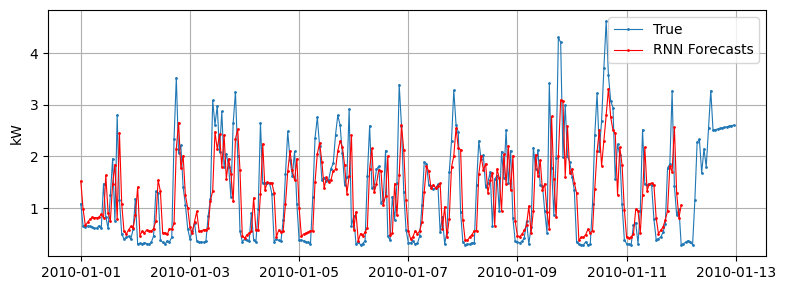

In [40]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(power_test.index, power_test.values, 
        marker=".", markersize=2, label="True", linewidth=0.8)

ax.plot(y_preds_rnn.index, y_preds_rnn.values, 
        color="red", marker=".", markersize=2, label="RNN Forecasts", linewidth=0.8)

ax.set_ylabel("kW")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

From a modeling perspective, the network used in this experiment is a [**vanilla recurrent neural network**](./papers/(1990)%20-%20Finding%20Structure%20in%20Time.pdf) Its practical ability to exploit long-term dependencies is limited by the well-known **vanishing gradient problem**. As gradients are propagated backward through time, they are repeatedly multiplied by the recurrent weight matrix and by the derivative of the activation function, which causes their magnitude to **shrink rapidly**. As a consequence, the effective temporal memory of the network is often much shorter than the nominal sequence length, making it **difficult for a simple RNN to reliably capture seasonal patterns** that extend over many time steps.

### Deep networks

It is common to increase the representational capacity of recurrent networks by **stacking multiple recurrent layers**. In a stacked RNN, each layer contains its own hidden state and is unrolled through time in the same way as a single-layer model: 

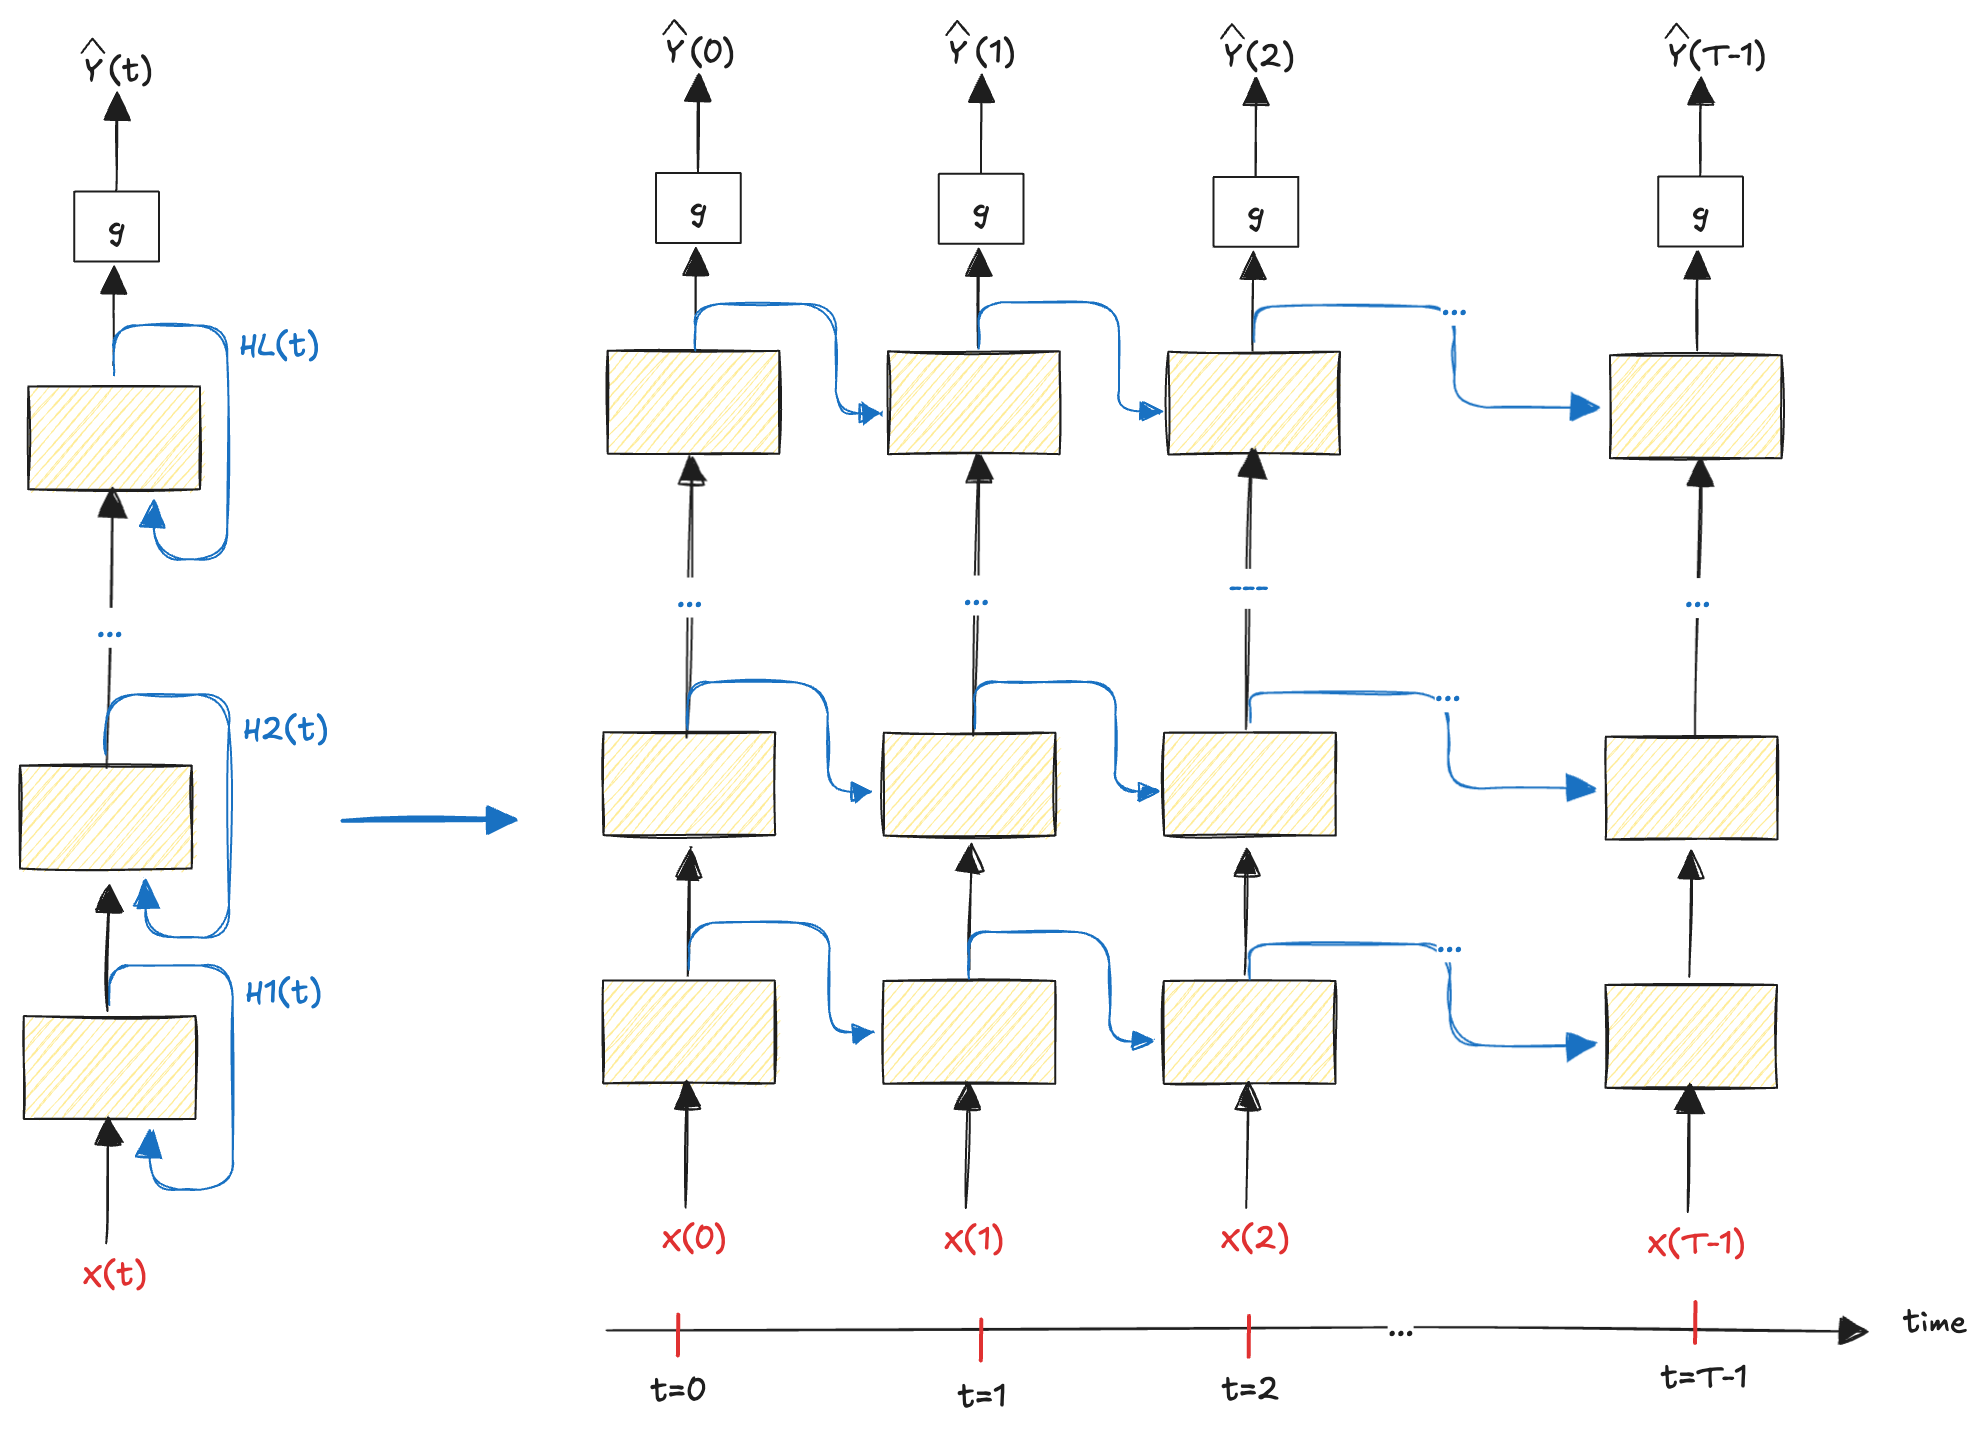

At a given time step, the first recurrent layer processes the input and produces a hidden representation. This representation is then fed as input to the second recurrent layer, producing a second hidden representation, and so on up to the top layer. In other words, information flows forward in time within each layer and upward across layers at each time step, while the parameters within each layer are shared across all time steps. Formally, the computation can be written as:

$\displaystyle H^{(\ell)}(t) = \phi\!\big(H^{(\ell-1)}(t) W_x^{(\ell)} + H^{(\ell)}(t-1) W_h^{(\ell)} + b^{(\ell)}\big)$

with the output typically computed from the top-layer state: 

$\displaystyle \hat Y(t) = g(H^{(L)}(t))$ 

This stacked structure allows higher layers to build **progressively more abstract temporal features**, often improving performance when the underlying dynamics are complex.

We now implement the stacked recurrent neural network using **PyTorch**, which provides built-in support for this architecture through the **nn.RNN module**, where the number of stacked layers is controlled by a single parameter:

In [41]:
import torch
import torch.nn as nn

# Input size, just the power consumption
input_size  = 1

# Number of hidden units in each RNN layer
hidden_size = 20                         

# Number of recurrent layers
num_layers  = 3

# Output size, just the power consumption prediction
output_size = 1

# Define the recurrent layers
deep_rnn = nn.RNN(input_size=input_size,
                  hidden_size=hidden_size,
                  num_layers=num_layers,
                  nonlinearity="relu")

# Define the fully connected layer
fc = nn.Linear(hidden_size, output_size)

# Define the optimizer
optimizer = torch.optim.Adam(list(deep_rnn.parameters()) + 
                             list(fc.parameters()), 
                             lr=1e-3)

# Define the forward function
def forward_deep(X):
    out, _ = deep_rnn(X)    
    Y_hat = fc(out)
    return Y_hat

We can now train the stacked RNN by iterating over the training data for multiple epochs and processing it in mini-batches. For each mini-batch, a single training step is performed: the model executes a forward pass, the loss is computed over the supervised time steps, gradients are propagated backward through time, and the parameters are updated. At the end of each epoch, the mini-batch losses are averaged to obtain the mean training loss, which provides a compact summary of the learning progress:

In [42]:
# Training parameters
epochs = 20
batch_size = 32

# Define the number of time steps to supervise
M = T   

# Set the model to training mode
deep_rnn.train()
fc.train()

# Run the training loop
for epoch in range(epochs):

    # Epoch losses
    epoch_losses = []

    # Shuffle indices
    indices = np.random.permutation(X_train.shape[1])
    
    for start_idx in range(0, len(indices), batch_size):

        # Get batch indices
        batch_idx = indices[start_idx:start_idx + batch_size]
    
        # Get batch (T, batch, 1)
        Xb = torch.as_tensor(X_train[:, batch_idx, :], dtype=torch.float32)
        Yb = torch.as_tensor(Y_train[:, batch_idx, :], dtype=torch.float32)

        # Clear previous gradients
        optimizer.zero_grad()
    
        # Forward pass
        Y_hat = forward_deep(Xb)

        # Compute loss
        loss = torch.sum((Y_hat[-M:] - Yb[-M:]) ** 2)

        # Backward pass
        loss.backward()
    
        # Update parameters
        optimizer.step()
        
        # Append loss to epoch losses
        epoch_losses.append(loss.item())

    # Calculate mean epoch loss
    epoch_loss = np.mean(epoch_losses)

    # Print epoch loss
    print(f"\rEpoch {epoch+1:02d}/{epochs} | Train loss: {epoch_loss:.6f}", end="", flush=True)

Epoch 20/20 | Train loss: 2.850582

We now evaluate the trained deep RNN on the test set as before, generating one-step-ahead forecasts in a rolling fashion and computing the MAPE on the unnormalized scale:

In [43]:
# List to store one-step-ahead predictions
y_preds = []

# Put model in evaluation mode
deep_rnn.eval()
fc.eval()

with torch.no_grad():

    # Walk-forward evaluation using the PyTorch deep RNN
    for step in power_test_period:

        # Extract the last T observations before "step" and normalize
        x_window = power_hourly_gap.loc[:step].iloc[-T-1:-1].to_numpy() / 10

        # Reshape to (T, B=1, D=1) as expected by nn.RNN (batch_first=False)
        x_tensor = torch.as_tensor(x_window.reshape(T, 1, 1), dtype=torch.float32)

        # Forward pass through the deep RNN
        output = forward_deep(x_tensor)

        # One-step-ahead prediction
        y_pred = float(output[-1, 0, 0].item())

        # Store the prediction
        y_preds.append(y_pred)

# Convert predictions to a time-indexed Series and unnormalize
y_preds_deep_rnn = pd.Series(y_preds, index=power_test_period) * 10

# Compute RNN MAPE
mape_deep_rnn = ((y_preds_deep_rnn - power_test) / power_test).abs().mean()

# Display the MAPE results
print(f"SARIMA MAPE: {mape_sarima_power:.2%}")
print(f"RNN MAPE: {mape_rnn:.2%}")
print(f"Deep RNN MAPE: {mape_deep_rnn:.2%}")

SARIMA MAPE: 75.54%
RNN MAPE: 51.78%
Deep RNN MAPE: 56.02%


On the household power consumption series, the deep RNN shows improved performance over both SARIMA and the simple RNN. The highly irregular, noisy nature of power consumption, frequent appliance-driven spikes, and complex nonlinear dynamics creates a setting where statistical models struggle to capture the full structure of the data, and the additional representational capacity of a deeper recurrent architecture begins to pay off.

Overall, these results reinforce a key lesson in time-series forecasting: **model choice should be guided by the structure of the data**. Classical approaches that explicitly encode known regularities can be highly effective on series dominated by strong, regular seasonality and stable dynamics. However, when the signal is noisy, nonlinear, and shaped by multiple interacting patterns, deeper neural architectures can better exploit the complexity of the data, provided they are given **sufficient capacity, training data, and careful tuning of hyperparameters** such as the sequence length T and the number of supervised time steps M.

## Extending to Multivariate and Multi-Step Forecasting

So far, we have focused on forecasting a univariate time series using one-step-ahead predictions. While this setting is useful for introducing recurrent neural networks and for understanding their strengths and limitations, many **real-world forecasting problems** are more complex. In practice, predictions often depend on **multiple correlated time series**, and the goal is frequently to **forecast several future time steps simultaneously** rather than a single value.

### Multivariate Input

A **multivariate time series** consists of **multiple interrelated sequences** observed over time. At each time step, the data are represented by a **vector** of observations, where each component corresponds to a different variable or feature. These variables often capture **complementary aspects** of the underlying process and may provide additional predictive power when **modeled jointly**. For example, in the context of the public transportation ridership example, we may observe separate time series for bus and rail usage. While each series reflects distinct travel behaviors, they are clearly related and may influence one another over time:

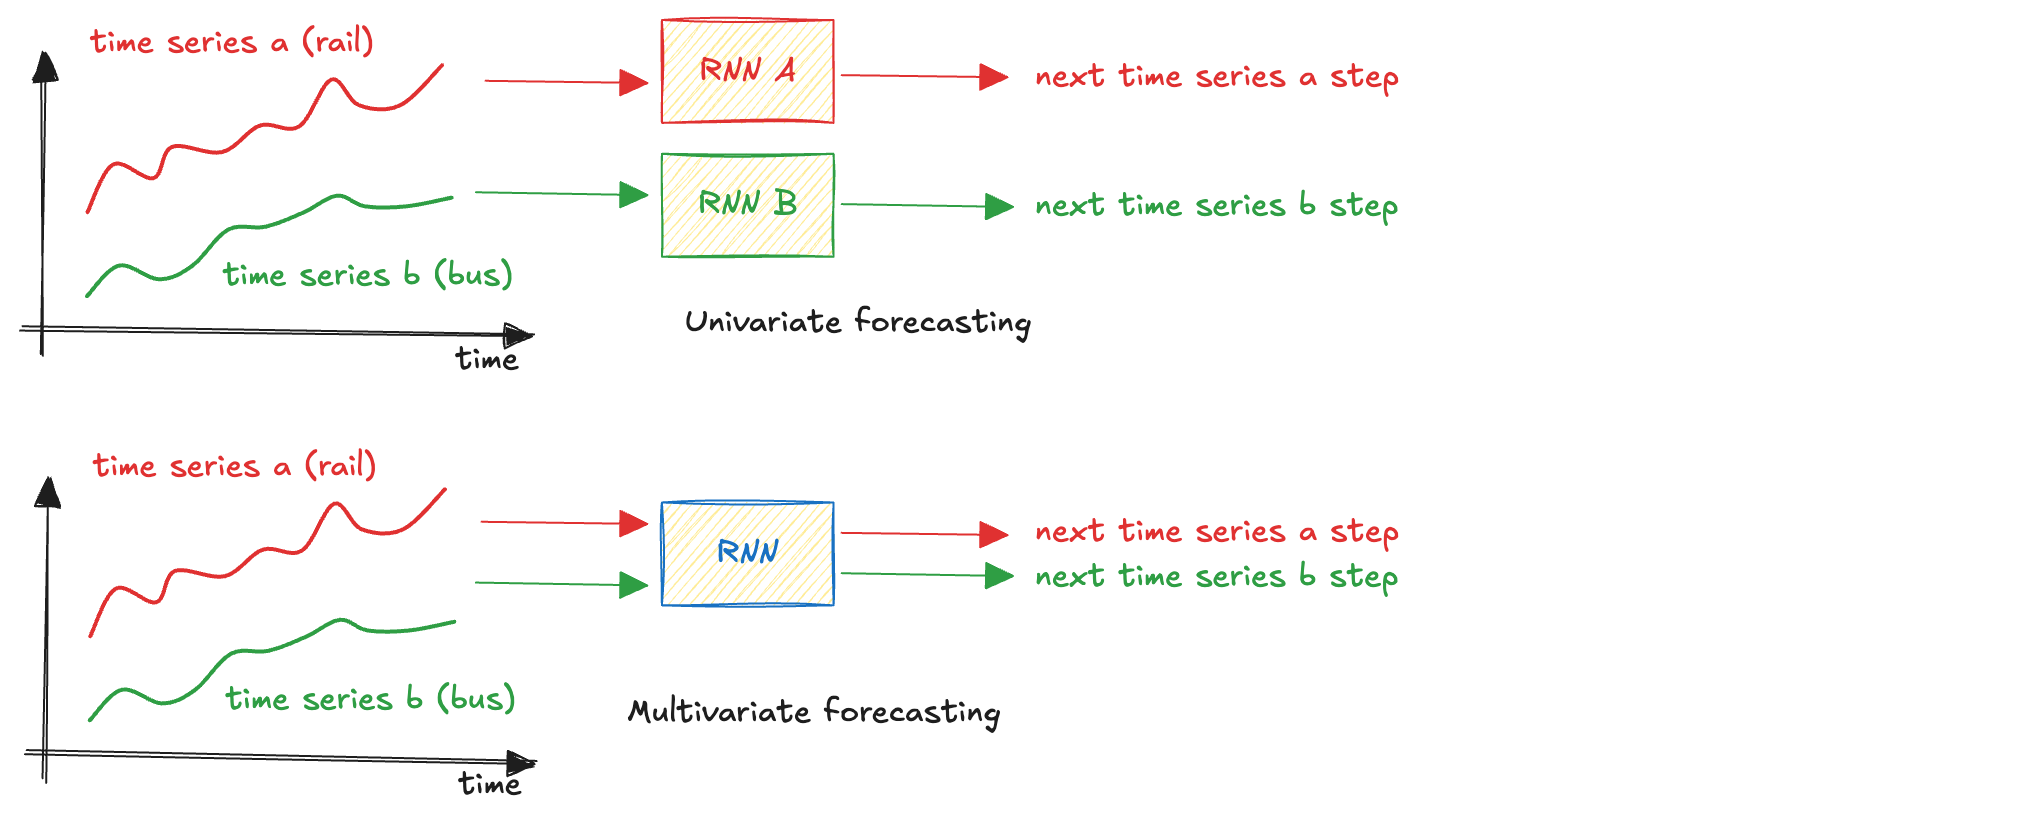

From a modeling perspective, multivariate time series can be handled with minimal changes to the recurrent network architecture. The main difference lies in the input representation: **instead of feeding a single scalar at each time step, the network receives a vector of features**. The household power consumption dataset is naturally multivariate. Beyond the global active power (which we've been forecasting), it includes several related time series that could serve as additional input features:

- Reactive power (kW)
- Voltage (V)
- Current intensity (A)
- Sub_metering_1	(Kitchen energy (Wh) — dishwasher, oven, microwave)
- Sub_metering_2	(Laundry room energy (Wh) — washing machine, dryer, fridge)
- Sub_metering_3	(Water heater & air conditioner energy (Wh))

To illustrate this setting, we consider forecasting the global active power (as before) while using all other available time series as inputs to the model, in order to **exploit cross-dependencies** between variables when generating forecasts. We split the multivariate time series into training and test series using the same chronological boundaries adopted in the univariate experiments, ensuring a fair and consistent evaluation of the multivariate forecasting model:

In [44]:
# Prepare multivariate training series
cols = ["Global_active_power", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]
power_mulvar_train = power_hourly[cols][:power_train_end_date].resample("h").mean() / 10

We prepare the corresponding input–target multivariate training and test datasets. Each input sequence now consists of four features (global active power and three sub-meterings), while the target sequence remains univariate (global active power only):

In [45]:
# Create input-target sequences for training set
X_train_mulvar, Y_train_mulvar = make_sequences(power_mulvar_train, T)

# Keep only the first feature (Global_active_power) as target
Y_train_mulvar = Y_train_mulvar[:, :, 0:1]

We now define a **stacked recurrent neural network for multivariate forecasting**, where each time step is represented by a vector of inputs (global active power and sub-metering values), and the network produces a sequence of predictions for the target variable through a linear readout applied to the hidden states:

In [46]:
# Define RNN model dimensions (multivariate input)
input_size  = 4  # power + 3 sub-meterings
hidden_size = 20
num_layers = 3   
output_size = 1  # just the power consumption prediction

# Define the recurrent layers
deep_rnn_mulvar = nn.RNN(input_size=input_size,
                         hidden_size=hidden_size,
                         num_layers=num_layers,
                         nonlinearity="relu")

# Define the fully connected layer
fc_mulvar = nn.Linear(hidden_size, output_size)

# Define the optimizer
optimizer_mulvar = torch.optim.Adam(list(deep_rnn_mulvar.parameters()) + 
                                    list(fc_mulvar.parameters()), 
                                    lr=1e-3)

# Define the forward function
def forward_deep_mulvar(X):
    out, _ = deep_rnn_mulvar(X)
    Y_hat = fc_mulvar(out)
    return Y_hat

Notice that the only difference with respect to the univariate model is the **input dimensionality**. At each time step, the model now receives four input features instead of one: global active power and three sub-metering signals. In this case we output only the global active power forecast, however the model could easily be **extended** to produce forecasts for all series simultaneously by adjusting the output layer accordingly. The training step is equivalent to the previous one, since the architecture is the same and only the input size has changed:

In [47]:
# Training parameters
epochs = 20
batch_size = 32

# Define the number of time steps to supervise
M = T 

# Set the model to training mode
deep_rnn_mulvar.train()
fc_mulvar.train()

# Run the training loop
for epoch in range(epochs):

    # Epoch losses
    epoch_losses = []

    # Shuffle indices
    indices = np.random.permutation(X_train_mulvar.shape[1])

    for start_idx in range(0, len(indices), batch_size):

        # Get batch indices
        batch_idx = indices[start_idx:start_idx + batch_size]

        # Get batch (T, B, D)
        Xb = torch.as_tensor(X_train_mulvar[:, batch_idx, :], dtype=torch.float32)
        Yb = torch.as_tensor(Y_train_mulvar[:, batch_idx, :], dtype=torch.float32)

        # Clear previous gradients
        optimizer_mulvar.zero_grad()
    
        # Forward pass
        Y_hat = forward_deep_mulvar(Xb)

        # Compute loss
        loss = torch.sum((Y_hat[-M:] - Yb[-M:]) ** 2)

        # Backward pass
        loss.backward()
    
        # Update parameters
        optimizer_mulvar.step()
        
        # Append loss to epoch losses
        epoch_losses.append(loss.item())

    # Calculate mean epoch loss
    epoch_loss = np.mean(epoch_losses)
    
    # Print epoch loss (overwrite same line)
    print(f"\rEpoch {epoch+1:03d}/{epochs} | Train loss: {epoch_loss:.6f}", end="", flush=True)

Epoch 020/20 | Train loss: 2.115863

As before, we evaluate the new multivariate RNN on the test set to compute the MAPE and compare with previous results:

In [48]:
# List to store one-step-ahead predictions
y_preds = []

# Put model in evaluation mode
deep_rnn_mulvar.eval()
fc_mulvar.eval()

with torch.no_grad():

    # Walk-forward evaluation using the PyTorch deep RNN
    for step in power_test_period:

        # Extract the last T observations before "now" and normalize
        x_window = power_hourly[cols].loc[:step].iloc[-T-1:-1].to_numpy() / 10

        # Reshape to (T, B=1, D=4) as expected by nn.RNN 
        x_tensor = torch.as_tensor(x_window.reshape(T, 1, 4), dtype=torch.float32)

        # Forward pass through the deep RNN
        output = forward_deep_mulvar(x_tensor)

        # One-step-ahead prediction for step
        y_pred = float(output[-1, 0, 0].item())

        # Store the prediction
        y_preds.append(y_pred)

# Convert predictions to a time-indexed Series and unnormalize
y_preds_deep_rnn_mulvar = pd.Series(y_preds, index=power_test_period) * 10

# Compute RNN MAPE
mape_deep_rnn_mulvar = ((y_preds_deep_rnn_mulvar - power_test) / power_test).abs().mean()

# Display the MAPE results
print(f"SARIMA MAPE: {mape_sarima_power:.2%}")
print(f"RNN MAPE: {mape_rnn:.2%}")
print(f"Deep RNN MAPE: {mape_deep_rnn:.2%}")
print(f"Deep RNN Multivariate MAPE: {mape_deep_rnn_mulvar:.2%}")

SARIMA MAPE: 75.54%
RNN MAPE: 51.78%
Deep RNN MAPE: 56.02%
Deep RNN Multivariate MAPE: 43.20%


The multivariate model achieves a substantial improvement. This confirms that providing multiple related inputs into a single model often improves performance, since features learned from one signal may carry useful information for predicting another. In addition, the need to extract representations that are relevant across multiple input dimensions can act as an **implicit form of regularization**, reducing the risk of overfitting to noise in any single variable.

### Forecasting Several Steps Ahead

So far we predicted the value at the next time step. Extending that to a forecast several steps ahead is straightforward in principle because we only need to change the prediction target: to forecast several steps ahead we could replace the one-step-ahead target with the value N steps ahead. However, this raises design choices that affect model architecture, training procedure, bias/variance and how errors propagate through the horizon.

The first option is known as **recursive multi-step forecasting**. It starts from a standard sequence-to-vector model trained to predict a single step ahead. At inference time, the model is applied to the available input window to produce the next predicted value. This prediction is then appended to the input sequence, replacing the oldest observation, and the updated window is fed back into the same model. By treating the predicted value as if it were an actual observation, the model can be applied repeatedly to generate the following prediction, and this process is iterated until the desired forecast horizon is reached.

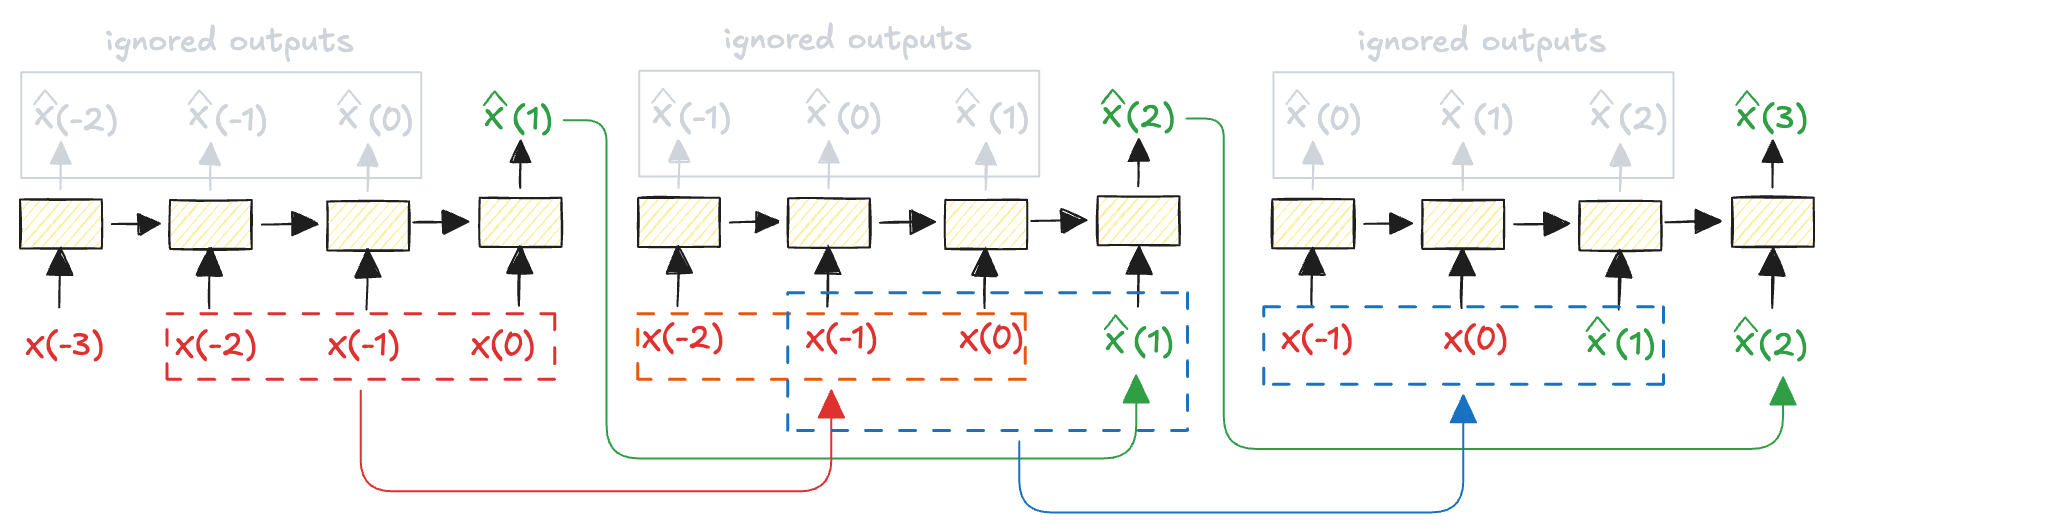

In [49]:
# Define the forecast start point, end of training period
today = pd.Timestamp(power_train_end_date)

# Define the forecasting horizon (2 day ahead)
horizon = 48

# Create date range for predictions
forecast_dates = pd.date_range(start=today + pd.Timedelta(hours=1), 
                               periods=horizon, freq="h")

# Initial input window: last T observations up to "today" (normalized)
X = torch.as_tensor(
    power_hourly_gap.loc[:today].iloc[-T:].to_numpy().reshape(T, 1, 1) / 10,
    dtype=torch.float32
)

# List to store the successive forecasts
y_preds = []

# Put model in evaluation mode
deep_rnn.eval()
fc.eval()

with torch.no_grad():

    for step_ahead in range(horizon):

        # One-step-ahead prediction using the trained model
        Y_hat = forward_deep(X)
        y_pred_one = Y_hat[-1, 0, 0]

        # Store the prediction (unnormalized)
        y_preds.append(y_pred_one.item() * 10)

        # Append the prediction and discard the oldest input
        X = torch.cat([X[1:], y_pred_one.reshape(1, 1, 1)], dim=0)

# Convert predictions to Series
y_preds_multistep = pd.Series(y_preds, index=forecast_dates)

We can plot the resulting forecasts:

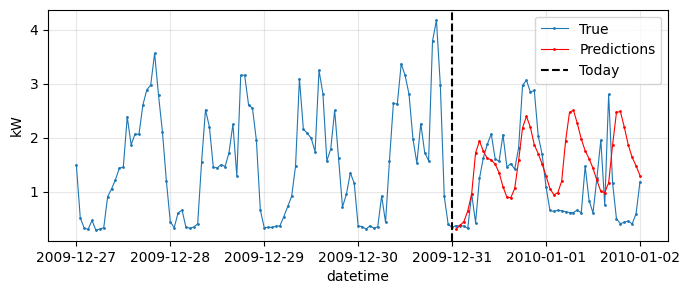

In [50]:
fig, ax = plt.subplots(figsize=(8, 3))

# Define the start of the history to plot (4 days before "today") 
# and the end of the future to plot (horizon hours after "today")
history_start = today - pd.Timedelta(hours=96)
future_end = today + pd.Timedelta(hours=horizon)

# Plot true values (history before "today" and future after "today")
ax.plot(power_hourly_gap.loc[history_start:future_end].index,
        power_hourly_gap.loc[history_start:future_end].values,
        marker=".", markersize=2, label="True", linewidth=0.8)

# Plot predictions
ax.plot(y_preds_multistep.index,
        y_preds_multistep.values,
        marker=".", markersize=2, color="red", label="Predictions", linewidth=0.8)

# Add vertical line for "today"
ax.axvline(x=today, color="black", linestyle="--", label="Today")

ax.set_ylabel("kW")
ax.set_xlabel("datetime")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

Notice that any error made by the model at a given time step is immediately fed back into the input and therefore influences all subsequent predictions. As a consequence, **inaccuracies are not isolated but propagate forward through the forecasting horizon**, typically growing with each additional step. For this reason, errors tend to **accumulate** in recursive multi-step forecasting, and the approach is usually reliable only for relatively **short horizons**. In the plot above, the recursive forecasts capture the general daily oscillation in power consumption, but the predicted peaks and troughs gradually drift in both amplitude and timing as the horizon extends, illustrating how small initial errors compound into increasingly unreliable predictions.

The second option is known as **direct multi-step forecasting**. In this case we still employ a sequence-to-vector model, but instead of training it to produce a single one-step-ahead prediction, **we train the RNN to output the next N values simultaneously** in a single forward pass. The model therefore learns an **explicit mapping** from the past input window to the entire future horizon, without reusing its own predictions as inputs during inference:

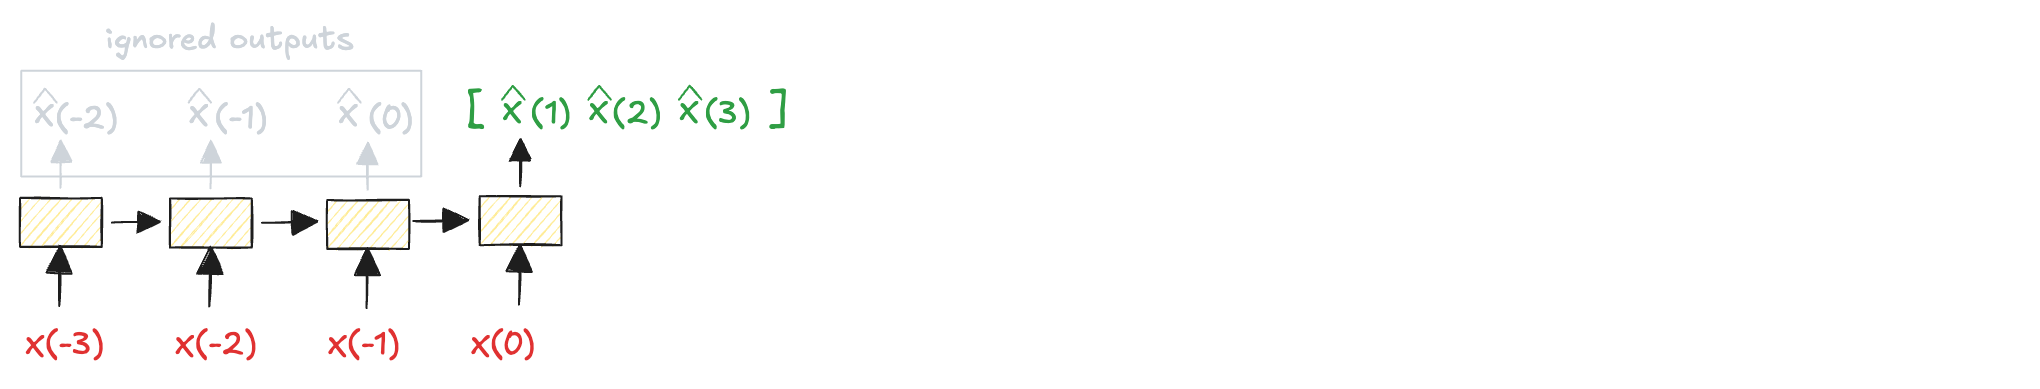

However, this requires a preliminary change in the way the dataset is constructed, because the **targets are no longer scalar values but vectors containing the next observations over the forecast horizon**. The key idea is to build training sequences that explicitly include both the input window and the entire future segment to be predicted:

In [51]:
def make_sequences_multistep(series, T, horizon):
    X, Y = [], []
    for i in range(len(series) - T - horizon + 1):
        X.append(series[i:i+T])
        Y.append(series[i+T:i+T+horizon])
    return np.array(X), np.array(Y)

# Create input-target sequences for training 
X_train_direct, Y_train_direct = make_sequences_multistep(power_train_normalized.to_numpy(), T, horizon)

# Reshape for PyTorch RNN: (B, T, 1) -> (T, B, 1)
X_train_direct = X_train_direct.reshape(-1, T, 1).transpose(1, 0, 2)

# Targets shape: (batch, horizon)
Y_train_direct = Y_train_direct.reshape(-1, horizon)

We define a stacked RNN whose final hidden state is mapped directly to the entire prediction horizon through a single fully connected output layer:

In [52]:
# Define the direct multi-step model
deep_rnn_direct = nn.RNN(input_size=1,
                         hidden_size=20,
                         num_layers=3,
                         nonlinearity="relu")

# Output layer predicts horizon values directly
fc_direct = nn.Linear(20, horizon)

# Define the optimizer
optimizer_direct = torch.optim.Adam(list(deep_rnn_direct.parameters()) + 
                                    list(fc_direct.parameters()),
                                    lr=1e-3)


# Define the forward function
def forward_direct(X):
    out, _ = deep_rnn_direct(X)
    # Use only the last time step output to predict all horizon values
    Y_hat = fc_direct(out[-1])
    return Y_hat

The training loop follows the standard mini-batch optimization procedure, where each forward pass produces the entire prediction horizon in a single shot and the loss is computed jointly over all horizon values:

In [53]:
# Training loop
epochs = 20
batch_size = 32

# Set the model to training mode
deep_rnn_direct.train()
fc_direct.train()

for epoch in range(epochs):
    epoch_losses = []
    
    # Shuffle indices
    indices = np.random.permutation(X_train_direct.shape[1])
    
    for start_idx in range(0, len(indices), batch_size):
        batch_idx = indices[start_idx:start_idx + batch_size]
        
        # Get batch (T, batch, 1)
        Xb = torch.as_tensor(X_train_direct[:, batch_idx, :], dtype=torch.float32)
        Yb = torch.as_tensor(Y_train_direct[batch_idx, :], dtype=torch.float32)
        
        # Zero gradients
        optimizer_direct.zero_grad()
        
        # Forward pass
        Y_hat = forward_direct(Xb)
        
        # Compute loss
        loss = torch.sum((Y_hat - Yb) ** 2)
        
        # Backward pass
        loss.backward()
        optimizer_direct.step()
        
        epoch_losses.append(loss.item())
    
    epoch_loss = np.mean(epoch_losses)
    print(f"\rEpoch {epoch+1:03d}/{epochs} | Train loss: {epoch_loss:.6f}", end="", flush=True)

Epoch 020/20 | Train loss: 9.6402503

At inference time, the direct multi-step model is switched to evaluation mode and used to predict the entire forecast horizon in a single forward pass, without any recursive feedback of predictions into the input:

In [54]:
# Put model in evaluation mode
deep_rnn_direct.eval()
fc_direct.eval()

# Create input tensor for direct prediction
X_direct = torch.as_tensor(
    power_hourly_gap.loc[:today].iloc[-T:].to_numpy().reshape(T, 1, 1) / 10,
    dtype=torch.float32
)

# Direct prediction of all horizon values at once
with torch.no_grad():
    y_preds = forward_direct(X_direct).squeeze().numpy() * 10

# Convert predictions to Series
y_preds_direct = pd.Series(y_preds, index=forecast_dates)

The resulting forecasts can be visualized by plotting the recent history together with the predicted future horizon, clearly separating past observations from model predictions in time:

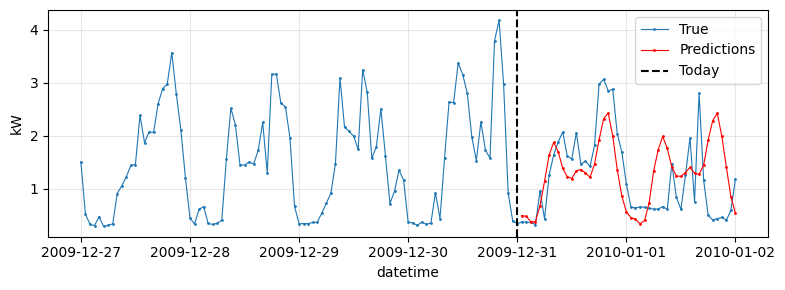

In [55]:
# Plot
fig, ax = plt.subplots(figsize=(8, 3))

# Plot true values (history before "today" and future after "today")
ax.plot(power_hourly_gap.loc[history_start:future_end].index,
        power_hourly_gap.loc[history_start:future_end].values,
        marker=".", markersize=2, label="True", linewidth=0.8)

# Plot predictions
ax.plot(y_preds_direct.index,
        y_preds_direct.values,
        marker=".", markersize=2, color="red", label="Predictions", linewidth=0.8)

# Add vertical line for "today"
ax.axvline(x=today, color="black", linestyle="--", label="Today")

ax.set_ylabel("kW")
ax.set_xlabel("datetime")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

Now each point in the forecast horizon is **predicted independently** of the others, conditioned only on the last observed input window. As a consequence, **errors do not propagate forward in time**. The daily cycle is reproduced more consistently across the entire horizon, with the model correctly identifying the nighttime troughs and daytime peaks, although the predicted amplitudes tend to be smoother and lower than the actual values. 

The third option is **sequence-to-sequence forecasting**. Instead of training the model to predict the next N values only from the final time step of the input window, the model is trained to generate **a full length-N forecast at every time step of the sequence**. In this setting, each intermediate hidden state is **explicitly supervised** with a multi-step target, so the network learns how future trajectories evolve as new observations arrive, rather than relying solely on the final state of the encoder: 

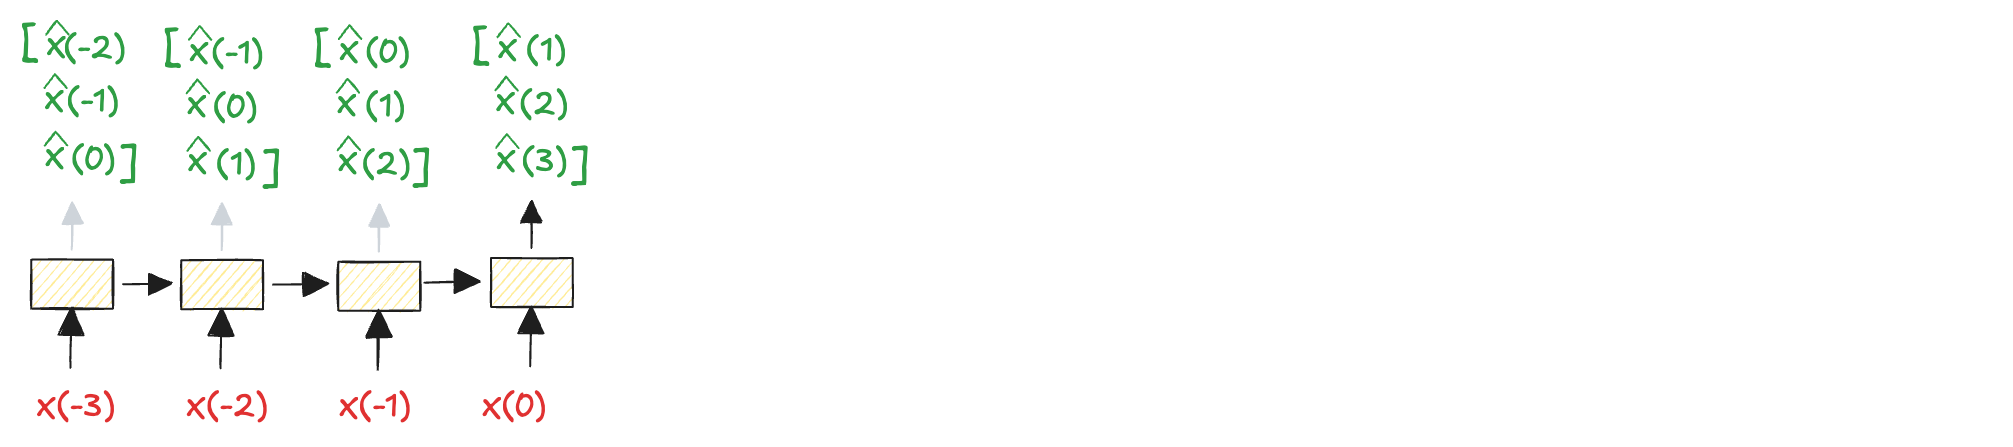

The main advantage is that **the loss now includes a contribution from the RNN output at every time step**, rather than only from the final one. As a result, **many more error signals are injected into the network** during training. These gradients do not need to propagate through long temporal chains, because they originate locally from each time step instead of exclusively from the last output. This denser and more local supervision both **stabilizes optimization** and **typically accelerates convergence**.

Preparing the datasets is not trivial, since **each instance has a window as input and a sequence of windows as output**:

In [56]:
def make_sequences_seq2seq(series, T, horizon):
    
    X, Y = [], []
    
    for i in range(len(series) - T - horizon + 1):
        X.append(series[i:i+T])
        
        # For each time step, the target is the next horizon values
        Y.append([series[i+t+1:i+t+1+horizon] for t in range(T)])
    return np.array(X), np.array(Y)

# Create input-target sequences for training
X_train_seq2seq, Y_train_seq2seq = make_sequences_seq2seq(power_train_normalized.to_numpy(), T, horizon)

# Reshape for PyTorch RNN: (B, T) -> (T, B, 1)
X_train_seq2seq = X_train_seq2seq.reshape(-1, T, 1).transpose(1, 0, 2)

# Targets shape: (B, T, horizon) -> (T, B, horizon)
Y_train_seq2seq = Y_train_seq2seq.transpose(1, 0, 2)

We can use the same network architecture as direct multi-step forecasting:

In [57]:
# Define the sequence-to-sequence model
deep_rnn_seq2seq = nn.RNN(input_size=1,
                          hidden_size=20,
                          num_layers=3,
                          nonlinearity="relu")

# Output layer predicts horizon values at each time step
fc_seq2seq = nn.Linear(20, horizon)

# Define the optimizer
optimizer_seq2seq = torch.optim.Adam(
    list(deep_rnn_seq2seq.parameters()) + list(fc_seq2seq.parameters()),
    lr=1e-3
)

# Define the forward function
def forward_seq2seq(X):
    out, _ = deep_rnn_seq2seq(X)  # out: (T, B, hidden_size)
    Y_hat = fc_seq2seq(out)        # Y_hat: (T, B, horizon)
    return Y_hat

The key difference is in **how supervision is applied during training**: while the direct approach only computes predictions and loss at the last time step, the sequence-to-sequence model predicts the next values at every time step in the input sequence, providing denser supervision that can improve generalization:

In [58]:
epochs = 20
batch_size = 32

deep_rnn_seq2seq.train()
fc_seq2seq.train()

for epoch in range(epochs):
    epoch_losses = []
    
    indices = np.random.permutation(X_train_seq2seq.shape[1])
    
    for start_idx in range(0, len(indices), batch_size):
        batch_idx = indices[start_idx:start_idx + batch_size]
        
        Xb = torch.as_tensor(X_train_seq2seq[:, batch_idx, :], dtype=torch.float32)
        Yb = torch.as_tensor(Y_train_seq2seq[:, batch_idx, :], dtype=torch.float32)
        
        optimizer_seq2seq.zero_grad()
        
        Y_hat = forward_seq2seq(Xb)
        
        # Loss computed over all time steps and all horizon predictions
        loss = torch.sum((Y_hat - Yb) ** 2)
        
        loss.backward()
        optimizer_seq2seq.step()
        
        epoch_losses.append(loss.item())
    
    epoch_loss = np.mean(epoch_losses)
    print(f"\rEpoch {epoch+1:03d}/{epochs} | Train loss: {epoch_loss:.6f}", end="", flush=True)

Epoch 020/20 | Train loss: 254.435566

At inference time, although the model produces predictions at every time step, **we only use the output from the last time step**, which corresponds to **the forecast made with the most complete information available**:

In [59]:
X_seq2seq = torch.as_tensor(
    power_hourly_gap.loc[:today].iloc[-T:].to_numpy().reshape(T, 1, 1) / 10,
    dtype=torch.float32
)

# Put model in evaluation mode
deep_rnn_seq2seq.eval()
fc_seq2seq.eval()

with torch.no_grad():
    # Predict horizon values at each time step, use only the last time step's prediction
    Y_hat = forward_seq2seq(X_seq2seq)
    y_preds = Y_hat[-1, 0, :].numpy() * 10  # (horizon,)

# Convert predictions to Series
y_preds_seq2seq = pd.Series(y_preds, index=forecast_dates)

We can visualize the resulting forecasts as before:

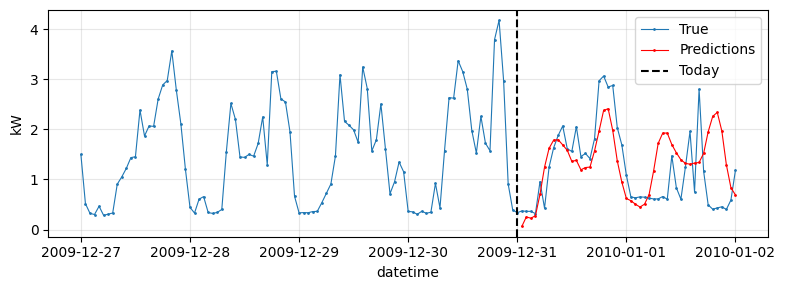

In [60]:
# Plot
fig, ax = plt.subplots(figsize=(8, 3))

# Plot true values (history before "today" and future after "today")
ax.plot(power_hourly_gap.loc[history_start:future_end].index,
        power_hourly_gap.loc[history_start:future_end].values,
        marker=".", markersize=2, label="True", linewidth=0.8)

# Plot predictions
ax.plot(y_preds_seq2seq.index,
        y_preds_seq2seq.values,
        marker=".", markersize=2, color="red", label="Predictions", linewidth=0.8)

# Add vertical line for "today"
ax.axvline(x=today, color="black", linestyle="--", label="Today")

ax.set_ylabel("kW")
ax.set_xlabel("datetime")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

From the plot, the direct and sequence-to-sequence forecasts appear nearly indistinguishable, which is expected since both architectures produce the same output(a vector of horizon predictions) and differ only in how supervision is applied during training. The sequence-to-sequence model, however, benefits from **denser gradient signals**: because a multi-step loss is computed at every time step of the input window (not just the last), gradients reach all hidden states more directly, which typically leads to faster convergence and more stable optimization. This advantage may translate into better generalization, especially on noisy signals like household power consumption where robust internal representations are critical. To quantitatively compare the three approaches, we compute the MAPE over the forecast horizon:

In [61]:
# Ground truth over the forecast horizon
true_values = power_hourly_gap.loc[forecast_dates]

# Compute MAPE for all three approaches
mape_recursive = ((y_preds_multistep - true_values) / true_values).abs().mean()
mape_direct    = ((y_preds_direct - true_values) / true_values).abs().mean()
mape_seq2seq   = ((y_preds_seq2seq - true_values) / true_values).abs().mean()

# Display the results
print(f"Recursive Multi-step MAPE: {mape_recursive:.2%}")
print(f"Direct Multi-step MAPE:    {mape_direct:.2%}")
print(f"Seq2Seq Multi-step MAPE:   {mape_seq2seq:.2%}")

Recursive Multi-step MAPE: 103.41%
Direct Multi-step MAPE:    79.75%
Seq2Seq Multi-step MAPE:   79.34%


In practice, different multi-step strategies can be **combined**. For example, a model trained to forecast the next N hours can be applied once to produce an initial forecast, its output appended to the input window, and the model applied again to extend the horizon further. This hybrid approach offers a trade-off between the direct method's error independence and the recursive method's ability to reach arbitrarily long horizons.

However, all three approaches share a fundamental limitation when built on vanilla RNNs: **performance degrades significantly as the forecast horizon or the input sequence length grows**. The problem limits the effective temporal memory of the network, making it **difficult to capture long-range dependencies** such as weekly or seasonal patterns in the power consumption signal. This motivates the use of **more advanced architectures** which are specifically designed to maintain and selectively update information over much longer time spans.

### Handling Long Sequences

One of the main appeals of RNNs is their ability, at least in principle, to **connect past information to the present task**. For example, in video processing, earlier frames can provide crucial context for interpreting the current frame. In many situations only **recent context is required**. A language model predicting the next word in the phrase "*the clouds are in the ____*" does not need to look far into the past: the next word is almost certainly "*sky*". In cases like this, where the relevant information lies close to the prediction point, standard RNNs can learn to exploit temporal dependencies effectively.

There are, however, many tasks that **require longer-term context**. Consider predicting the last word in the sentence "*I grew up in France […] I speak fluent ____*". The most recent words indicate that the next token should be the name of a language, but identifying which language requires access to information introduced much earlier in the sequence. In such cases, the gap between the relevant information and the point where it must be used can become large. Unfortunately, as this gap increases, [vanilla RNNs struggle to learn these long-range dependencies](./papers/(1994)%20-%20Learning%20Long-Term%20Depencencies%20with%20Gradient%20Descent%20is%20Difficult.pdf) and eventually fail to connect distant past information to the present prediction.

When training an RNN on long sequences, this difficulty becomes apparent from a computational perspective as well. The network must be unrolled over many time steps, effectively turning the RNN into a **very deep computational graph**, which exacerbates the underlying learning challenges.

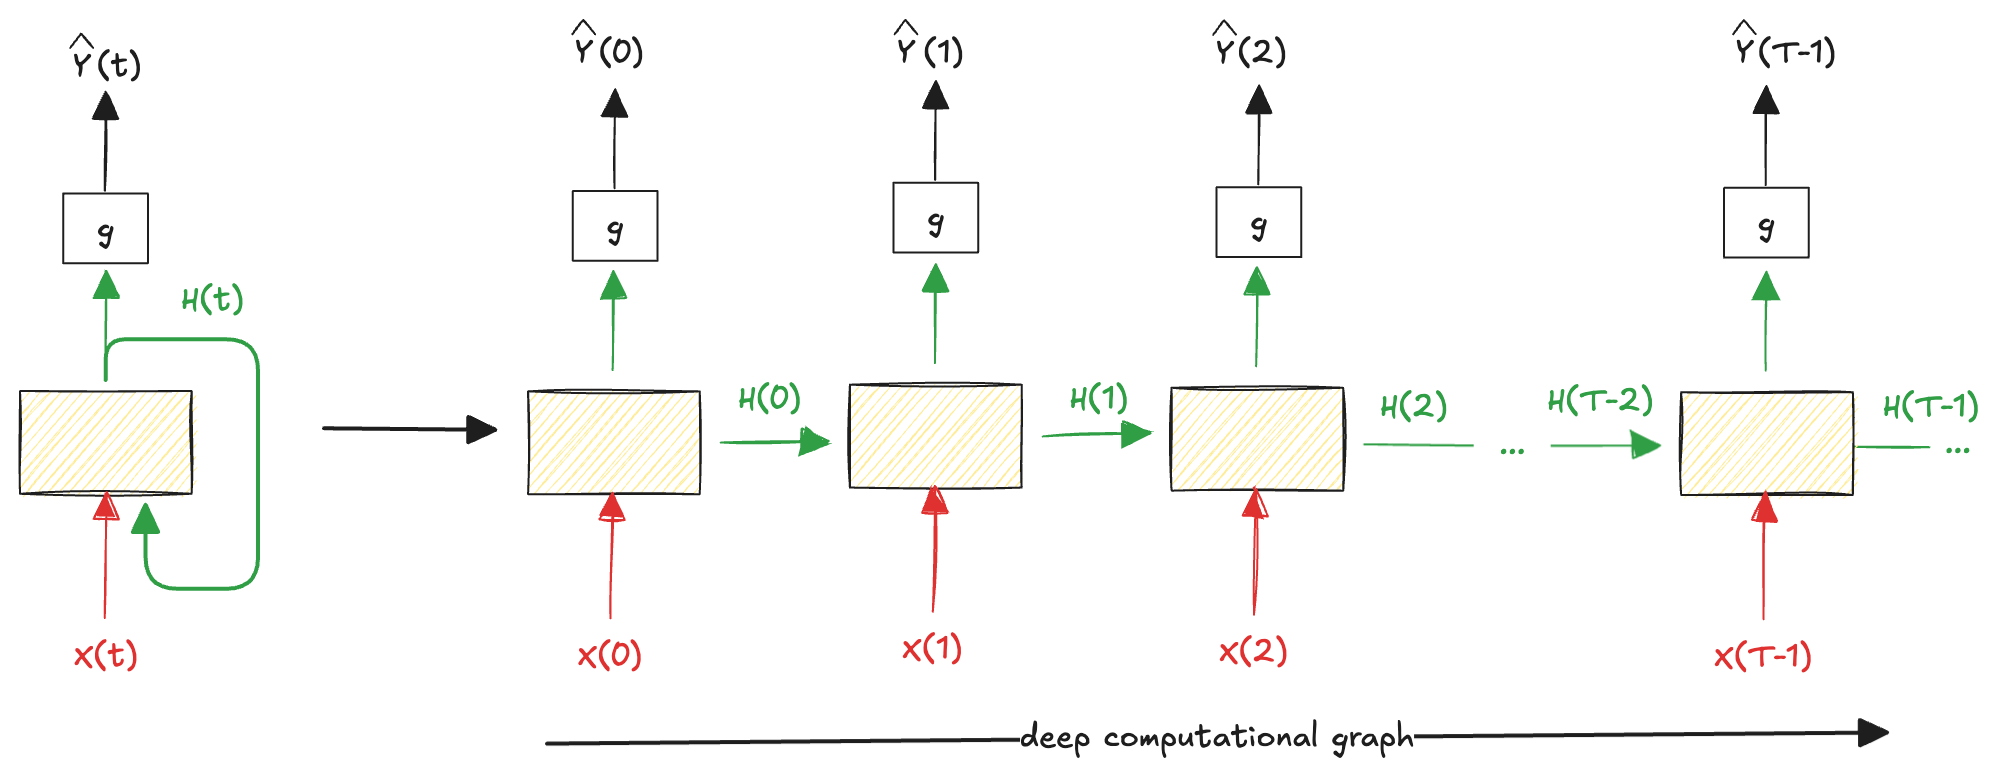

As with any deep neural network, this depth makes the training process vulnerable to **gradients problem**. As already discussed, the hidden-state error signal receives two contributions, one direct from the output and on indirect from the next hidden state, leading to the recursive formula:

$\displaystyle \delta_H(t) = \delta_Y(t)W_y^\top + \delta_Z(t+1) W_h^\top$

And since 

$\delta_Z(t) = \delta_H(t) \odot \phi'(Z(t))$

we have:

$\displaystyle \delta_H(t) = \delta_Y(t)W_y^\top + \delta_H(t+1) \odot \phi'(Z(t+1)) \cdot W_h^\top$

As we propagate the error backward from the final time step to earlier ones, this multiplication is repeated many times.

$\displaystyle \delta_H(t) \propto \prod_{i=t}^{T} \left( \phi'(Z(i)) \cdot W_h^\top \right)$

Intuitively, each step of backpropagation through time either attenuates or amplifies the error signal. If the weights tend to **amplify** vectors, each step increases the gradient magnitude, and over many time steps this leads to exponential growth, producing **numerically unstable gradients** (exploding gradients problem). If, instead, the weights tend to shrink vectors, each step slightly reduces the gradient magnitude; repeating this over many time steps causes the gradient to decay exponentially, so **information from early inputs is effectively lost** (vanishing gradients problem). These two phenomena are closely related and make it [challenging for the vanilla RNNs to learn from long-range temporal patterns](./papers/(1994)%20-%20Learning%20Long-Term%20Depencencies%20with%20Gradient%20Descent%20is%20Difficult.pdf).

## Exploding Gradients Problem

From the perspective of the exploding gradients problem, many of the techniques used to stabilize deep feedforward networks are equally important for RNNs. **Careful parameter initialization**, **adaptive optimizers**, and **explicit stabilization mechanisms** such as gradient clipping play a central role in keeping training numerically well behaved. However, the recurrent setting introduces a crucial difference: **the same transformation is applied repeatedly over time**, so any tendency to amplify signals is not isolated to a single layer but is compounded across many time steps.

### Saturating activation functions

This effect is especially pronounced when using **non-saturating activation functions** such as ReLU:

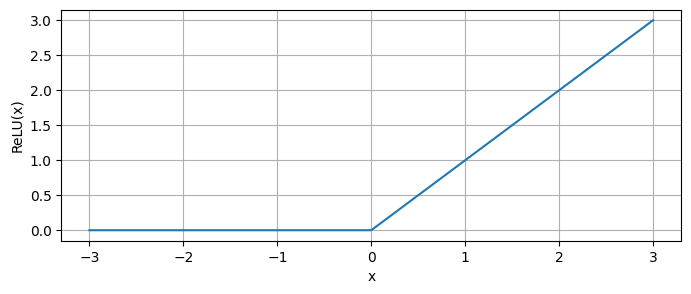

In [62]:
# Define the ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Plot the ReLU function
x = np.linspace(-3, 3, 400)
y = relu(x)

fig, ax = plt.subplots(figsize=(8, 3))
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("ReLU(x)")
plt.grid(True)
plt.show()

In feedforward networks, ReLU is beneficial because it does not squash activations and therefore allows gradients to flow through deep stacks of layers. In an RNN, however, the reuse of the same weights at every time step means that even a small positive amplification in the hidden state can be fed back repeatedly, causing activations to grow exponentially over time. Non-saturating activations offer no inherent mechanism to limit this growth, making exploding gradients a concrete risk. For example, we can explicitly illustrate this effect by simulating how the same weights and activation function are applied repeatedly across several time steps, mimicking the recurrent dynamics of an RNN:

In [63]:
def simulate_rnn(h0, W_h, activation, T):
    h = h0.copy()
    
    norms = [np.linalg.norm(h)]
    
    for t in range(T):
        # Pre-activation
        z = W_h @ h  

        # Post-activation
        h = activation(z)

        # Store the norm of the hidden state
        norms.append(np.linalg.norm(h))
    
    # return the norm
    return norms

Now we start a simulation using a random initial hidden state, a weight matrix prone to amplification, the non-saturating ReLU activation and several time steps:

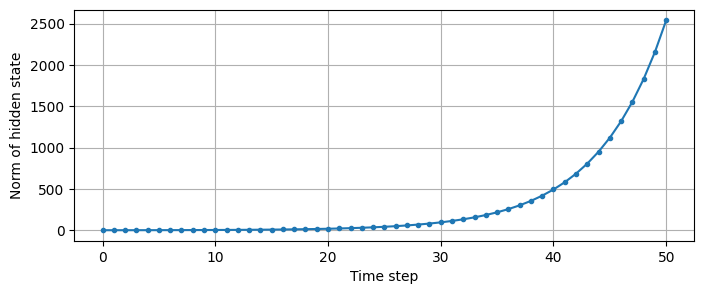

In [64]:
# Number of time steps
T = 50

# Weight matrix (prone to explosion, >1)
W_h = np.array([[1.1, 0.1],
                [0.1, 1.05]])

# Initial hidden state
h0 = np.array([0.5, 0.5])

# Simulate the RNN with ReLU activation
norms_relu = simulate_rnn(h0, W_h, relu, T)

# Plot the norms over time
fig, ax = plt.subplots(figsize=(8, 3))
plt.plot(norms_relu, marker=".")
plt.xlabel("Time step")
plt.ylabel("Norm of hidden state")
plt.grid(True)
plt.show()

For this reason, classical vanilla RNNs typically employ **saturating activation functions** such as the hyperbolic tangent: 

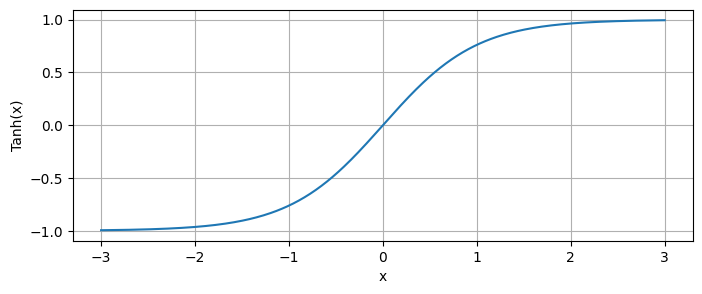

In [65]:
# Define the Tanh activation function
def tanh(x):
    return np.tanh(x)

# Plot the Tanh function
x = np.linspace(-3, 3, 400)
y = tanh(x)

fig, ax = plt.subplots(figsize=(8, 3))
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("Tanh(x)")
plt.grid(True)
plt.show()

By bounding the hidden state within a fixed range, it acts as a **natural stabilizer**, preventing unchecked amplification of signals as they circulate through time. As the following simulation shows:

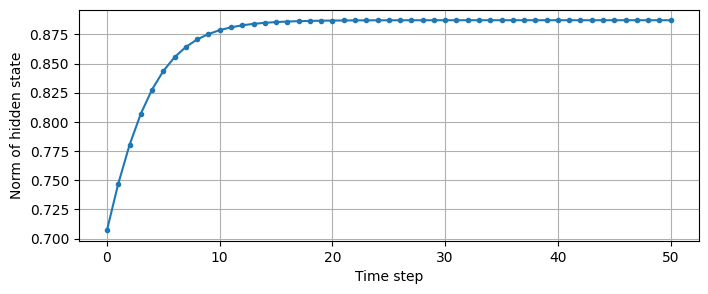

In [66]:
# Simulate the RNN with Tanh activation
norms_tanh = simulate_rnn(h0, W_h, tanh, T)

# Plot the norms over time
fig, ax = plt.subplots(figsize=(8, 3))
plt.plot(norms_tanh, marker=".")
plt.xlabel("Time step")
plt.ylabel("Norm of hidden state")
plt.grid(True)
plt.show()

In [67]:
# Print final values
print(f"After {T} time steps:")
print(f"  ReLU:   ||h|| = {norms_relu[-1]:.2e}")
print(f"  Tanh:   ||h|| = {norms_tanh[-1]:.2e}")

After 50 time steps:
  ReLU:   ||h|| = 2.54e+03
  Tanh:   ||h|| = 8.87e-01


The simulation results show that the hidden state norm remains bounded over time, even when the recurrent weights have a tendency to amplify. The tanh activation effectively prevents the hidden state from growing without bound, thus mitigating the exploding gradients problem.

### Gradient clipping

When the implicit control of the activation function is insufficient, it becomes necessary to **explicitly limit gradient magnitudes** during training. Gradient clipping directly intervenes on the gradient vector before it is used to update the parameters, preventing rare but extremely large gradients from destabilizing training.

The most common approach is clipping by norm. Given a gradient vector, if its norm exceeds a predefined threshold, the **gradient is rescaled** so that its norm equals exactly to the threshold.

This operation preserves the direction of the gradient while limiting its magnitude. Smaller gradients pass through untouched, so clipping only activates when an update would be dangerously large. We can implement this as follows:

In [68]:
def clip_gradients(grads, max_norm):
    
    # Compute the total gradient norm across all parameters
    total_norm = np.sqrt(sum(np.sum(g ** 2) for g in grads.values()))
    
    # If the norm exceeds the threshold, rescale all gradients
    if total_norm > max_norm:
        scale = max_norm / total_norm
        grads = {k: g * scale for k, g in grads.items()}
    
    return grads

With this function, we can modify the training step to clip the gradients between the backward pass and the parameter update:

In [69]:
def train_step_clipped(X, Y, params, M, lr=1e-3, max_norm=1.0):
    
    # Forward pass through time
    H, Y_hat = rnn_layer_forward(X, params)
    
    # Compute loss over the last M time steps
    loss = sse_loss(Y_hat, Y, M)
    
    # Backward pass through time (BPTT)
    grads = rnn_layer_backward(X, Y, H, Y_hat, params, M)
    
    # Clip gradients to prevent explosion
    grads = clip_gradients(grads, max_norm)
    
    # Update parameters with SGD
    sgd_step(params, grads, lr)

    # Return scalar loss
    return loss

To visualize the effect of gradient clipping, we train two identical RNNs on the same data: one using the standard training step and one using gradient clipping. We deliberately use a large learning rate to make the training unstable, so that the difference becomes clearly visible:

In [70]:
# Use a large learning rate to provoke instability
lr = 0.001303

# Number of training epochs
epochs = 50

# Supervised time steps
M = T

# Initialize two identical sets of parameters
params_no_clip = init_rnn_layer(input_dim, hidden_dim, output_dim)
params_clipped = {k: v.copy() for k, v in params_no_clip.items()}

# Track losses for both
losses_no_clip = []
losses_clipped = []

for epoch in range(epochs):

    epoch_loss_no_clip = []
    epoch_loss_clipped = []

    indices = np.random.permutation(X_train.shape[1])
    
    for start_idx in range(0, X_train.shape[1], 32):

        batch_idx = indices[start_idx:start_idx + 32]
        Xb = X_train[:, batch_idx, :]
        Yb = Y_train[:, batch_idx, :]

        # Train without clipping
        loss_nc = train_step(Xb, Yb, params_no_clip, M, lr=lr)
        epoch_loss_no_clip.append(loss_nc)
        
        # Train with clipping
        loss_cl = train_step_clipped(Xb, Yb, params_clipped, M, lr=lr, max_norm=1.0)
        epoch_loss_clipped.append(loss_cl)

    losses_no_clip.append(np.mean(epoch_loss_no_clip))
    losses_clipped.append(np.mean(epoch_loss_clipped))

    print(f"\rEpoch {epoch+1:02d}/{epochs} | No clip: {losses_no_clip[-1]:.4f} | Clipped: {losses_clipped[-1]:.4f}", end="", flush=True)

Epoch 50/50 | No clip: 887494359618823424.0000 | Clipped: 3.0465

We can now plot the training loss over epochs for both runs. Without clipping, the loss is expected to exhibit sudden spikes or diverge entirely when a large gradient causes a destructive parameter update. With clipping, these extreme updates are suppressed and the training curve remains smooth:

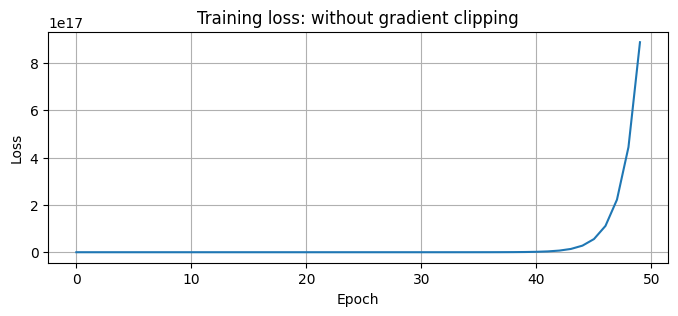

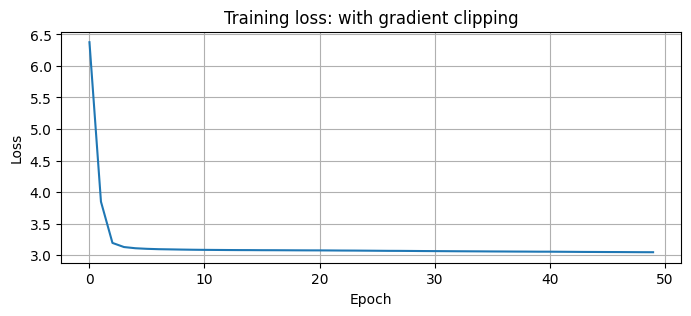

In [71]:
# Plot the training loss without gradient clipping
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(losses_no_clip)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training loss: without gradient clipping')
ax.grid(True)
plt.show()

# Plot the training loss with gradient clipping
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(losses_clipped)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training loss: with gradient clipping')
ax.grid(True)
plt.show()

Without clipping, isolated gradient spikes cause sudden jumps in the loss that can permanently destabilize training. With clipping, the same learning rate produces a stable and monotonically decreasing loss curve. The threshold is a **hyperparameter** that is typically set to a small value (e.g., 1.0 or 5.0). Gradient clipping is simple, computationally cheap, and widely used in practice.

### Layer Normalization

Batch normalization is highly effective in feedforward networks, considering a generic layer that produce a pre-activation vector:

$\displaystyle z = Wx + b \quad z \in \mathbb{R}^d$

the batch-normalization computes the mean and variance of the pre-activation **across the mini-batch**:

$\displaystyle \mu = \frac{1}{B} \sum_{i=1}^B z_i$   

$\displaystyle \sigma^2 = \frac{1}{B} \sum_{i=1}^B (z_i - \mu)^2$

then the pre-activations are normalized to have zero mean and unit variance:

$\displaystyle \hat z_i = \frac{z_i - \mu}{\sqrt{\sigma^2}}$

Since the gradient flowing through a layer depends strongly on the scale of the pre-activation, batch normalization explicitly enforces:

$\displaystyle \text{Var}(\hat z) = 1$

$\displaystyle E[\hat z] = 0$

Note that standard batch normalization also includes learnable scale and shift parameters that allow the network to recover the original distribution if needed, but we omit them here as they are not relevant to understanding why batch normalization struggles in recurrent networks.

In feedforward networks, this is extremely effective because each layer sees inputs whose **statistics are relatively stable**, and normalization is applied once per layer. However, in recurrent networks, this assumption breaks down. In RNN, the hidden state evolves over time:

$\displaystyle h(t) = \phi(W_h h(t-1) + W_x x(t))$

If normalization is applied **inside the recurrent layer**, in order to be used at every time step as in a feedforward network, the same batch statistics are used at every time step:

$\displaystyle z(t) = W_h h(t-1) + W_x x(t) \quad \hat z(t) = \frac{z(t) - \mu}{\sqrt{\sigma^2 + \varepsilon}}$

The problem is that the distribution of the pre-activation **changes with time**. Enforcing zero mean and unit variance with a single set of batch statistics across all time steps conflicts with the evolving temporal dynamics. This mismatch prevents batch normalization from accurately tracking the changing activation statistics, undermining its stabilizing effect. In practice, it is only marginally useful when **applied between recurrent layers**, where each layer operates on complete sequences and the normalization does not interfere directly with the temporal dynamics.

Batch normalization cannot be used as efficiently with RNNs. We cannot use it between time steps, only between recurrent layers. It was slightly better than nothing when applied between recurrent layers, but not within recurrent layers.

[**Layer normalization**](./papers/(2016)%20-%20Layer%20Normalization.pdf) often works better. It is similar to batch normalization, but instead of normalizing across the batch dimension, it normalizes across the features dimension:

$\displaystyle \mu(t) = \frac{1}{d} \sum_{j=1}^d z_j(t)$

$\displaystyle \sigma^2(t) = \frac{1}{d} \sum_{j=1}^d (z_j(t) - \mu(t))^2$

$\displaystyle \hat z_j(t) = \frac{z_j(t) - \mu(t)}{\sqrt{\sigma^2(t)}}$

Crucially, this normalization is performed independently at each time step, using only the statistics of the current hidden vector. As a result, it is perfectly compatible with the recurrent setting: the normalization adapts naturally as the hidden state evolves over time, without assuming stationarity across time steps or across batch elements. 

We can modify our simple RNN layer to include the normalization step:

In [72]:
def rnn_layer_forward_normalization(X, params):

    # Get dimensions (T: time steps, B: batch size, D: input dimension)
    T, B, D = X.shape

    # Get hidden dimension
    hidden_dim = params["b"].shape[0]

    # Get output dimension
    output_dim = params["b_y"].shape[0]

    # Initialize hidden states
    H = np.zeros((T, B, hidden_dim))
   
    # Initialize outputs
    Y_hat = np.zeros((T, B, output_dim))

    # Set to zero the first previous hidden state
    H_prev = np.zeros((B, hidden_dim))

    # Unroll through time
    for t in range(T):

        # Compute pre-activation
        Z = X[t] @ params["W_x"] + H_prev @ params["W_h"] + params["b"]

        # Compute layer normalization
        mu = np.mean(Z, axis=-1, keepdims=True)
        sigma2 = np.var(Z, axis=-1, keepdims=True)
        Z_hat = (Z - mu) / np.sqrt(sigma2 + 1e-8)

        # Apply activation function
        H[t] = phi(Z_hat)

        # Compute output
        Y_hat[t] = g(H[t], params["W_y"], params["b_y"])  

        # Update previous hidden state
        H_prev = H[t]

    # Return hidden states and outputs
    return H, Y_hat

To illustrate the effect of layer normalization, we compare the hidden state dynamics of the RNN with and without normalization. We deliberately use larger recurrent weights to **amplify instability**, making the difference clearly visible:

In [73]:
# Parameters
T = 30          
input_dim = 1        
hidden_dim = 20           
batch_dim = 1     

# Initialize RNN layer parameters
params = init_rnn_layer(input_dim, hidden_dim, output_dim)

# Use larger recurrent weights to provoke instability
params["W_h"] = np.random.normal(0.0, 0.5, size=(hidden_dim, hidden_dim))

# Input sequence
X = np.random.randn(T, batch_dim, input_dim) * 0.5

# Run both versions
H, _ = rnn_layer_forward(X, params)
H_ln, _ = rnn_layer_forward_normalization(X, params)

By plotting the norm of the hidden state vector over time, we can observe how the unnormalized network quickly saturates or diverges, while layer normalization keeps the hidden state dynamics stable throughout the sequence:

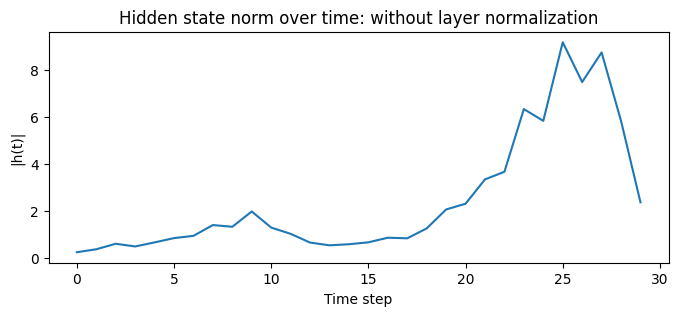

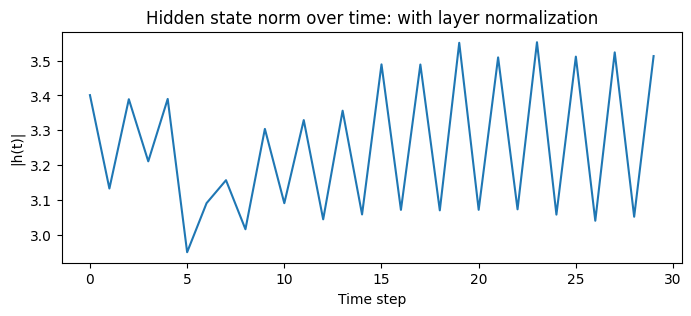

In [74]:
# Hidden state norm over time
h_norms = np.linalg.norm(H[:, 0, :], axis=1)
h_ln_norms = np.linalg.norm(H_ln[:, 0, :], axis=1)

# Plot hidden state norms over time without layer normalization
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(h_norms)
ax.set_xlabel('Time step')
ax.set_ylabel('|h(t)|')
ax.set_title('Hidden state norm over time: without layer normalization')
plt.show()

# Plot hidden state norms over time with layer normalization
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(h_ln_norms)
ax.set_xlabel('Time step')
ax.set_ylabel('|h(t)|')
ax.set_title('Hidden state norm over time: with layer normalization')
plt.show()

With these techniques, we can **alleviate** the exploding gradients problem and train an RNN much more efficiently.

## Short-Term Memory Problem

The vanishing gradient problem refers to the phenomenon whereby error signals propagated backward through a neural network **progressively shrink as they traverse many layers or time steps**. As a consequence, gradients associated with distant past inputs decay exponentially and become effectively zero, preventing the network from assigning credit to events that occurred far back in the sequence. This directly leads to the **short-term memory problem**: although relevant information may be present in the distant past, the network is unable to learn how to retain and use it, because the learning signal never reaches the parameters responsible for processing that information. In practice, the model **behaves as if it had only short-term memory**, regardless of how long the input sequence actually is. Crucially, this is not merely an optimization issue that can be fixed with better training heuristics. While careful initialization or advanced optimizers may slightly delay the onset of the problem, they do not eliminate it. The vanishing gradient problem in RNNs is **fundamentally structural**, and overcoming it requires **architectural solutions** designed to preserve gradient flow across time.

### Long Short-Term Memory (LSTM)

The [long short-term memory (LSTM)](./papers/(1997)%20-%20Long%20Short-Term%20Memory.pdf) neuron appears, from an input–output perspective, very similar to a standard recurrent neuron. Internally, however, its state is explicitly split into two components: **a short-term state** H(t), which interacts with the rest of the network, and **a long-term state** C(t), which acts as a persistent memory. The central idea behind the LSTM architecture is that the network can **learn to control the flow of information** by deciding **what to store in the long-term state**, what information to discard, and what portion of that stored content to expose at each time step. The long-term cell state can be thought of as a **conveyor belt** running through the entire sequence. **It flows straight along the time axis**, interacting only through carefully controlled operations. This structure makes it **easy for information to propagate forward almost unchanged**, allowing the network to **preserve relevant signals over long time spans**:

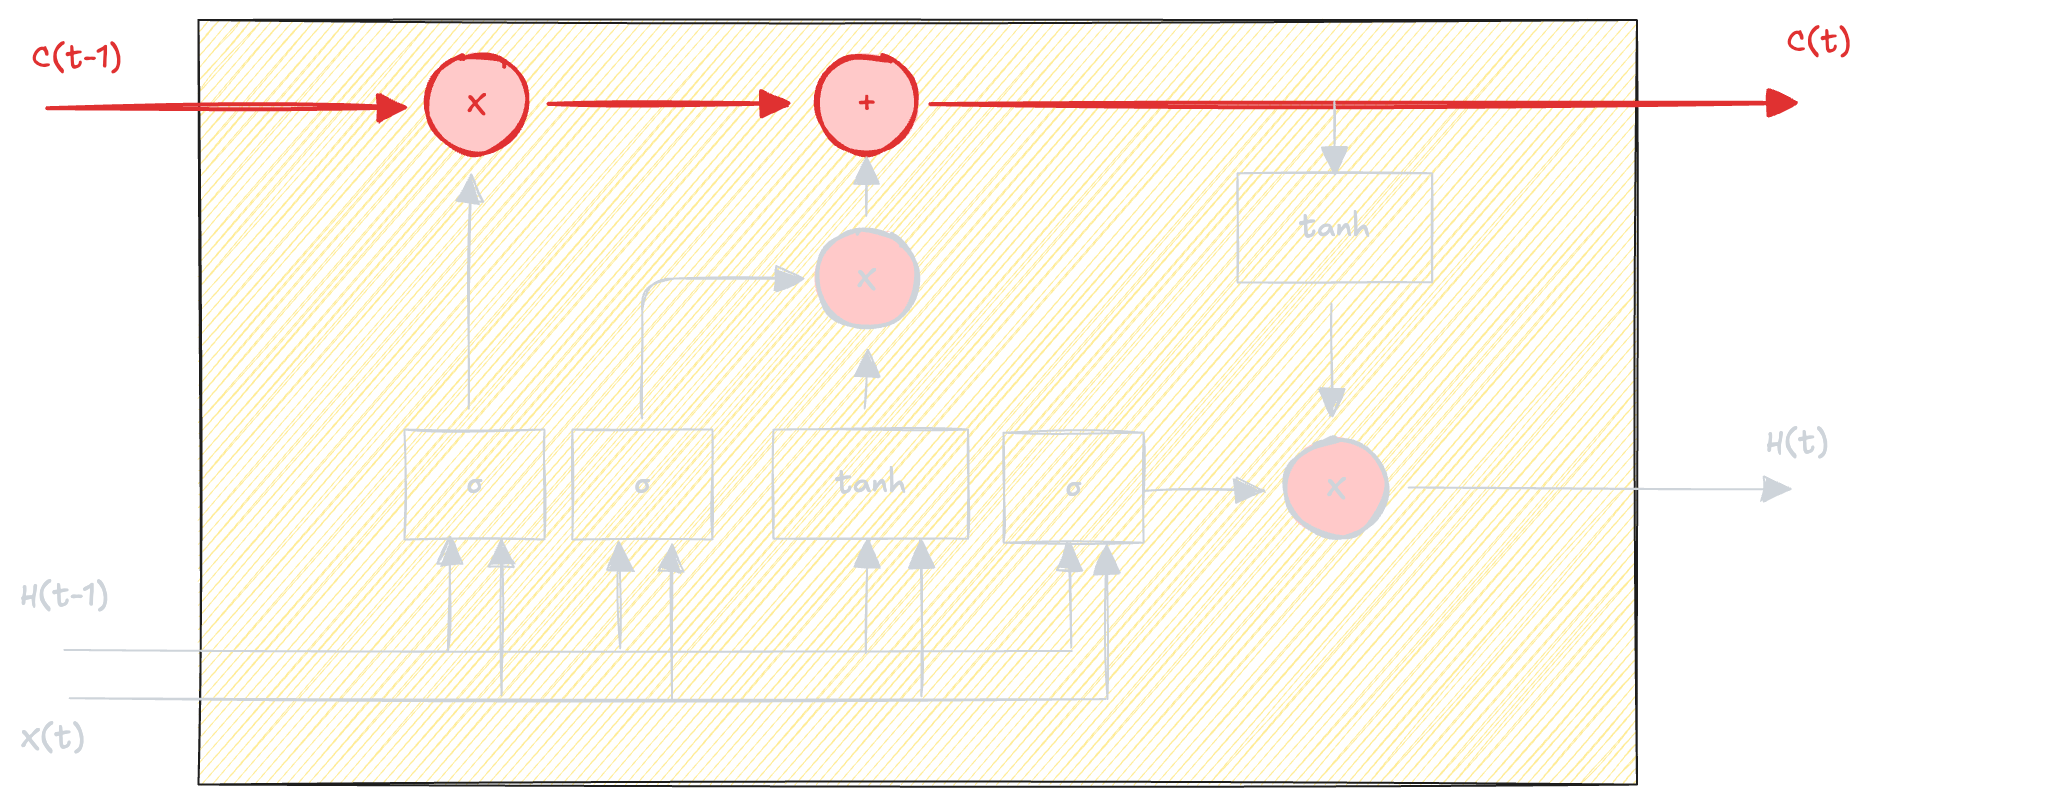

The LSTM cell can selectively **erase** or **incorporate** information into the long-term state, and this regulation is achieved through dedicated mechanisms known as **gates**. Each gate consists of a sigmoid-activated affine transformation whose output is applied element-wise to the signal through pointwise multiplication. The sigmoid function produces values in the interval [0,1], which can be interpreted as continuous control coefficients: **values close to zero suppress a component, while values close to one allow it to pass almost unchanged**. The first step is to decide what information we’re going to throw away from the long-term cell state. This decision is made by a sigmoid layer called **the forget gate layer**:

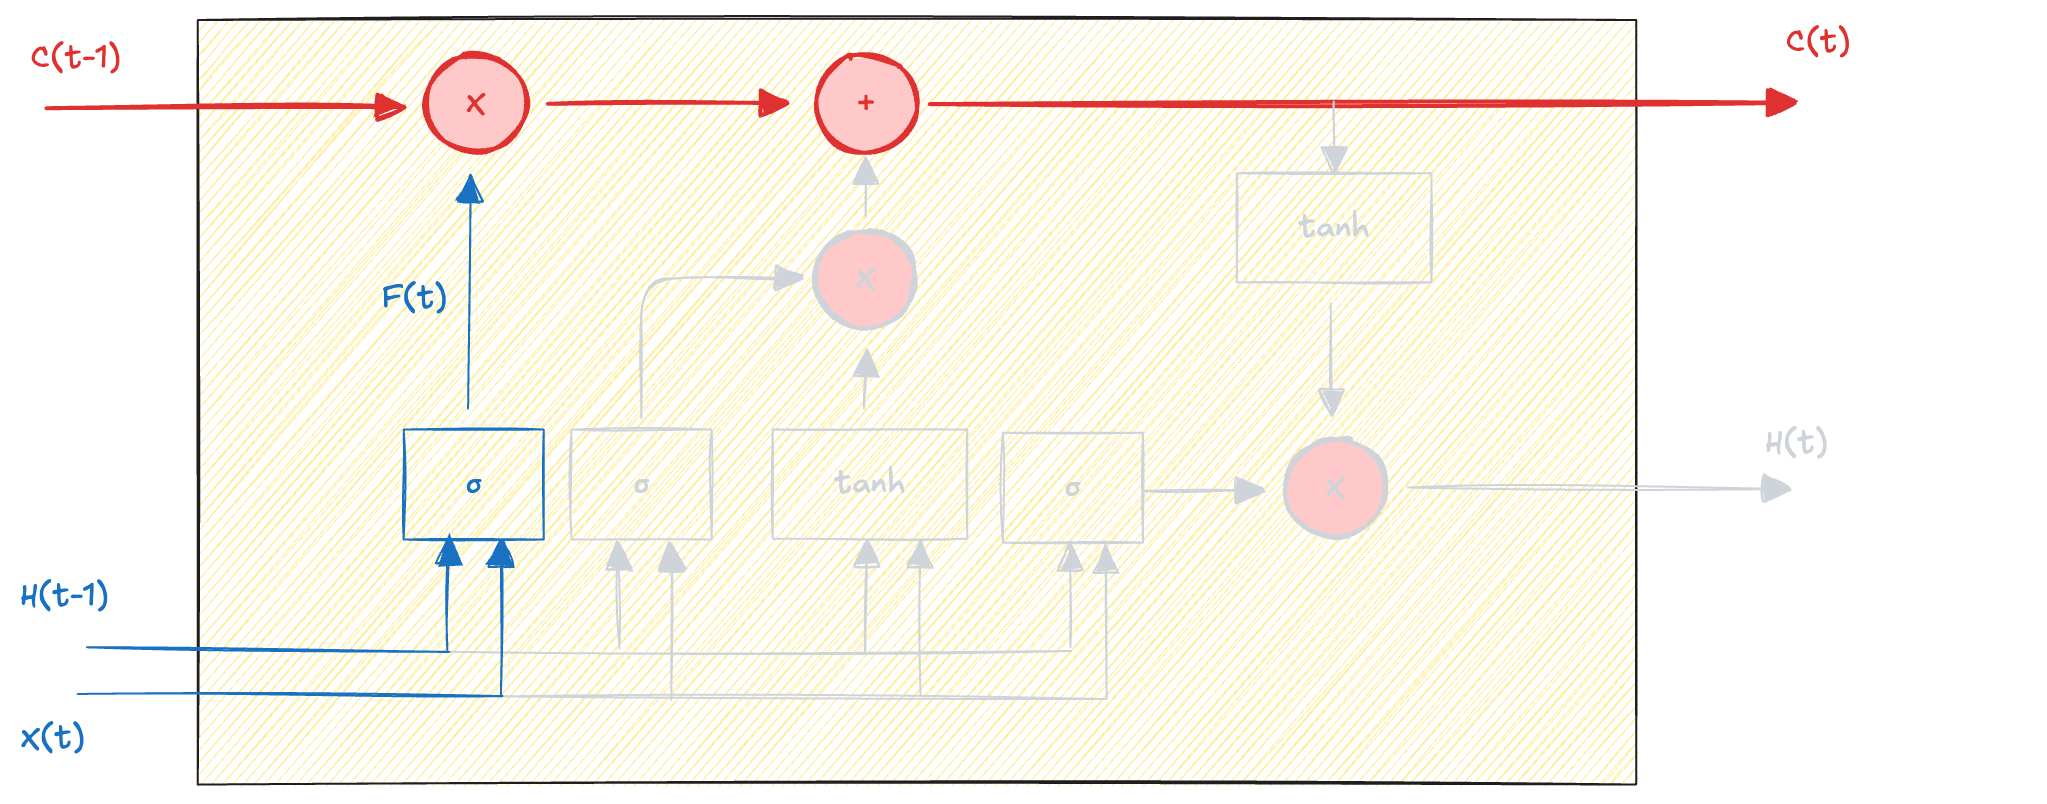

$\displaystyle F(t)=\sigma([H(t-1), X(t)] \cdot W_f + b_f)$

An intuitive way to understand the forget gate is to think of the long-term state as a structured memory notebook that accumulates information over time. Each component corresponds to a specific **latent feature** the network has learned to track, such as a slowly varying trend, a seasonal phase, or a contextual condition. Imagine we are modeling daily electricity consumption in a building. Suppose that, over many days, the LSTM has learned to encode in one component of the long-term state whether the building is in a "winter heating regime" and in another component whether it is in a "weekday operational mode". These pieces of information are not directly observable, they are **internal abstractions** encoded in different coordinates of the cell state. Now consider what happens when spring arrives. The external input X (e.g., temperature) and the short-term hidden state H(t-1) jointly signal that the heating regime is no longer relevant. The forget gate computes for the component encoding the heating regime a value close to 0. This means: "that feature is no longer useful, suppress it". For the component encoding the weekday pattern, the gate might output a value close to 1, meaning: "this is still relevant, keep it".For other components, the values might lie somewhere in between, partially attenuating stale information. In this sense, the forget gate allows the LSTM to control the **effective time scale of each latent feature**: some components can persist for hundreds of time steps, while others are intentionally erased as soon as they become irrelevant.

After deciding what to forget, the LSTM must determine **what new information deserves to be written into long-term memory**. This operation is conceptually distinct from forgetting. Forgetting controls **persistence**, writing controls **plasticity**:

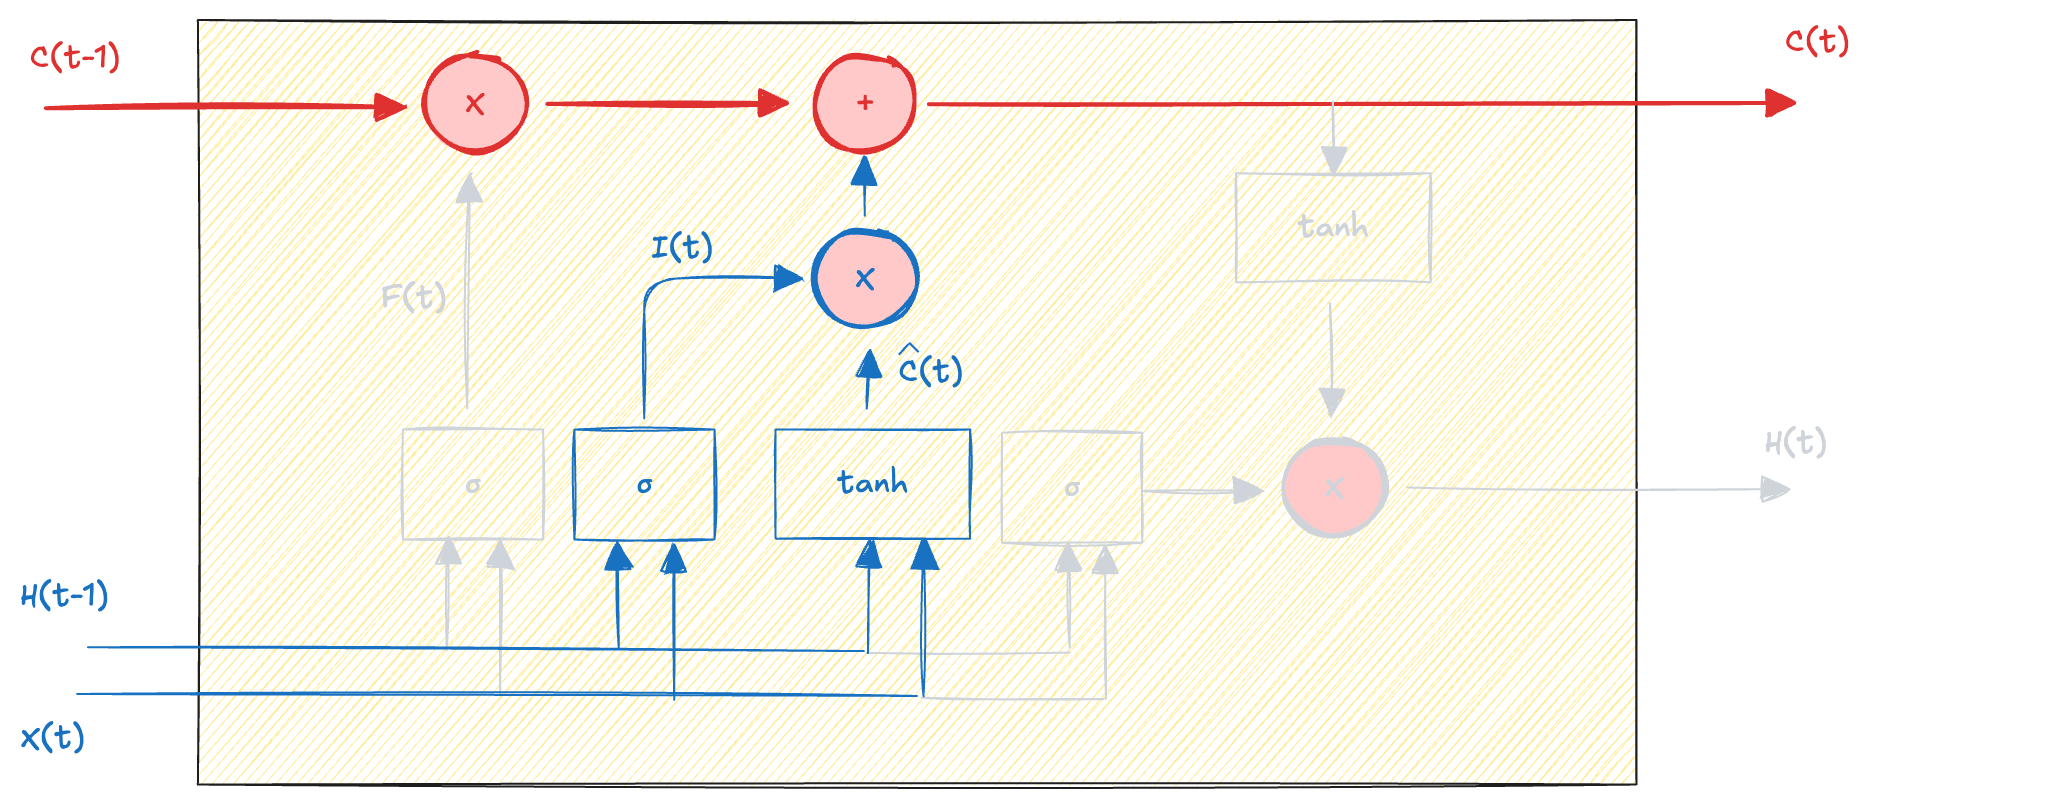

The update mechanism is composed of two coordinated components. The first is the **input gate**:

$\displaystyle I(t) = \sigma([H(t-1), X(t)] \cdot W_i + b_i)$

Each component of I(t) acts as a continuous **write-enable signal**: values close to zero prevent modification of that coordinate of the memory, while values close to one allow a substantial update. The second component is the **candidate state**:

$\displaystyle \hat{C}(t) = \tanh([H(t-1), X(t)] \cdot W_c + b_c)$

A vector of **potential content that could be stored**. The hyperbolic tangent ensures that these candidate values are bounded and centered, providing a stable signal that can either increase or decrease the corresponding memory components. Then we combine these two terms to create an update to the state:

$\displaystyle C(t) = F(t) \ast C(t-1) + I(t) \ast \hat{C}(t)$

This equation reveals the internal logic of the LSTM. The previous memory is first attenuated by the forget gate, implementing selective decay. Then, new information is added, but only in the coordinates where the input gate authorizes modification. The update is therefore additive and coordinate-wise, which makes the cell state behave like a **controlled integrator**.

Let us continue with the daily electricity consumption example. Spring has arrived and the forget gate has already reduced the component associated with winter heating, because outdoor temperature and recent patterns signal that heating is no longer dominant. Now consider what happens when a new external condition appears, for example the activation of an air-conditioning system due to an unexpected heatwave. The current input contains high temperature readings and possibly calendar information. The hidden state summarizes the recent load dynamics. From these signals, the network constructs a candidate vector with a coordinate that may encode "cooling regime activation". However, the model should not blindly overwrite everything. The input gate decides where writing is appropriate. For the coordinate corresponding to winter heating, the input gate may output a value close to zero, because that feature is no longer relevant and should not be reintroduced. For the coordinate representing cooling behavior, the gate may output a value close to one, allowing the candidate signal to strongly modify memory. For other components, such as the weekday pattern, the gate may output intermediate values, preserving stability while allowing mild adaptation.

Summarizing, the forget gate applies controlled decay to outdated latent factors, while the input gate authorizes the injection of new latent drivers inferred from the data. The candidate vector proposes possible explanatory factors; the gate decides how much trust to place in each proposal.

Once the long-term state has been updated, the LSTM must determine what portion of that internal memory should influence the network’s behavior at the current time step. The state is a private memory: it can accumulate rich contextual information over long horizons. The hidden state, instead, is **the signal that is exposed** to the next layers or to the output. The output gate regulates the transformation from memory to action:

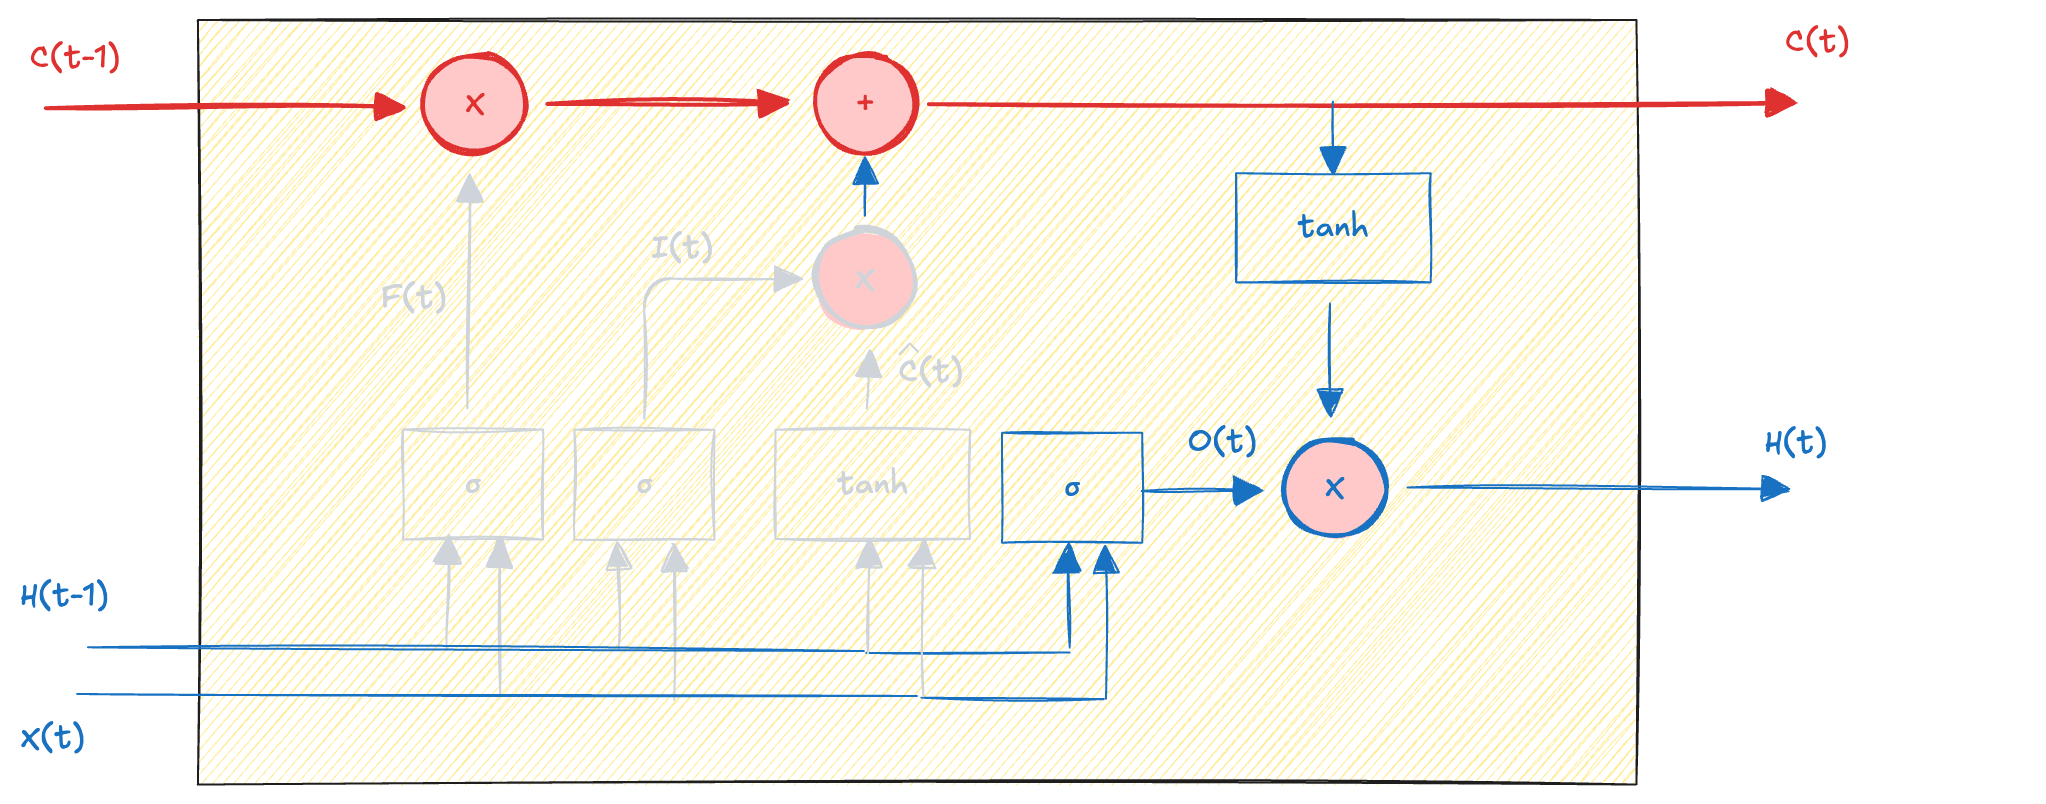

$\displaystyle O(t) = \sigma([H(t-1),X(t)] \cdot W_o + b_o)$

Each coordinate of this vector acts as a continuous filter, deciding **how much of the corresponding memory component should be revealed**. The final hidden state is then computed as:

$\displaystyle H(t) = O(t) \ast \tanh(C(t))$

Before exposure, the memory is passed through a hyperbolic tangent nonlinearity to ensure numerical stability and prevents uncontrolled growth of the hidden representation.

The structure is conceptually simple: the transformed memory is modulated element-wise by the output gate. What is important is the **separation between what is stored and what is currently expressed**.

Returning to the daily electricity consumption example, suppose the cell state currently encodes several latent components: one representing a cooling regime activated by high temperatures, another capturing the weekday operational pattern of the building, and another reflecting a slow-moving demand trend. At a particular hour, the task is to predict the next load value. If the outside temperature is extremely high, the cooling-related component of the long-term state becomes critical for forecasting. The output gate can assign a coefficient close to one to that coordinate, allowing it to strongly influence the state H. At the same time, the slow annual trend component may be less informative for short-horizon prediction, so the gate may attenuate it. The information is **still stored in memory**, but it does **not dominate the current output**.

To highlight the ability of the LSTM to exploit longer-range dependencies, we increase the input window from T to a larger value. With a longer context, the network has access to multi-week patterns that the vanilla RNN cannot effectively retain due to vanishing gradients. We rebuild the training sequences accordingly and use PyTorch's **nn.LSTM module**, which replaces nn.RNN with minimal changes. Before training the LSTM, we check whether a **hardware accelerator is available** (such as an NVIDIA GPU via CUDA or an Apple Silicon GPU via MPS) and move the model and data to it. Since the LSTM processes longer sequences, leveraging GPU acceleration can significantly reduce training time compared to CPU-only execution:

In [75]:
# Select the best available device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [76]:
# Longer sequence length to exploit LSTM memory (168 hours = 1 week)
T_long = 168

# Create input-target train sequences with the longer window
X_train_long, Y_train_long = make_sequences(power_mulvar_train, T_long)
Y_train_long = Y_train_long[:, :, 0:1] 

# Define LSTM model dimensions
input_size  = 4
hidden_size = 20
num_layers  = 3
output_size = 1

# Define the LSTM recurrent layers
lstm = nn.LSTM(input_size=input_size,
               hidden_size=hidden_size,
               num_layers=num_layers)

# Define the fully connected output layer
fc_lstm = nn.Linear(hidden_size, output_size)

# Move model layers to device
lstm = lstm.to(device)
fc_lstm = fc_lstm.to(device)

# Define the optimizer
optimizer_lstm = torch.optim.Adam(list(lstm.parameters()) + 
                                  list(fc_lstm.parameters()), 
                                  lr=1e-3)

# Define the forward function
def forward_lstm(X):
    out, (h_n, c_n) = lstm(X)    
    Y_hat = fc_lstm(out)
    return Y_hat

The training procedure is identical to the one used for the deep RNN: we iterate over mini-batches, compute the loss over the supervised time steps, and update the parameters via backpropagation:

In [77]:
# Training parameters
epochs = 5
batch_size = 32
M = T_long

# Set the model to training mode
lstm.train()
fc_lstm.train()

# Run the training loop
for epoch in range(epochs):

    # Epoch losses
    epoch_losses = []

    # Shuffle indices
    indices = np.random.permutation(X_train_long.shape[1])
    
    for start_idx in range(0, len(indices), batch_size):

        # Get batch indices
        batch_idx = indices[start_idx:start_idx + batch_size]
    
        # Get batch (T, B, D)
        Xb = torch.as_tensor(X_train_long[:, batch_idx, :], dtype=torch.float32).to(device)
        Yb = torch.as_tensor(Y_train_long[:, batch_idx, :], dtype=torch.float32).to(device)

        # Clear previous gradients
        optimizer_lstm.zero_grad()
    
        # Forward pass
        Y_hat = forward_lstm(Xb)

        # Compute loss
        loss = torch.sum((Y_hat[-M:] - Yb[-M:]) ** 2)

        # Backward pass
        loss.backward()
    
        # Update parameters
        optimizer_lstm.step()
        
        # Append loss to epoch losses
        epoch_losses.append(loss.item())

    # Calculate mean epoch loss
    epoch_loss = np.mean(epoch_losses)

    # Print epoch loss
    print(f"\rEpoch {epoch+1:02d}/{epochs} | Train loss: {epoch_loss:.6f}", end="", flush=True)

Epoch 05/5 | Train loss: 15.471387

We evaluate the trained LSTM on the test period using the same walk-forward procedure adopted for the previous models. For each test hour, the model receives the preceding T_long observations as input and produces a one-step-ahead forecast. Since the LSTM was trained with a longer input window (T_long covers one full week), it can in principle leverage both daily and weekly patterns when generating its predictions. All forecasts are unnormalized before computing the MAPE, ensuring a fair comparison with the earlier models:

In [78]:
# List to store one-step-ahead predictions
y_preds = []

# Put model in evaluation mode
lstm.eval()
fc_lstm.eval()

with torch.no_grad():

    # Walk-forward evaluation
    for step in power_test_period:

        # Extract the last T observations before "day" and normalize
        x_window = power_hourly[cols].loc[:step].iloc[-T_long-1:-1].to_numpy() / 10

        # Reshape to (T, B=1, D=1)
        x_tensor = torch.as_tensor(x_window.reshape(T_long, 1, 4), dtype=torch.float32).to(device)

        # Forward pass through the LSTM
        output = forward_lstm(x_tensor)

        # One-step-ahead prediction for this day
        y_pred = float(output[-1, 0, 0].cpu().item())

        # Store the prediction
        y_preds.append(y_pred)

# Convert predictions to a time-indexed Series and unnormalize
y_preds_lstm = pd.Series(y_preds, index=power_test_period) * 10

# Compute LSTM MAPE
mape_lstm = ((y_preds_lstm - power_test) / power_test).abs().mean()

# Display the MAPE results
print(f"SARIMA MAPE: {mape_sarima_power:.2%}")
print(f"RNN MAPE: {mape_rnn:.2%}")
print(f"Deep RNN MAPE: {mape_deep_rnn:.2%}")
print(f"Deep RNN Multivariate MAPE: {mape_deep_rnn_mulvar:.2%}")
print(f"LSTM MAPE: {mape_lstm:.2%}")

SARIMA MAPE: 75.54%
RNN MAPE: 51.78%
Deep RNN MAPE: 56.02%
Deep RNN Multivariate MAPE: 43.20%
LSTM MAPE: 38.96%


We can now visually compare the LSTM forecasts with the true power consumption over the test period:

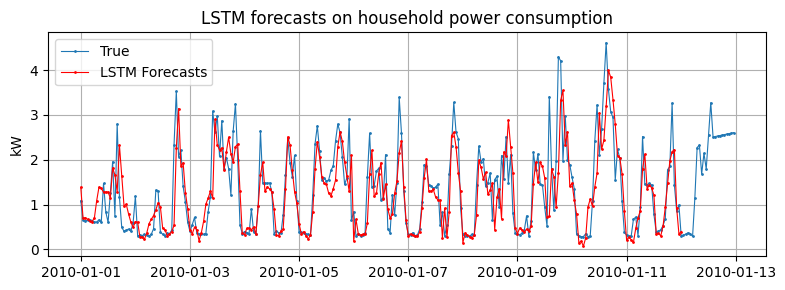

In [79]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(power_test.index, power_test.values, 
        marker=".", markersize=2, label="True", linewidth=0.8)

ax.plot(y_preds_lstm.index, y_preds_lstm.values, 
        color="red", marker=".", markersize=2, label="LSTM Forecasts", linewidth=0.8)

ax.set_ylabel("kW")
ax.set_title("LSTM forecasts on household power consumption")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

### Gated Recurrent Unit (GRU)

There are several [variants of the LSTM cell](./papers/(2017)%20-%20LSTM%20-%20A%20Search%20Space%20Odyssey.pdf). One particularly popular variant is the [**Gated Recurrent Unit (GRU) cell**](./papers/(2014)%20-%20Learning%20Phrase%20Representations%20using%20RNN%20Encoder-Decoder%20for%20Statistical%20Machine%20Translation.pdf), that can be understood as a simplification of the LSTM architecture, designed to **preserve its essential dynamical behavior** while **reducing structural complexity**. Instead of maintaining the two separate state variables (long-term state and short-term hidden state), the GRU collapses them into a **single vector**. This choice is not merely cosmetic: it reflects the idea that **memory and output need not be handled by two distinct storage mechanisms**. A single state can simultaneously act as internal memory and as the quantity exposed to the rest of the network:

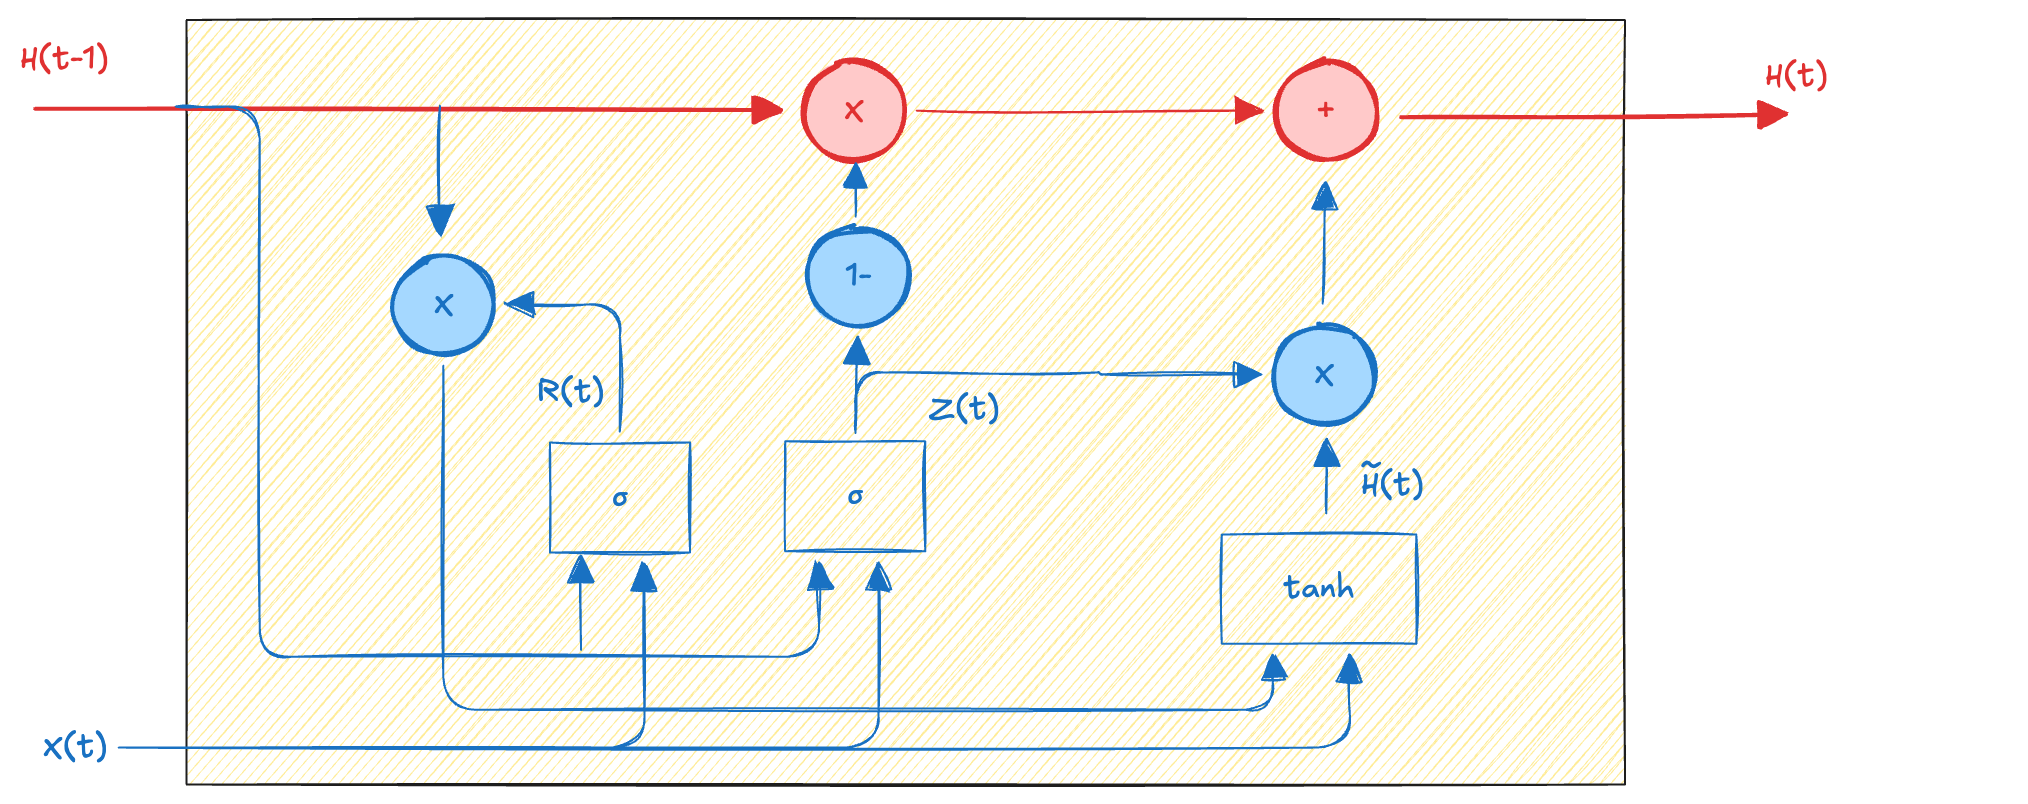

The GRU replaces the three LSTM gates (input, forget, output) with only two gating mechanisms. The **update gate** Z(t) determines **how much of the previous hidden state should be preserved in the final state**. Conceptually, this gate merges the roles of the LSTM forget and input gates. It answers a different question: how much of the old state should I keep, and how much should I replace with the new candidate?

$\displaystyle Z(t) = \sigma([H(t-1), X(t)] \cdot W_z + b_z)$

The **reset gate** R(t) controls **how much of the previous hidden state should influence the candidate state**:

$\displaystyle R(t) = \sigma([H(t-1), X(t)] \cdot W_r + b_r)$

Intuitively, this gate answers the question: when computing new information, how much of the past should I look at? If a component is close to zero, the corresponding dimension of the previous state is essentially ignored when forming the candidate representation. In other words, the network can locally "reset" part of its memory. This mechanism is especially useful when the model encounters a structural change in the sequence, such as a regime shift in a time series. For example, in a daily electricity consumption scenario, a sudden policy change or seasonal transition might make older consumption patterns temporarily irrelevant. The reset gate allows the unit to disregard that stale context when constructing the new candidate state:

$\displaystyle 	\tilde{H}(t) = \tanh([R(t) \ast H(t-1),X(t)] \cdot  W_h + b_h)$

The final state is computed as a convex interpolation:

$\displaystyle H(t) = (1 - Z(t)) \ast H(t-1) + Z(t) \ast \tilde{H}(t)$

This equation is extremely revealing from a dynamical systems perspective. If a component of Z(t) is close to zero, the corresponding dimension of the hidden state is copied forward almost unchanged. The model is effectively maintaining memory over time, creating a near-identity mapping that helps mitigate vanishing gradients. If instead a component of Z(t) is close to one, the unit overwrites that dimension with newly computed information. Thus, the GRU continuously **blends persistence and innovation**. 

In the daily electricity consumption example, suppose the model has learned a stable weekly pattern. During ordinary days, the update gate may remain small, allowing the hidden state to propagate the established pattern forward with minimal modification. However, when an unusual event occurs, such as a holiday or extreme weather, Z(t) can increase, enabling the state to incorporate new information rapidly. The network dynamically decides whether continuity or adaptation is more appropriate.

We can use PyTorch to implement a GRU solution with minimal changes to the LSTM code. The same training loop, evaluation procedure, and plotting code can be reused. The only substantive difference is in the forward function: GRU returns a single hidden state whereas LSTM returns two states because it carries both a hidden state and a cell state.

Unfortunately, the GRU implementation in PyTorch for MPS is currently not optimized and runs significantly slower than the LSTM version. If you have access to an NVIDIA GPU, you can switch to CUDA to achieve much faster training times. Otherwise, we can use the CPU:

In [80]:
device = torch.device("cpu")

In [81]:
# Define the GRU recurrent layers
gru = nn.GRU(input_size=input_size,
             hidden_size=hidden_size,
             num_layers=num_layers)

# Define the fully connected output layer
fc_gru = nn.Linear(hidden_size, output_size)

# Move model layers to device
gru = gru.to(device)
fc_gru = fc_gru.to(device)

# Define the optimizer
optimizer_gru = torch.optim.Adam(list(gru.parameters()) +
                                 list(fc_gru.parameters()),
                                 lr=1e-3)

# Define the forward function
def forward_gru(X):
    out, h_n = gru(X)
    Y_hat = fc_gru(out)
    return Y_hat

The training loop:

In [82]:
# Set the model to training mode
gru.train()
fc_gru.train()

# Run the training loop
for epoch in range(epochs):

    # Epoch losses
    epoch_losses = []

    # Shuffle indices
    indices = np.random.permutation(X_train_long.shape[1])

    for start_idx in range(0, len(indices), batch_size):

        # Get batch indices
        batch_idx = indices[start_idx:start_idx + batch_size]

        # Get batch (T, B, D)
        Xb = torch.as_tensor(X_train_long[:, batch_idx, :], dtype=torch.float32).to(device)
        Yb = torch.as_tensor(Y_train_long[:, batch_idx, :], dtype=torch.float32).to(device)
       
        # Clear previous gradients
        optimizer_gru.zero_grad()

        # Forward pass
        Y_hat = forward_gru(Xb)
        
        # Compute loss
        loss = torch.sum((Y_hat[-M:] - Yb[-M:]) ** 2)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer_gru.step()

        # Append loss to epoch losses
        epoch_losses.append(loss.item())

    # Calculate mean epoch loss    
    epoch_loss = np.mean(epoch_losses)

    # Print epoch loss
    print(f"\rEpoch {epoch+1:02d}/{epochs} | Train loss: {epoch_loss:.6f}", end="", flush=True)

Epoch 05/5 | Train loss: 14.665000

And the evaluation loop:

In [83]:
# List to store one-step-ahead predictions
y_preds = []

# Put model in evaluation mode
gru.eval()
fc_gru.eval()

with torch.no_grad():

    # Walk-forward evaluation
    for step in power_test_period:

        # Extract the last T observations before "day" and normalize
        x_window = power_hourly[cols].loc[:step].iloc[-T_long-1:-1].to_numpy() / 10
        
        # Reshape to (T, B=1, D=1)
        x_tensor = torch.as_tensor(x_window.reshape(T_long, 1, 4), dtype=torch.float32).to(device)
        
         # Forward pass through the GRU
        output = forward_gru(x_tensor)

        # One-step-ahead prediction for this day
        y_pred = float(output[-1, 0, 0].cpu().item())

        #Store the prediction
        y_preds.append(y_pred)

# Convert predictions to a time-indexed Series and unnormalize
y_preds_gru = pd.Series(y_preds, index=power_test_period) * 10

# Compute LSTM MAPE
mape_gru = ((y_preds_gru - power_test) / power_test).abs().mean()

# Display the MAPE results
print(f"LSTM MAPE: {mape_lstm:.2%}")
print(f"GRU MAPE: {mape_gru:.2%}")

LSTM MAPE: 38.96%
GRU MAPE: 40.57%


GRU has similar performance to LSTM on many tasks, but it is computationally cheaper and often converges faster. The choice between LSTM and GRU is typically empirical: while LSTM's separate memory and hidden states can provide more representational flexibility, GRU's simpler structure can be advantageous when computational resources are limited or when the task does not require the full expressiveness of an LSTM.

### WaveNet Architecture

Despite their gating mechanisms, LSTM and GRU architectures often struggle when dependencies extend across **hundreds or thousands of time steps**. In long sequences, such as **raw audio waveforms**, where meaningful acoustic structures (phonemes, syllables, prosody) unfold over very different temporal scales, the recurrent state must propagate information through many successive transitions, and this repeated transformation can progressively attenuate or distort long-range signals. This limitation motivates architectures such as 1D convolutional neural networks, which expand their receptive field hierarchically and can **integrate information over long temporal horizons** without relying on step-by-step state propagation. A 1D convolutional layer applies a set of **learnable filters** (**kernels**), each of which slides along the temporal axis and computes local weighted sums:

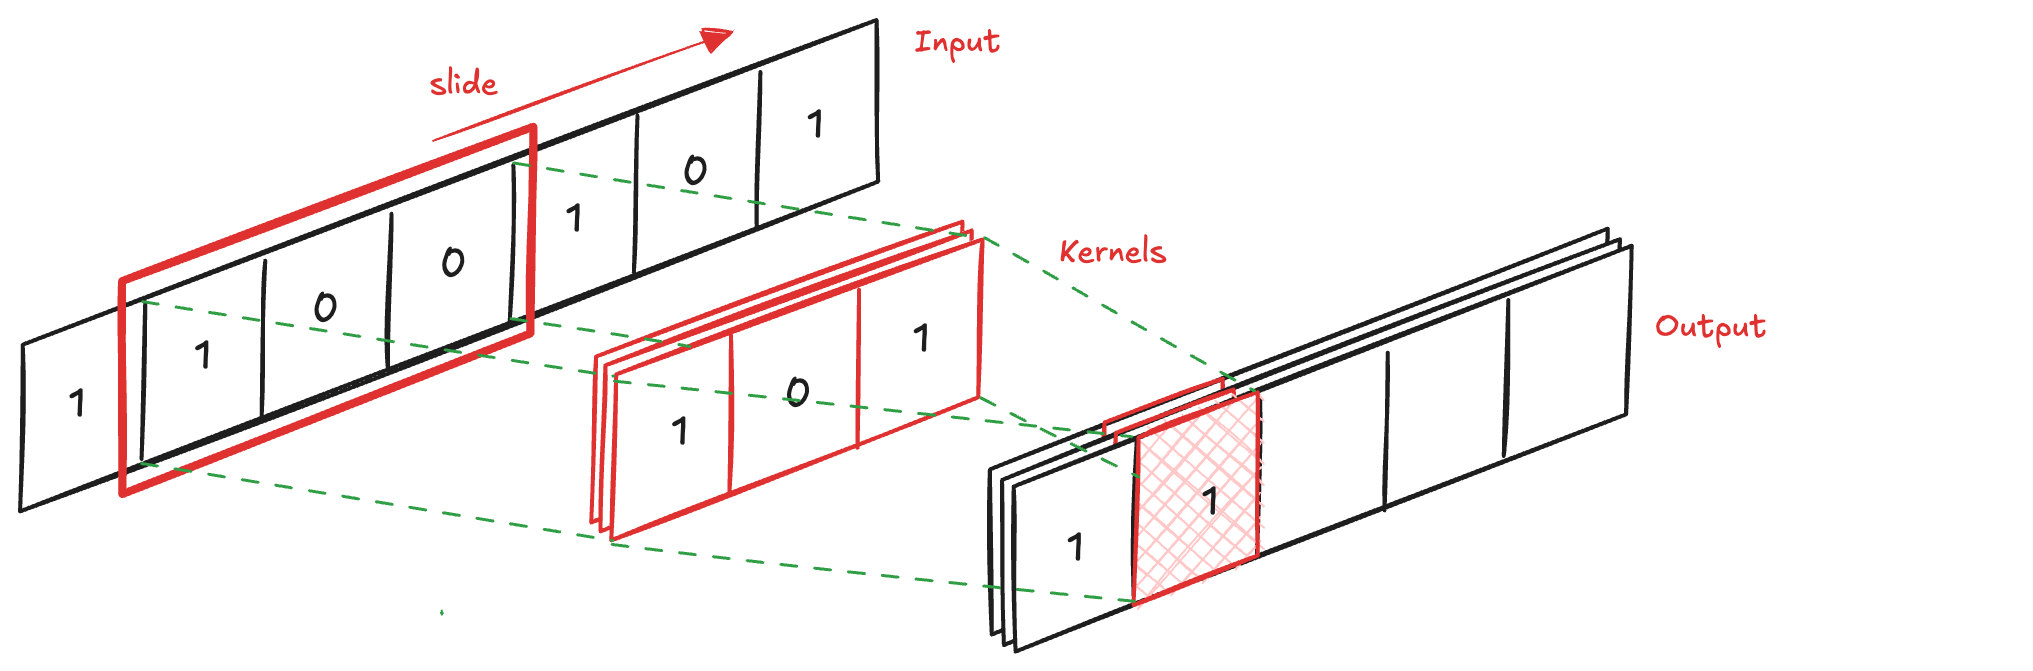

Formally, consider a single filter with kernel size k, at time position t, the convolution computes

$\displaystyle y_t = \sum_{i=0}^{k-1} \sum_{d=1}^{D} W_{i,d} \, x_{t-i,d} + b$

This expression makes the mechanism explicit: the output at time t is a linear combination of the last k input time steps (across all channels), weighted by shared parameters.

There are **three fundamental structural properties**. First, **local connectivity**. Each output depends only on a local temporal window of size k. The layer assumes that meaningful patterns are local—short motifs, short-term dependencies, short oscillations. Second, **weight sharing**. The same kernel is used at every temporal position. This encodes a form of translation invariance: if a pattern appears at different time locations, the same filter can detect it (implicitly assuming approximately stationarity). Third, **multiple filters**, we use F filters, producing an output tensor. Each filter learns to detect a **different type of local pattern**. After convolution, a nonlinear activation such as ReLU is applied elementwise.

Intuitively, we can think of a 1D convolution as a **learnable pattern detector sliding over time**. If the kernel size is small, the layer captures short-term micro-structure. If we **stack multiple layers**, the effective receptive field increases. For example, two layers with kernel size 3 do not merely see 3 time steps, they can integrate information across 5 time steps:

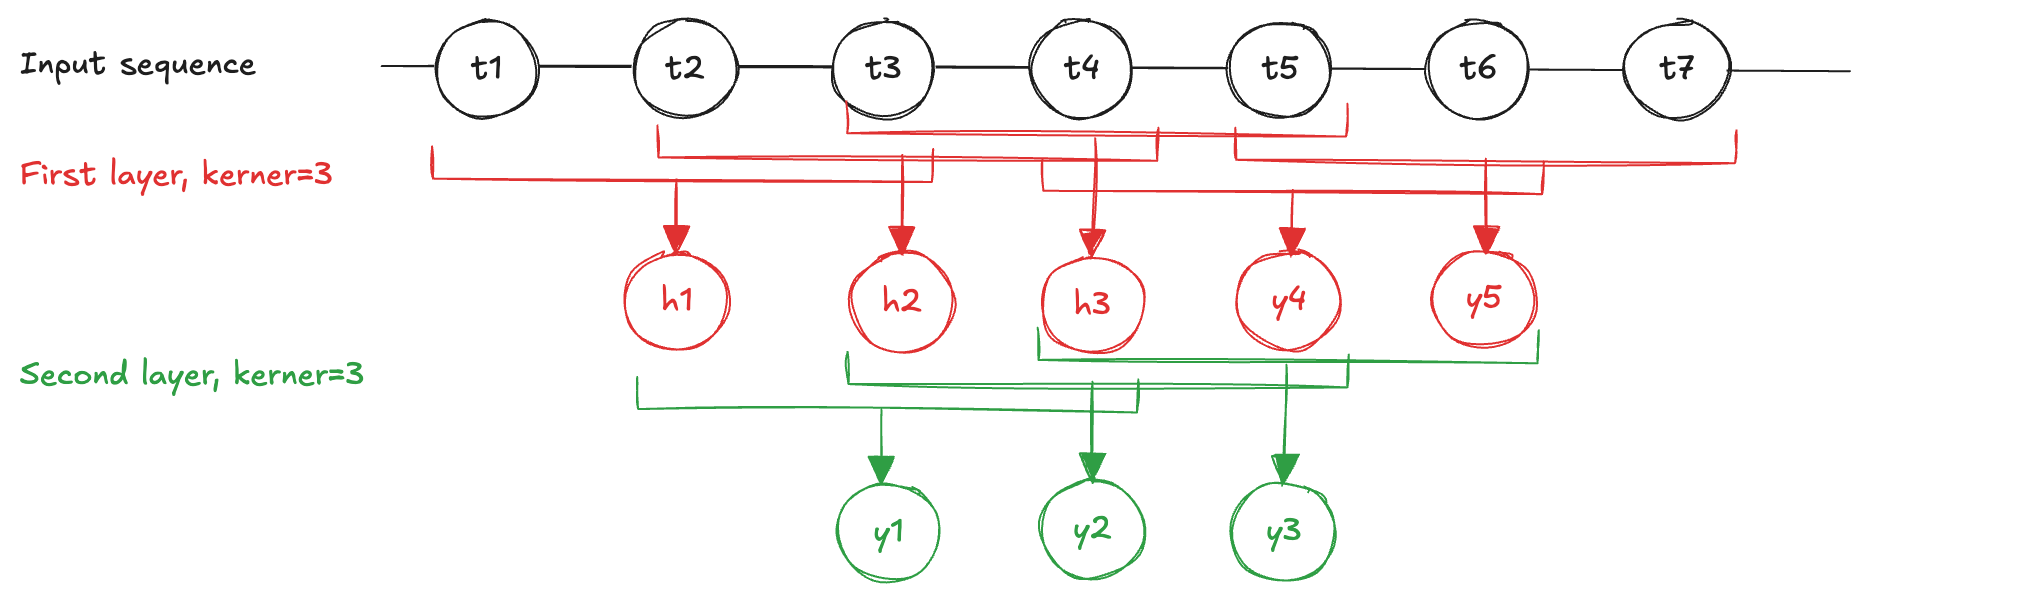

Depth builds **hierarchical temporal abstractions**: early layers detect simple shapes, deeper layers combine them into more complex temporal motifs.

Two hyperparameters strongly affect behavior. The **stride** determines how much the filter shifts at each step. If stride is greater than 1, the output is downsampled, effectively reducing temporal resolution and increasing computational efficiency. The **padding** controls boundary behavior:

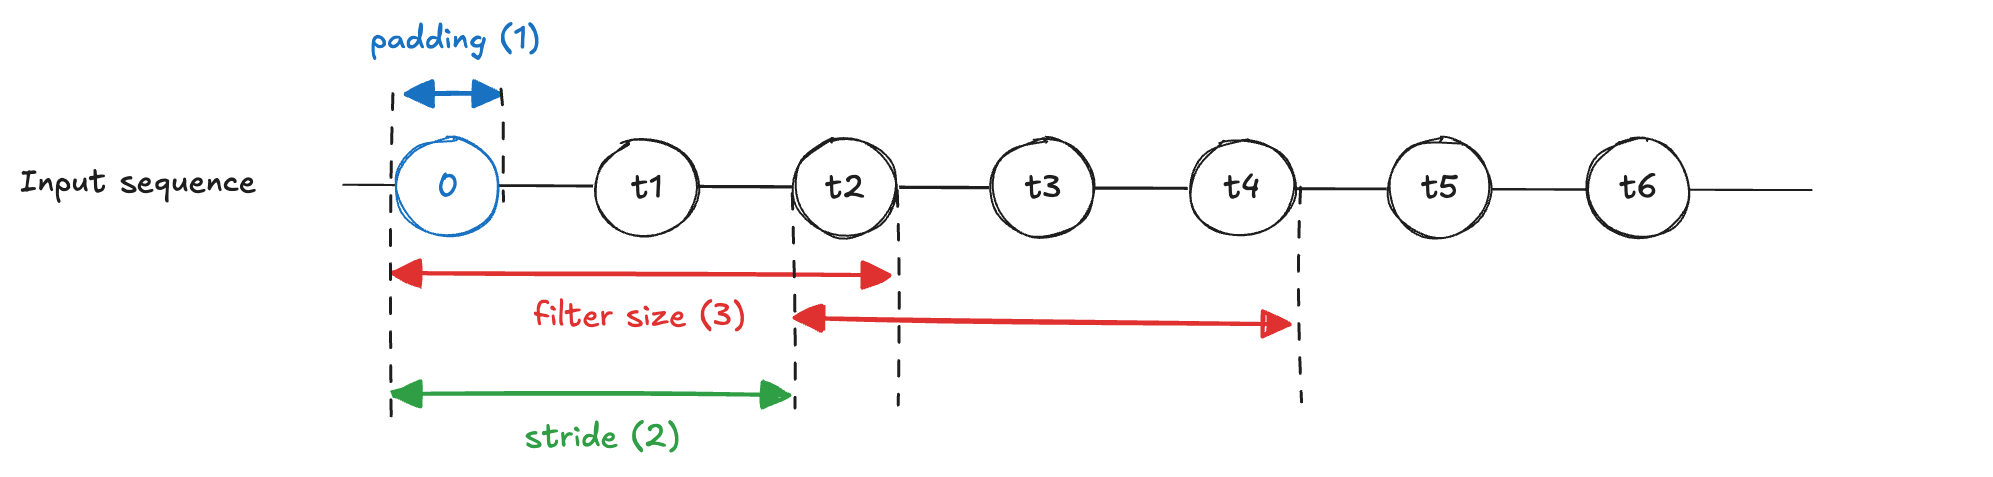

To connect this to intuition, consider daily electricity consumption. A 1D convolution with kernel size 7 can learn to detect weekly patterns. A different filter might learn short-term trends over 2–3 days. Stacking layers allows the network to combine these into higher-level temporal features, such as interactions between weekly seasonality and longer-term trends.

However, this is not sufficient. For example, if we want to model a signal such as a 16 kHz audio waveform, even a few hundred milliseconds correspond to thousands of time steps. Capturing such long-range structure with ordinary convolutions would require either very large kernels or extremely deep networks.
The [**WaveNet architecuture**](./papers/(2016)%20-%20WaveNet%20-%20A%20Generative%20Model%20for%20Raw%20Audio.pdf) addresses this by introducing two key innovations.

The first constraint is **causality**, the prediction at time t **must depend only on past samples** and the filter is aligned so that the output at time t only sees previous inputs. The second innovation is **dilation**. Instead of applying contiguous kernels at every layer, WaveNet uses dilated convolutions, where the filter skips inputs with a fixed step. If the dilation factor doubles at each successive layer (1, 2, 4, 8, …), the receptive field grows exponentially with depth:

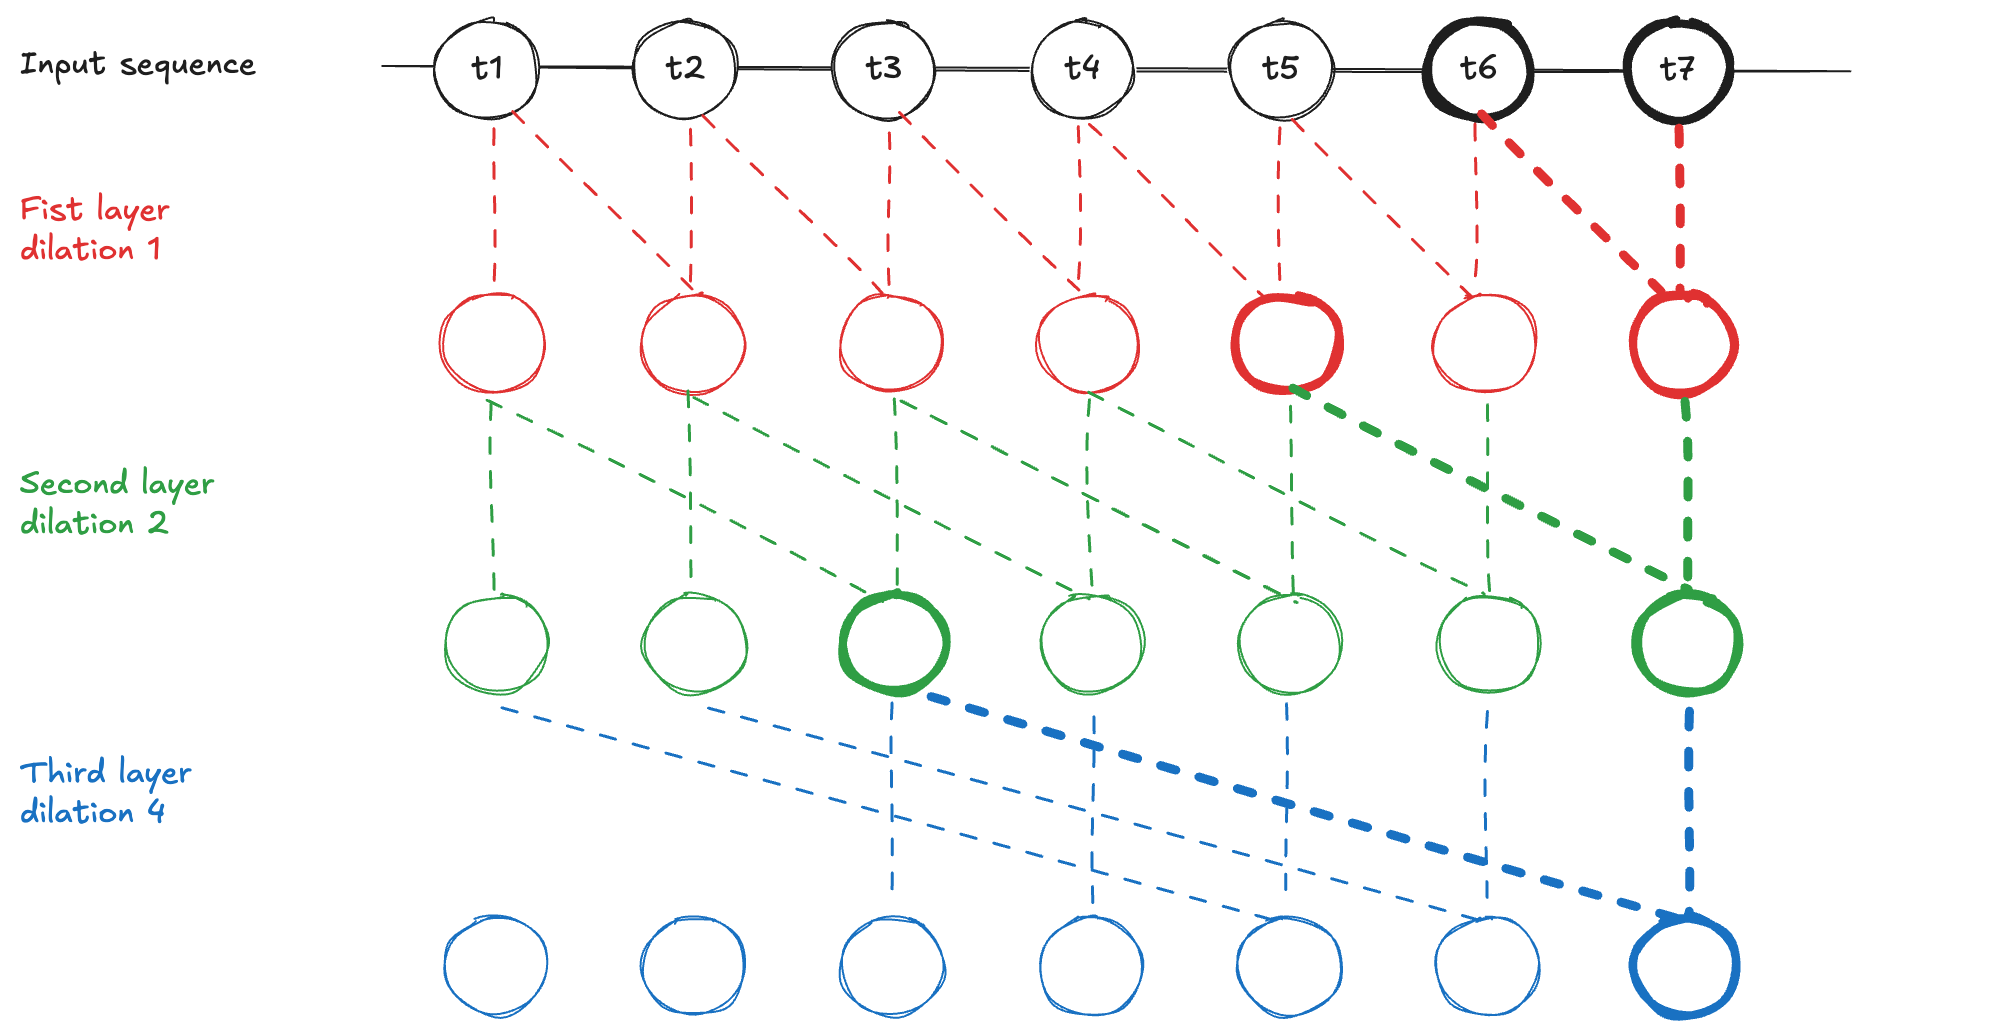

Intuitively, the first layer captures very local waveform structure, the next layer integrates slightly broader temporal context, and deeper layers aggregate information over increasingly long time spans. With only a modest number of layers, the network can "see" thousands of past samples. This is **crucial in audio**, where fine-grained oscillations (microseconds) and linguistic or prosodic patterns (tens or hundreds of milliseconds) must be modeled simultaneously.

On tabular time series with strong weekly periodicity (such as power consumption or transit ridership) LSTM and WaveNet tend to perform comparably, because the dominant pattern fits comfortably within any reasonable input window. WaveNet's architectural advantage becomes visible only when dependencies span **very different temporal scales simultaneously and local context alone is genuinely insufficient**. A compelling example is the **electrocardiogram** (ECG): the sharp spike lasts a few milliseconds, the full cardiac cycle spans roughly one second, and baseline drift evolves over several seconds. More importantly, the right evaluation is not one-step-ahead forecasting (where the next sample is always close to the current one and LSTM's local memory suffices) but **autoregressive generation**: the model predicts one step ahead, feeds that prediction back as input, and repeats over several seconds. Any model that has not internalized the true temporal structure will quickly lose the rhythm and collapse to a flat line.
We can load an ECG signal from the **WaveForm DataBase**. It is a Python library developed by **PhysioNet**, a research resource for complex physiological signals. The library provides convenient access to a wide range of datasets, including ECG recordings, and includes tools for preprocessing and analysis:


In [101]:
import wfdb

# Download a record from the MIT-BIH Arrhythmia Database (PhysioNet)
record = wfdb.rdrecord('100', sampto=200000, pn_dir='mitdb')
ecg = record.p_signal[:, 0]
fs = record.fs   # 360 Hz

# Normalize to zero mean and unit variance
ecg = (ecg - ecg.mean()) / ecg.std()

# Split into train and test sets (80% train, 20% test)
split      = int(len(ecg) * 0.8)
ecg_train  = ecg[:split]
ecg_test   = ecg[split:]

# Print dataset information
print(f"Sample rate : {fs} Hz")
print(f"Train       : {len(ecg_train)} samples ({len(ecg_train)/fs:.1f} s)")
print(f"Test        : {len(ecg_test)} samples ({len(ecg_test)/fs:.1f} s)")

Sample rate : 360 Hz
Train       : 160000 samples (444.4 s)
Test        : 40000 samples (111.1 s)


We plot the signal to visualize its structure. The ECG waveform consists of a series of characteristic peaks and troughs corresponding to different phases of the cardiac cycle. The sharp peaks represent ventricular depolarization, while the broader waves reflect atrial depolarization and ventricular repolarization. Additionally, there may be slow baseline drift due to respiration or electrode movement:

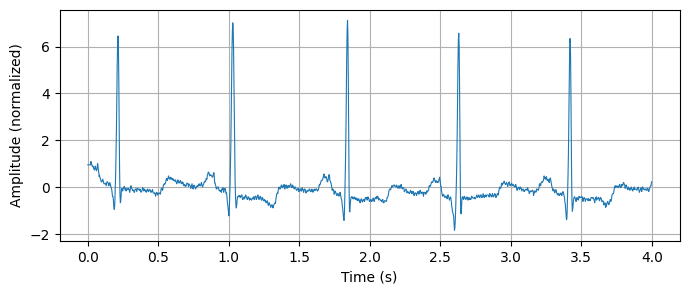

In [102]:
fig, ax = plt.subplots(figsize=(8, 3))

# Plot 4 seconds to show several full cardiac cycles
ax.plot(np.arange(4 * fs) / fs, ecg[:4 * fs], linewidth=0.8)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (normalized)")
ax.grid(True)
plt.show()

Build one-step-ahead training sequences

In [103]:
# Sequence length: 1 second = one full cardiac cycle
T_ecg = 360

# Input: windows of T_ecg samples
# Target: the single next sample (one-step-ahead)
X_train_ecg = np.array([ecg_train[i : i + T_ecg]
                         for i in range(len(ecg_train) - T_ecg)])

Y_train_ecg = np.array([ecg_train[i + T_ecg]
                         for i in range(len(ecg_train) - T_ecg)])

# Reshape to (T, B, 1) and (B, 1)
X_train_ecg = X_train_ecg.reshape(-1, T_ecg, 1).transpose(1, 0, 2)
Y_train_ecg = Y_train_ecg.reshape(-1, 1)


Define LSTM

In [104]:
device = torch.device("mps")

In [105]:
hidden_size_ecg = 32
num_layers_ecg  = 3

lstm_ecg = nn.LSTM(input_size=1,
                   hidden_size=hidden_size_ecg,
                   num_layers=num_layers_ecg).to(device)

fc_lstm_ecg = nn.Linear(hidden_size_ecg, 1).to(device)

optimizer_lstm_ecg = torch.optim.Adam(list(lstm_ecg.parameters()) + 
                                      list(fc_lstm_ecg.parameters()), lr=1e-3)

def forward_lstm_ecg(X):
    out, _ = lstm_ecg(X)
    # Predict the single next sample from the last hidden state
    return fc_lstm_ecg(out[-1])   # (B, 1)

WaveNet definition

In [106]:
num_layers_ecg_wn  = 10
kernel_size_ecg_wn = 3
in_channels        = 1

layers_ecg = []
for i in range(num_layers_ecg_wn):
    dilation = 2 ** i
    padding  = (kernel_size_ecg_wn - 1) * dilation
    layers_ecg.append(nn.Conv1d(in_channels, hidden_size_ecg,
                                kernel_size=kernel_size_ecg_wn,
                                dilation=dilation,
                                padding=padding))
    layers_ecg.append(nn.Tanh())
    in_channels = hidden_size_ecg

conv_stack_ecg = nn.Sequential(*layers_ecg).to(device)
fc_wn_ecg      = nn.Linear(hidden_size_ecg, 1).to(device)

optimizer_wn_ecg = torch.optim.Adam(list(conv_stack_ecg.parameters()) + 
                                    list(fc_wn_ecg.parameters()), lr=1e-3)

def forward_wavenet_ecg(X):
    # Conv1d expects (B, D, T), input is (T, B, D)
    x = X.permute(1, 2, 0)
    for layer in conv_stack_ecg:
        if isinstance(layer, nn.Conv1d):
            x = layer(x)[:, :, :X.shape[0]]   # trim causal padding
        else:
            x = layer(x)                       # activation
    # Predict from the last timestep
    return fc_wn_ecg(x[:, :, -1])             # (B, 1)

LSTM training

In [107]:
epochs_ecg = 3
batch_size_ecg = 32

lstm_ecg.train()
fc_lstm_ecg.train()

for epoch in range(epochs_ecg):

    epoch_losses = []
    indices = np.random.permutation(X_train_ecg.shape[1])

    for start_idx in range(0, len(indices), batch_size_ecg):

        batch_idx = indices[start_idx:start_idx + batch_size_ecg]

        Xb = torch.as_tensor(X_train_ecg[:, batch_idx, :], dtype=torch.float32).to(device)
        Yb = torch.as_tensor(Y_train_ecg[batch_idx, :],    dtype=torch.float32).to(device)

        optimizer_lstm_ecg.zero_grad()
        loss = torch.sum((forward_lstm_ecg(Xb) - Yb) ** 2)
        loss.backward()
        optimizer_lstm_ecg.step()
        epoch_losses.append(loss.item())

    print(f"\rLSTM | Epoch {epoch+1:02d}/{epochs_ecg} | Train loss: {np.mean(epoch_losses):.4f}", end="", flush=True)


LSTM | Epoch 03/3 | Train loss: 0.1607

Cell 7 — WaveNet training

In [108]:
conv_stack_ecg.train()
fc_wn_ecg.train()

for epoch in range(epochs_ecg):

    epoch_losses = []
    indices = np.random.permutation(X_train_ecg.shape[1])

    for start_idx in range(0, len(indices), batch_size_ecg):

        batch_idx = indices[start_idx:start_idx + batch_size_ecg]

        Xb = torch.as_tensor(X_train_ecg[:, batch_idx, :], dtype=torch.float32).to(device)
        Yb = torch.as_tensor(Y_train_ecg[batch_idx, :],    dtype=torch.float32).to(device)

        optimizer_wn_ecg.zero_grad()
        loss = torch.sum((forward_wavenet_ecg(Xb) - Yb) ** 2)
        loss.backward()
        optimizer_wn_ecg.step()
        epoch_losses.append(loss.item())

    print(f"\rWaveNet | Epoch {epoch+1:02d}/{epochs_ecg} | Train loss: {np.mean(epoch_losses):.4f}", end="", flush=True)

WaveNet | Epoch 03/3 | Train loss: 0.3354

Cell 9 — Autoregressive generation

In [109]:
# Generate 2 seconds of signal autoregressively
G_ecg = 2 * fs   # 720 samples
true_ecg = ecg_test[T_ecg : T_ecg + G_ecg]

# Seed both models with the first T_ecg samples of the test set
preds_lstm_ecg = []
preds_wn_ecg   = []

# LSTM generation
lstm_ecg.eval()
fc_lstm_ecg.eval()

buffer = list(ecg_test[:T_ecg])
with torch.no_grad():
    for _ in range(G_ecg):
        x = torch.as_tensor(
            np.array(buffer[-T_ecg:]).reshape(T_ecg, 1, 1),
            dtype=torch.float32).to(device)
        y = float(forward_lstm_ecg(x).cpu())
        preds_lstm_ecg.append(y)
        buffer.append(y)   # feed prediction back as input

# WaveNet generation
conv_stack_ecg.eval()
fc_wn_ecg.eval()

buffer = list(ecg_test[:T_ecg])
with torch.no_grad():
    for _ in range(G_ecg):
        x = torch.as_tensor(
            np.array(buffer[-T_ecg:]).reshape(T_ecg, 1, 1),
            dtype=torch.float32).to(device)
        y = float(forward_wavenet_ecg(x).cpu())
        preds_wn_ecg.append(y)
        buffer.append(y)   # feed prediction back as input

preds_lstm_ecg = np.array(preds_lstm_ecg)
preds_wn_ecg   = np.array(preds_wn_ecg)

Cell 9 — Plot

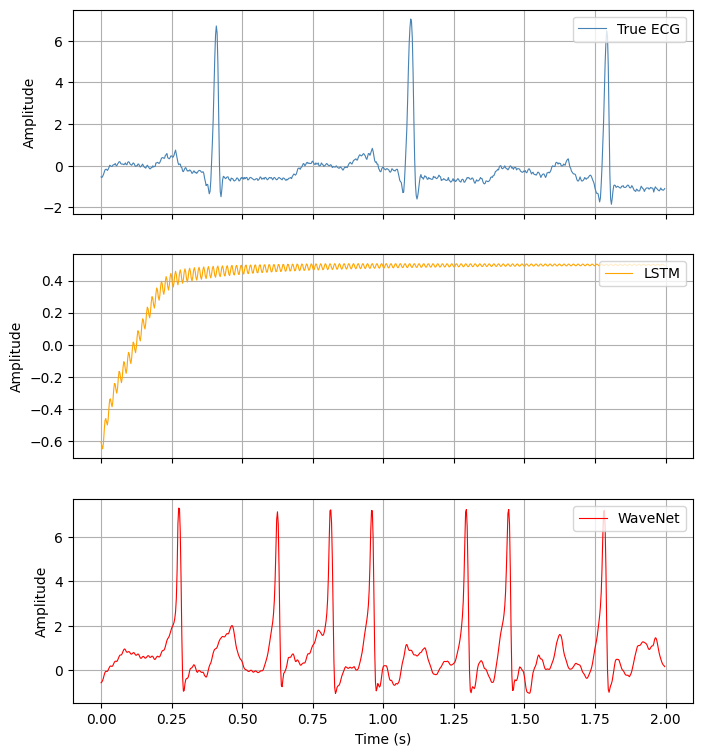

In [110]:
t_axis = np.arange(G_ecg) / fs   # time in seconds

fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

axes[0].plot(t_axis, true_ecg, linewidth=0.8, color="steelblue", label="True ECG")
axes[1].plot(t_axis, preds_lstm_ecg, linewidth=0.8, color="orange", label="LSTM")
axes[2].plot(t_axis, preds_wn_ecg, linewidth=0.8, color="red", label="WaveNet")

for ax in axes:
    ax.legend(loc="upper right")
    ax.grid(True)
    ax.set_ylabel("Amplitude")

axes[2].set_xlabel("Time (s)")

plt.show()

The key thing the plot will show: LSTM collapses to a nearly flat line after a few steps because without the true signal in its buffer it loses track of the oscillation. WaveNet maintains the cardiac rhythm because its dilated receptive field gives it enough structural memory to sustain the periodic pattern autoregressively.

The autoregressive generation is similar to the recursive multi-step forecasting, they are the same mechanism. The difference is in scope and intent. Recursive multi-step forecasting applies this mechanism for a fixed short horizon on a structured tabular series, and is evaluated on prediction accuracy over that window. Autoregressive generation applies the same mechanism **indefinitely**, and is evaluated on whether the output **maintains the statistical structure** of the original signal (rhythm, amplitude, periodicity) rather than matching specific future values point by point.

In the ECG case the goal **is not to predict** the exact millivolt value, which is impossible without the true signal, but to **generate a plausible ECG** that looks like it came from the same heart.